In [1]:
##################################
### Import the usual libraries ###
##################################

### Other
import warnings
warnings.filterwarnings('ignore')

### Matplotlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 30})

from tqdm import tqdm_notebook

In [2]:
import numpy as np
import astropy
from astropy.io import fits
from astropy.table import Table
from scipy.interpolate import InterpolatedUnivariateSpline
import warnings

class WhatsMyAgeAgain():
    '''
    Class to calculate a star's age and extinction using PARSEC isochrones and extinction law
    from Cardelli et al. 1989
    '''
    def __init__(self,mh,am,distance,rv,isochrones):
        
        '''
        feh: [float] metallicity [M/H] of star
        am: [float] [$\alpha$/M] of star
        distance: [float] distance to star in pc
        isochrones: [astropy Table] PARSEC isochrone table
        '''
        
        # stellar parameters
        self.salfeh = mh+np.log10(0.638*(10**am)+0.362) #Salaris et al. 1993
        self.dist = distance
        
        # PARSEC isochrones
        self.distmod = 5.0*np.log10(distance)-5.0
        
        # PARSEC isochrones
        self.rv = rv
        self.labels = ['Jmag','Hmag','Ksmag']
        
        self.uniq_ages = np.unique(isochrones['logAge'])
        self.iso = isochrones[np.where(isochrones['MH']==self.closest(isochrones['MH'],self.salfeh))]
        
        age_idx = []
        for i in range(len(self.uniq_ages)):
            ages, = np.where(self.iso['logAge']==self.uniq_ages[i])
            age_idx.append(np.array([min(ages),max(ages)]))
        
        self.age_idx = np.asarray(age_idx)
                
        # Effective Wavelengths of different passbands
        self.leff = {'BP':0.5387,'G':0.6419,'RP':0.7667,'J':1.2345,'H':1.6393,'K':2.1757} # mircons
        
    def closest(self,data,value):
        '''
        Find nearest value in array to given value
        
        Inputs:
        ------
            data: data to search through 
            value: value of interest
        '''
        
        data = np.asarray(data)
    
        return data[(np.abs(np.subtract(data,value))).argmin()]
    
    def neighbors(self,data,value):
        '''
        Find values of two elements closest to the given value
    
        Inputs:
        ------
            data: data to search through 
            value: value of interest
        
        Output:
        ------
            close1: closest value under the given value
            close2: closest value over the given value
        '''
    
        data = np.asarray(data)
        close1 = data[(np.abs(np.subtract(data,value))).argmin()]
        data = data[np.where(data!=close1)]
        close2 = data[(np.abs(np.subtract(data,value))).argmin()]
    
        return close1,close2
    
    def cardelli_a(self,x):
        '''
        a(x) function from Cardelli et al. 1989
    
        Input:
        -----
            x: effective wavelength in units of 1/micron
        
        Output:
        ------
            a: a function value  
        '''
        if 0.3 <= x < 1.1:
            a = 0.574*(x**1.61)
            return a
    
        elif 1.1 <= x < 3.3:
            y = x - 1.82
            a = (1.+0.17699*y-0.50477*(y**2)-0.02427*(y**3)+0.72085*(y**4)+
                 0.01979*(y**5)-0.77530*(y**6)+0.32999*(y**7))
            return a
    
        elif 3.3 <= x < 8.0:
            if x < 5.9:
                a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)
                return a
        
            else:
                fa = -0.04473*((x-5.9)**2)+0.1207*((x-5.9)**3)
                a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)+fa
                return a       
    
    def cardelli_b(self,x):
        '''
        b(x) function from Cardelli et al. 1989
    
        Input:
        -----
            x: effective wavelength in units of 1/micron
        
        Output:
        ------
            b: b function value 
        '''
        if 0.3 <= x < 1.1:
            b = -0.527*(x**1.61)
            return b
    
        elif 1.1 <= x <= 3.3:
            y = x - 1.82
            b = (1.41338*y+2.28305*(y**2)+1.07233*(y**3)-5.38434*(y**4)-
                 0.62251*(y**5)+5.30260*(y**6)-2.09002*(y**7))
            return b
    
        elif 3.3 <= x < 8.0:
            if x < 5.9:
                b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)
                return b
        
            else:
                fb = 0.2130*((x-5.9)**2)+0.1207*((x-5.9)**3)
                b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)+fb
                return b
    
    def cardelli_alav(self,wave):
        '''
        Calculate A\lambda/Av
    
        Inputs:
        ------
            wave: effective wavelength in units of micron
            rv: Rv value (=Av/E(B_V))
        
        Output:
        ------
            alav: A\lambda/Av
        '''
        x=1/wave
        alav = self.cardelli_a(x)+self.cardelli_b(x)/self.rv
        return alav
        
    def InitialAge(self,teff,kmag,ak):
        '''
        Calculate an initial guess for the age of a star
        
        Inputs:
        ------
            teff: temperature of a star
            kmag: K magnitude of a star
            ak: the extinction in the 2MASS K band
        
        Output:
        ------
            age_guess: initial guess for age
        
        '''
        
        iso_ = self.iso[np.where(self.iso['MH']==self.closest(self.iso['MH'],self.salfeh))]
        
        euclid = (np.subtract(iso_['Ksmag'],kmag-ak-self.distmod)**2+
                  np.subtract(10**iso_['logTe'],teff)**2)
        
        age_guess = np.median(10**iso_['logAge'][euclid.argmin()]/10**9)
        
        return age_guess    
        
    def Teff2AppMags(self,teff,age,ak):
        '''
        Calculate the expected apparent magnitude of a star
        
        Inputs:
        ------
            teff: temperature of star
            age: age of star
            ak: extinction in the 2MASS K band
            
            # parameters defined in __init__
            self.dist: distance to star
            self.iso: set of PARSEC isochrones
        
        Output:
        ------
            calc_mag: expected intrinsic magnitude for the given temperature
        '''
        
        #Some calcualtions to set things up
        lgteff = np.log10(teff)
        
        ajak = self.cardelli_alav(self.leff['J'])/self.cardelli_alav(self.leff['K'])
        ahak = self.cardelli_alav(self.leff['H'])/self.cardelli_alav(self.leff['K'])
        
        extincts = np.array([ajak,ahak,1.0])*ak
        
        lgage = np.log10(age*10**9)
        
        #print('Input [Age, Ak]: ',[age,ak])
        
        # Figure out if age is actually in the ages given in the isochrone table
        if lgage in self.uniq_ages:
            
            ### pick out a single isochrone 
            aidx, = np.where(self.uniq_ages==lgage)
            iso_ = self.iso[self.age_idx[int(aidx)][0]:self.age_idx[int(aidx)][1]]
            
            if lgteff < min(iso_['logTe']) or lgteff > max(iso_['logTe']):
                #print('[J,H,K]: ',np.array([999999.0, 999999.0, 999999.0]))
                return np.array([999999.0, 999999.0, 999999.0])
            
            ### sort so temp is always increasing
            sidx = np.argsort(iso_['logTe'])
            slogTe = iso_['logTe'][sidx]
            _, uidx = np.unique(slogTe,return_index=True)
            slogTe = slogTe[uidx]
            
            ### use a spline to get the apparent mags
            calc_mags = 999999.0*np.ones(3)
            for i in range(3):
                mag_spl = InterpolatedUnivariateSpline(slogTe,iso_[self.labels[i]][sidx][uidx])
                calc_mags[i] = mag_spl(lgteff)+self.distmod+extincts[i]
            
            #print('[J,H,K]: ',calc_mags)
            return calc_mags
            
        else:
            lgage_lo,lgage_hi = self.neighbors(self.uniq_ages,lgage)
            #print('[lgage_lo,lgage_hi]: ',[lgage_lo,lgage_hi])
            
            ### Pick out single isochrones
        
            # younger
            aidx_lo, = np.where(self.uniq_ages==lgage_lo)
            iso_lo = self.iso[self.age_idx[int(aidx_lo)][0]:self.age_idx[int(aidx_lo)][1]]
            
            # older
            aidx_hi, = np.where(self.uniq_ages==lgage_hi)
            iso_hi = self.iso[self.age_idx[int(aidx_hi)][0]:self.age_idx[int(aidx_hi)][1]]
            
            ### Temperature Check
            if lgteff < min(iso_lo['logTe']) or lgteff > max(iso_lo['logTe']):
                #print('[J,H,K]: ',np.array([999999.0, 999999.0, 999999.0]))
                return np.array([999999.0, 999999.0, 999999.0])
            if lgteff < min(iso_hi['logTe']) or lgteff > max(iso_hi['logTe']):
                #print('[J,H,K]: ',np.array([999999.0, 999999.0, 999999.0]))
                return np.array([999999.0, 999999.0, 999999.0])
            
            ### sort so temp is always increasing
            
            # younger
            sidx_lo = np.argsort(iso_lo['logTe'])
            slogTe_lo = iso_lo['logTe'][sidx_lo]
            _, uidx_lo = np.unique(slogTe_lo,return_index=True)
            slogTe_lo = slogTe_lo[uidx_lo]
            
            # older
            sidx_hi = np.argsort(iso_hi['logTe'])
            slogTe_hi = iso_hi['logTe'][sidx_hi]
            _, uidx_hi = np.unique(slogTe_hi,return_index=True)
            slogTe_hi = slogTe_hi[uidx_hi]
            
            ### use a spline to get the apparent mags
            age_lo = 10**lgage_lo/10**9
            age_hi = 10**lgage_hi/10**9
            calc_mags = 999999.0*np.ones(3)
            for i in range(3):
                mag_spl_lo = InterpolatedUnivariateSpline(slogTe_lo,iso_lo[self.labels[i]][sidx_lo][uidx_lo])
                mag_spl_hi = InterpolatedUnivariateSpline(slogTe_hi,iso_hi[self.labels[i]][sidx_hi][uidx_hi])
                age_spl_interp = np.poly1d(np.squeeze(np.polyfit([age_lo,age_hi],
                                                                 [mag_spl_lo(lgteff),mag_spl_hi(lgteff)],1)))
                calc_mags[i] = age_spl_interp(age)+self.distmod+extincts[i]
            #print('[J,H,K]: ',calc_mags)
            return calc_mags

In [3]:
leff = {'BP':0.5387,'G':0.6419,'RP':0.7667,'J':1.2345,'H':1.6393,'K':2.1757}
def cardelli_a(x):
    '''
    a(x) function from Cardelli et al. 1989
    
    Input:
    -----
        x: effective wavelength in units of 1/micron
        
    Output:
    ------
        a: a function value  
    '''
    if 0.3 <= x < 1.1:
        a = 0.574*(x**1.61)
        return a
    
    elif 1.1 <= x < 3.3:
        y = x - 1.82
        a = (1.+0.17699*y-0.50477*(y**2)-0.02427*(y**3)+0.72085*(y**4)+
                0.01979*(y**5)-0.77530*(y**6)+0.32999*(y**7))
        return a
    
    elif 3.3 <= x < 8.0:
        if x < 5.9:
            a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)
            return a
        
        else:
            fa = -0.04473*((x-5.9)**2)+0.1207*((x-5.9)**3)
            a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)+fa
            return a       
    
def cardelli_b(x):
    '''
    b(x) function from Cardelli et al. 1989
    
    Input:
    -----
        x: effective wavelength in units of 1/micron
        
    Output:
    ------
        b: b function value 
    '''
    if 0.3 <= x < 1.1:
        b = -0.527*(x**1.61)
        return b
    
    elif 1.1 <= x <= 3.3:
        y = x - 1.82
        b = (1.41338*y+2.28305*(y**2)+1.07233*(y**3)-5.38434*(y**4)-
                0.62251*(y**5)+5.30260*(y**6)-2.09002*(y**7))
        return b
    
    elif 3.3 <= x < 8.0:
        if x < 5.9:
            b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)
            return b
        
        else:
            fb = 0.2130*((x-5.9)**2)+0.1207*((x-5.9)**3)
            b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)+fb
            return b
    
def cardelli_alav(wave,rv):
    '''
    Calculate A\lambda/Av
    
    Inputs:
    ------
        wave: effective wavelength in units of micron
        rv: Rv value (=Av/E(B_V))
        
    Output:
    ------
        alav: A\lambda/Av
    '''
    x=1/wave
    alav = cardelli_a(x)+cardelli_b(x)/rv
    return alav

ejk_ak = (cardelli_alav(leff['J'],3.1)-cardelli_alav(leff['K'],3.1))/cardelli_alav(leff['K'],3.1)

def closest(data,value):
    '''
    Find nearest value in array to given value
        
    Inputs:
    ------
        data: data to search through 
        value: value of interest
    '''
        
    data = np.asarray(data)
    return data[(np.abs(np.subtract(data,value))).argmin()]

# PARSEC

In [4]:
### massive
massive = fits.getdata('/Users/joshuapovick/Desktop/Research/parsec/parsec_massive.fits.gz',0)
massive = massive[np.where(massive['label']==3.0)]
massive = massive[np.argsort(massive['logAge'])]
massive = Table(massive)['MH','logAge','logTe','logg','Gmag','G_BPmag','G_RPmag','Jmag','Hmag','Ksmag']

# GCs

In [5]:
### GCS Data
gcs = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStar-r13-l33-58932beta_apa_dist_galvel_gc.fits.gz')
cln = np.where((gcs['FE_H']>-9999.0)&(gcs['AK_TARG']>-9999.0)&(gcs['LOGG']>0.0)&(gcs['M_H_ERR']>-90.0)&
                (gcs['C_FE']>-9999.0)&(gcs['N_FE']>-9999.0))
gcs = Table(gcs[cln])

### Find Cluster with more than one star

idx = []
for i in range(len(np.unique(gcs['CLUSTER']))):
    idx.append(np.squeeze(np.where(gcs['CLUSTER']==np.unique(gcs['CLUSTER'])[i])))

for i in range(len(idx)):
    try:
        len(idx[i])
    except:
        print('bad: ',i)
        
good_names = []
for i in np.asarray(idx)[np.delete(np.asarray(list(range(len(idx)))),[24,27,37])]:
    if len(i)>10:
        good_names.append(gcs['CLUSTER'][i][0])

print(good_names)

good_clus = np.where((gcs['CLUSTER']=='47Tuc')|(gcs['CLUSTER']=='M10')|(gcs['CLUSTER']=='M107')|
                     (gcs['CLUSTER']=='M12')|(gcs['CLUSTER']=='M13')|(gcs['CLUSTER']=='M19')|
                     (gcs['CLUSTER']=='M2')|(gcs['CLUSTER']=='M22')|(gcs['CLUSTER']=='M3')|
                     (gcs['CLUSTER']=='M4')|(gcs['CLUSTER']=='M5')|(gcs['CLUSTER']=='M53')|
                     (gcs['CLUSTER']=='M54')|(gcs['CLUSTER']=='M55')|(gcs['CLUSTER']=='M71')|
                     (gcs['CLUSTER']=='M79')|(gcs['CLUSTER']=='NGC1851')|(gcs['CLUSTER']=='NGC2808')|
                     (gcs['CLUSTER']=='NGC288')|(gcs['CLUSTER']=='NGC3201')|(gcs['CLUSTER']=='NGC362')|
                     (gcs['CLUSTER']=='NGGC6388')|(gcs['CLUSTER']=='NGC6397')|(gcs['CLUSTER']=='NGC6752')|
                     (gcs['CLUSTER']=='omegaCen'))

gcs = gcs[good_clus]

bad:  24
bad:  27
bad:  37
['47Tuc', 'M10', 'M107', 'M12', 'M13', 'M19', 'M2', 'M22', 'M3', 'M4', 'M5', 'M53', 'M54', 'M55', 'M71', 'M79', 'NGC1851', 'NGC2808', 'NGC288', 'NGC3201', 'NGC362', 'NGC6388', 'NGC6397', 'NGC6752', 'omegaCen']


In [6]:
from scipy.optimize import curve_fit

# leff2MASS = {'Jmag':12345.,'Hmag':16393.,'Ksmag':21757.}

p0 = [12.0,0.5]

idx = 1024
CalcAge = WhatsMyAgeAgain(gcs['M_H'][idx],gcs['ALPHA_M'][idx],10400,3.1,massive)
CalcAge.InitialAge(gcs['TEFF'][idx],gcs['K'][idx],gcs['AK_TARG'][idx])

popt,pcov = curve_fit(CalcAge.Teff2AppMags,gcs['TEFF'][idx],
                      np.array([[gcs['J'][idx],gcs['H'][idx],gcs['K'][idx]]],dtype=float).T.ravel(),
                      p0=p0,bounds=((0.,0.),(14.,2.)),method='trf')

print('Initial',p0)
print('Age; Ak',popt)
print(pcov)

Initial [12.0, 0.5]
Age; Ak [5.04998394 0.04548418]
[[ 0.07706279 -0.00448881]
 [-0.00448881  0.00029499]]


In [187]:
### GCs distances in pc
harris = np.array([4.5,4.4,6.4,4.8,7.1,8.8,11.5,3.2,10.2,2.2,7.5,17.9,26.5,5.4,4.0,12.9,12.1,9.6,8.9,4.9,
                   8.6,2.3,4.0,5.2])*1000.

gcs_dist = 999999.0*np.ones(len(gcs))
for i in range(len(np.unique(gcs['CLUSTER']))):
    clus = np.where(gcs['CLUSTER']==np.unique(gcs['CLUSTER'])[i])
    gcs_dist[clus] = harris[i]

### Run 2MASS code
guess_ages = np.arange(0,14)
guess_aks = [0,0.5,1.0]

best_ages = 999999.0*np.ones(len(gcs))
best_chis = 999999.0*np.ones(len(gcs))
best_aks = 999999.0*np.ones(len(gcs))

for i in tqdm_notebook(range(len(gcs))):
    curve_ages = []
    curve_aks = []
    curve_chi = []
    
    CalcAge = WhatsMyAgeAgain(gcs['M_H'][i],gcs['ALPHA_M'][i],gcs_dist[i],3.1,massive)
    for j in range(len(guess_ages)):
        for k in range(len(guess_aks)):
            try:
                popt,_ = curve_fit(CalcAge.Teff2AppMags,gcs['TEFF'][i],
                                   np.array([[gcs['J'][i],gcs['H'][i],gcs['K'][i]]],dtype=float).T.ravel(),
                                   p0=[guess_ages[j],guess_aks[k]],bounds=((0.,0.),(14.,2.)),method='trf',
                                   sigma=[gcs['J_ERR'][i],gcs['H_ERR'][i],gcs['K_ERR'][i]],maxfev=5000)
            
                curve_ages.append(popt[0])
                curve_aks.append(popt[1])
                curve_mags = np.asarray(CalcAge.Teff2AppMags(gcs['TEFF'][i],popt[0],popt[1]))
            
                obs_mags = np.array([gcs['J'][i],gcs['H'][i],gcs['K'][i]])
                obs_mags_err = np.array([gcs['J_ERR'][i],gcs['H_ERR'][i],gcs['K_ERR'][i]])
            
                curve_chi.append(sum((curve_mags-obs_mags)**2/obs_mags_err**2))
            
            except:
                print([i,j,k])
                curve_ages.append(999999.0)
                curve_aks.append(999999.0)
                curve_mags = np.array([999999.0,999999.0,999999.0])
                
                obs_mags = np.array([gcs['J'][i],gcs['H'][i],gcs['K'][i]])
                obs_mags_err = np.array([gcs['J_ERR'][i],gcs['H_ERR'][i],gcs['K_ERR'][i]])
                curve_chi.append(999999.0)
                
    best_idx = np.asarray(curve_chi).argmin()
    best_chis[i] = np.min(curve_chi)
    best_ages[i] = np.asarray(curve_ages)[best_idx]
    best_aks[i] = np.asarray(curve_aks)[best_idx]

[435, 7, 1]
[992, 7, 1]
[1083, 3, 2]
[1087, 9, 1]



In [8]:
gcs_clus = np.unique(gcs['CLUSTER'])
ejk_ak = (cardelli_alav(leff['J'],3.1)-cardelli_alav(leff['K'],3.1))/cardelli_alav(leff['K'],3.1)
# ejk = ejk_ak*best_aks

# for i in range(len(gcs_clus)):
#     clus = np.where((gcs['CLUSTER']==gcs_clus[i])&(gcs['LOGG']<2.984853))
#     isopick = np.where(massive['MH']==closest(massive['MH'],np.nanmedian(gcs['M_H'][clus])+
#                                               np.log10(0.638*(10**np.nanmedian(gcs['ALPHA_M'][clus]))+0.362)))
    
#     plt.figure(figsize=[20,20])
#     plt.scatter((massive['Jmag']-massive['Ksmag'])[isopick],massive['Ksmag'][isopick]+5.*np.log10(harris[i])-5.0,
#                 c=10**massive['logAge'][isopick]/10**9,cmap='tab20',zorder=0)
#     plt.colorbar()

#     plt.errorbar((gcs['J']-gcs['K']-ejk)[clus],gcs['K'][clus]-best_aks[clus],c='k',
#                  xerr=np.sqrt(gcs['K_ERR']**2+gcs['J_ERR']**2)[clus],yerr=gcs['K_ERR'][clus],ls='none')
    
#     plt.scatter((gcs['J']-gcs['K']-ejk)[clus],gcs['K'][clus]-best_aks[clus],c='k',marker='*',s=500,zorder=1)
    
#     plt.gca().invert_yaxis()
#     plt.xlabel(r'J - K')
#     plt.ylabel(r'K')
#     plt.title(r'K, J - K; {}; Color as Age'.format(gcs_clus[i]))
#     plt.show()

In [9]:
# plt.plot(best_aks)

In [10]:
m22_idx, = np.where(gcs['CLUSTER']=='M22')
# m22_idx

# plt.plot(best_aks[m22_idx])
# plt.plot(best_aks[m22_idx]*ejk_ak);

# np.median(best_aks[m22_idx])

In [11]:
isopick, = np.where(massive['MH']==closest(massive['MH'],np.nanmedian(gcs['M_H'][m22_idx])+
                                              np.log10(0.638*(10**np.nanmedian(gcs['ALPHA_M'][m22_idx]))+0.362))) 
# plt.figure(figsize=[20,20])
# plt.scatter((massive['Jmag']-massive['Ksmag'])[isopick],
#             massive['Ksmag'][isopick]+5.0*np.log10(gcs_dist[m22_idx][0])-5.0,
#             c=10**massive['logAge'][isopick]/10**9,cmap='tab20')
# plt.gca().invert_yaxis()

# plt.colorbar()

# plt.errorbar((gcs['J']-gcs['K']-ejk)[m22_idx],gcs['K'][m22_idx]-best_aks[m22_idx],c='k',
#                  xerr=np.sqrt(gcs['K_ERR']**2+gcs['J_ERR']**2)[m22_idx],yerr=gcs['K_ERR'][m22_idx],ls='none')
    
# plt.scatter((gcs['J']-gcs['K']-ejk)[m22_idx],gcs['K'][m22_idx]-best_aks[m22_idx],c='k',marker='*',s=500,zorder=1)
    
# # plt.gca().invert_yaxis()
# plt.xlabel(r'J - K')
# plt.ylabel(r'K')
# plt.title(r'K, J - K; {}; Color as Age'.format(gcs['CLUSTER'][m22_idx][0]))
# plt.show()

# #####
# plt.figure(figsize=[20,20])
# plt.scatter((massive['Jmag']-massive['Ksmag'])[isopick],
#             massive['Ksmag'][isopick]+5.0*np.log10(gcs_dist[m22_idx][0])-5.0,
#             c=10**massive['logAge'][isopick]/10**9,cmap='tab20')
# plt.gca().invert_yaxis()

# plt.colorbar()

# plt.errorbar((gcs['J']-gcs['K']-ejk_ak*np.median(best_aks))[m22_idx],gcs['K'][m22_idx]-best_aks[m22_idx],c='k',
#                  xerr=np.sqrt(gcs['K_ERR']**2+gcs['J_ERR']**2)[m22_idx],yerr=gcs['K_ERR'][m22_idx],ls='none')
    
# plt.scatter((gcs['J']-gcs['K']-ejk_ak*np.median(best_aks))[m22_idx],gcs['K'][m22_idx]-best_aks[m22_idx],c='k',
#             marker='*',s=500,zorder=1)
    
# # plt.gca().invert_yaxis()
# plt.xlabel(r'J - K')
# plt.ylabel(r'K')
# plt.title(r'K, J - K; {}; Color as Age; Median Ejk'.format(gcs['CLUSTER'][m22_idx][0]))
# plt.show()

# #####
# plt.figure(figsize=[20,20])
# plt.scatter((massive['Jmag']-massive['Ksmag'])[isopick],
#             massive['Ksmag'][isopick]+5.0*np.log10(gcs_dist[m22_idx][0])-5.0,
#             c=10**massive['logAge'][isopick]/10**9,cmap='tab20')
# plt.gca().invert_yaxis()

# plt.colorbar()

# plt.errorbar((gcs['J']-gcs['K']-ejk_ak*np.mean(best_aks))[m22_idx],gcs['K'][m22_idx]-best_aks[m22_idx],c='k',
#                  xerr=np.sqrt(gcs['K_ERR']**2+gcs['J_ERR']**2)[m22_idx],yerr=gcs['K_ERR'][m22_idx],ls='none')
    
# plt.scatter((gcs['J']-gcs['K']-ejk_ak*np.mean(best_aks))[m22_idx],gcs['K'][m22_idx]-best_aks[m22_idx],c='k',
#             marker='*',s=500,zorder=1)
    
# # plt.gca().invert_yaxis()
# plt.xlabel(r'J - K')
# plt.ylabel(r'K')
# plt.title(r'K, J - K; {}; Color as Age; Mean Ejk'.format(gcs['CLUSTER'][m22_idx][0]))
# plt.show()

# #####
# plt.figure(figsize=[20,20])
# plt.scatter((massive['Jmag']-massive['Ksmag'])[isopick],
#             massive['Ksmag'][isopick]+5.0*np.log10(gcs_dist[m22_idx][0])-5.0,
#             c=10**massive['logAge'][isopick]/10**9,cmap='tab20')
# plt.gca().invert_yaxis()

# plt.colorbar()

# plt.errorbar((gcs['J']-gcs['K'])[m22_idx],gcs['K'][m22_idx],c='k',
#                  xerr=np.sqrt(gcs['K_ERR']**2+gcs['J_ERR']**2)[m22_idx],yerr=gcs['K_ERR'][m22_idx],ls='none')
    
# plt.scatter((gcs['J']-gcs['K'])[m22_idx],gcs['K'][m22_idx],c='k',marker='*',s=500,zorder=1)
    
# # plt.gca().invert_yaxis()
# plt.xlabel(r'J - K')
# plt.ylabel(r'K')
# plt.title(r'K, J - K; {}; Color as Age'.format(gcs['CLUSTER'][m22_idx][0]))
# plt.show()

In [12]:
# for i in range(len(np.unique(gcs[m22_idx]['APOGEE_ID']))):
#     print(r'{}: {}'.format(np.unique(gcs[m22_idx]['APOGEE_ID'])[i],
#                            np.where(gcs['APOGEE_ID']==np.unique(gcs[m22_idx]['APOGEE_ID'])[i])))
    
# for i in m22_idx:
#     print(gcs['CLUSTER'][i])

# Diagnostic plots for M22

In [13]:
# initial_age = np.array([])
# initial_aks = np.array([])
# for i in tqdm_notebook(range(len(guess_ages))):
#     for j in range(len(guess_aks)):
        
#         initial_age = np.append(initial_age,guess_ages[i])
#         initial_aks = np.append(initial_aks,guess_aks[j])
        
# initial_age
# initial_aks

In [14]:
# theo_mags0 = []
# theo_magsak = []

# for i in tqdm_notebook(range(len(gcs))):
#     CalcAge = WhatsMyAgeAgain(gcs['M_H'][i],gcs['ALPHA_M'][i],gcs_dist[i],massive)
#     theo0 = []
#     theoak = []
#     for j in range(0,14):
#         theo0.append(CalcAge.Teff2AppMags(gcs['TEFF'][i],j,0))
#         theoak.append(CalcAge.Teff2AppMags(gcs['TEFF'][i],j,best_aks[i]))
    
#     theo_mags0.append(theo0)
#     theo_magsak.append(theoak)

In [15]:
# plt.figure(figsize=[10,10])
# plt.scatter((massive['Jmag']-massive['Ksmag'])[isopick],
#             massive['Ksmag'][isopick]+5.0*np.log10(gcs_dist[m22_idx][0])-5.0,
#             c=10**massive['logAge'][isopick]/10**9,cmap='tab20')
# plt.gca().invert_yaxis()

# # plt.colorbar()
    
# plt.scatter((gcs['J']-gcs['K']-ejk)[m22_idx],gcs['K'][m22_idx]-best_aks[m22_idx],c=m22_idx,marker='*',s=500,
#             zorder=1)
# plt.colorbar()

# # plt.gca().invert_yaxis()
# plt.xlabel(r'J - K')
# plt.ylabel(r'K')
# plt.title(r'K, J - K; {}; Color as Age'.format(gcs['CLUSTER'][m22_idx][0]))
# plt.show()

# #######
# plt.figure(figsize=[10,10])
# plt.scatter((massive['Jmag']-massive['Ksmag'])[isopick],
#             massive['Ksmag'][isopick]+5.0*np.log10(gcs_dist[m22_idx][0])-5.0,
#             c=10**massive['logAge'][isopick]/10**9,cmap='tab20')
# plt.gca().invert_yaxis()

# # plt.colorbar()
    
# plt.scatter((gcs['J']-gcs['K']-ejk)[m22_idx],gcs['K'][m22_idx]-best_aks[m22_idx],c=range(len(m22_idx)),marker='*',
#             s=500,zorder=1)
# plt.colorbar()

# # plt.gca().invert_yaxis()
# plt.xlabel(r'J - K')
# plt.ylabel(r'K')
# plt.title(r'K, J - K; {}; Color as Age'.format(gcs['CLUSTER'][m22_idx][0]))
# plt.show()

In [16]:
# (gcs['J']-gcs['K']-ejk)[m22_idx][78]

In [17]:
# np.where(gcs[m22_idx]['APOGEE_ID']==gcs[m22_idx]['APOGEE_ID'][78])
# gcs['APOGEE_ID'][m22_idx][78]
m22star = np.where(gcs['APOGEE_ID']=='2M18364201-2351316')
m22star

(array([1826]),)

In [18]:
# np.min((gcs['J']-gcs['K']-ejk)[m22_idx])
# m22star, = np.where((gcs['J']-gcs['K']-ejk)[m22_idx]==np.min((gcs['J']-gcs['K']-ejk)[m22_idx]))
# m22star

# np.where(gcs[m22_idx]['APOGEE_ID']==gcs[m22_idx]['APOGEE_ID'][m22star])

In [19]:
# np.array([[gcs['J'][idx],gcs['H'][idx],gcs['K'][idx]]],dtype=float).T.ravel()

In [20]:
ages0 = np.arange(0,15,1.0)
aks0 = np.array([0,0.5,1.0])

initial_age = np.array([])
initial_aks = np.array([])

chi = 999999.0*np.ones((len(ages0),len(aks0)))

idx = m22star
CalcAge = WhatsMyAgeAgain(gcs['M_H'][idx],gcs['ALPHA_M'][idx],10400,3.1,massive)
age = 999999.0*np.ones((len(ages0),len(aks0)))
ak = 999999.0*np.ones((len(ages0),len(aks0)))

cmags = 999999.0*np.ones((len(ages0),len(aks0)))

for i in tqdm_notebook(range(len(ages0))):
    for j in range(len(aks0)):
#         try:
        popt,pcov = curve_fit(CalcAge.Teff2AppMags,gcs['TEFF'][idx],
                              np.array([[gcs['J'][idx][0],gcs['H'][idx][0],gcs['K'][idx][0]]],
                                       dtype=float).T.ravel(),
                              p0=[ages0[i],aks0[j]],bounds=((0.,0.),(14.,2.)),method='trf',
                              sigma=np.array([[gcs['J_ERR'][idx][0],gcs['H_ERR'][idx][0],gcs['K_ERR'][idx][0]]],
                                             dtype=float).T.ravel())
        
        age[i][j] = popt[0]
        ak[i][j] = popt[1]
        
        initial_age = np.append(initial_age,ages0[i])
        initial_aks = np.append(initial_aks,aks0[j])
        
        calc_mags = np.asarray(CalcAge.Teff2AppMags(gcs['TEFF'][idx],popt[0],popt[1]))
        print(calc_mags)
        
        mag_errs = np.array([gcs['J_ERR'][idx][0],gcs['H_ERR'][idx][0],gcs['K_ERR'][idx][0]])
        mags = np.array([gcs['J'][idx][0],gcs['H'][idx][0],gcs['K'][idx][0]])
        
#         print(sum((calc_mags-mags)**2/mag_errs**2))
    
#         import pdb; pdb.set_trace()
        chi[i][j]= sum((calc_mags-mags)**2/mag_errs**2) #sum((calc_mags-mags)**2/mag_errs**2)

print(np.array([gcs['J'][idx][0],gcs['H'][idx][0],gcs['K'][idx][0]]))
print(np.array([gcs['J_ERR'][idx][0],gcs['H_ERR'][idx][0],gcs['K_ERR'][idx][0]]))


#         chi1 = 0.
#         for k in range(len(calc_mags)):
#             chi1+=(calc_mags[k]-mags[k])**2/mag_errs[k]**2
        
    
#         chi[i][j] = chi1
        
#         print(chi1)
#         chi.append(chi1)
            
#         except:
#             print([ages0[i],aks0[j]])
#             age[i][j] = popt[0]
#             ak[i][j] = popt[1]
        
#             initial_age = np.append(initial_age,ages0[i])
#             initial_aks = np.append(initial_aks,aks0[j])
        
#             calc_mags = np.asarray(CalcAge.Teff2AppMags(gcs['TEFF'][idx],popt[0],popt[1]))
        
#             mag_errs = np.array([gcs['J_ERR'][idx],gcs['H_ERR'][idx],gcs['K_ERR'][idx]])
#             mags = np.array([gcs['J'][idx],gcs['H'][idx],gcs['K'][idx]])
    
#             chi1 = 0.
#             for k in range(len(calc_mags)):
#                 chi1+=(calc_mags[k]-mags[k])**2/mag_errs[k]**2
        
#         chi[i][j] = 999999.0
    
# bestind = np.asarray(chi).argmin()
# bestchi = np.min(chi)  

# print(bestind)
# print(bestchi)
# bestage = age[bestind] 
# bestak = ak[bestind]
# bestmag = cmags[bestind]

# print('chi',bestchi)
# print('Age',bestage)
# print('Ak',bestak)

[999999. 999999. 999999.]
[999999. 999999. 999999.]
[999999. 999999. 999999.]
[999999. 999999. 999999.]
[999999. 999999. 999999.]
[999999. 999999. 999999.]
[11.67809479 11.09212502 10.98012375]
[11.68114184 11.09073758 10.97588978]
[11.86296516 11.19061252 11.02450075]
[11.67809479 11.09212502 10.98012375]
[11.797326   11.14903452 10.99814173]
[12.18607264 11.39527941 11.15425252]
[12.05092205 11.5111422  11.42915215]
[11.67809479 11.09212502 10.98012375]
[11.68114185 11.09073757 10.97588977]
[11.67809479 11.09212502 10.98012375]
[11.68114184 11.09073758 10.97588978]
[11.90640379 11.21812798 11.0419446 ]
[11.67809479 11.09212502 10.98012376]
[11.68114184 11.09073758 10.97588978]
[11.68114184 11.09073758 10.97588978]
[12.11703012 11.57779455 11.49547256]
[11.68114184 11.09073758 10.97588978]
[11.68114185 11.09073758 10.97588978]
[11.68114184 11.09073757 10.97588978]
[11.68114184 11.09073758 10.97588978]
[11.68114185 11.09073757 10.97588977]
[11.67809479 11.09212502 10.98012375]
[11.6811

In [21]:
ages0 = np.arange(0,15,1.0)
aks0 = np.array([0,0.5,1.0])

initial_age = np.array([])
initial_aks = np.array([])

chi = 999999.0*np.ones((len(ages0),len(aks0)))

idx = m22star
CalcAge = WhatsMyAgeAgain(gcs['M_H'][idx],gcs['ALPHA_M'][idx],gcs_dist[m22star],3.1,massive)
age0 = 5.0
ak0 = 0.

popt,pcov = curve_fit(CalcAge.Teff2AppMags,gcs['TEFF'][idx],
                              np.array([[gcs['J'][idx][0],gcs['H'][idx][0],gcs['K'][idx][0]]],
                                       dtype=float).T.ravel(),
                              p0=[age0,ak0],bounds=((0.,0.),(14.,2.)),method='trf',
                              sigma=np.array([[gcs['J_ERR'][idx][0],gcs['H_ERR'][idx][0],gcs['K_ERR'][idx][0]]],
                                             dtype=float).T.ravel())
        
curve_age = popt[0]
curve_ak = popt[1]
print('   ')
print('--- FINAL VALUES ---')
print('curve_fit Age: ',popt[0])
print('curve_fit Ak: ',popt[1])
      
calc_mags = np.asarray(CalcAge.Teff2AppMags(gcs['TEFF'][idx],popt[0],popt[1]))

mag_errs = np.array([gcs['J_ERR'][idx][0],gcs['H_ERR'][idx][0],gcs['K_ERR'][idx][0]])
mags = np.array([gcs['J'][idx][0],gcs['H'][idx][0],gcs['K'][idx][0]])
    
#         import pdb; pdb.set_trace()
chi = sum((calc_mags-mags)**2/mag_errs**2)

print('chi: ',chi)

print('Catalog Mags: ',np.array([gcs['J'][idx][0],gcs['H'][idx][0],gcs['K'][idx][0]]))
print('Catalog Mag Errs: ',np.array([gcs['J_ERR'][idx][0],gcs['H_ERR'][idx][0],gcs['K_ERR'][idx][0]]))

   
--- FINAL VALUES ---
curve_fit Age:  13.624952603396974
curve_fit Ak:  0.8496309455302625
chi:  1393.449459603968
Catalog Mags:  [11.688 11.072 10.991]
Catalog Mag Errs:  [0.025 0.023 0.023]


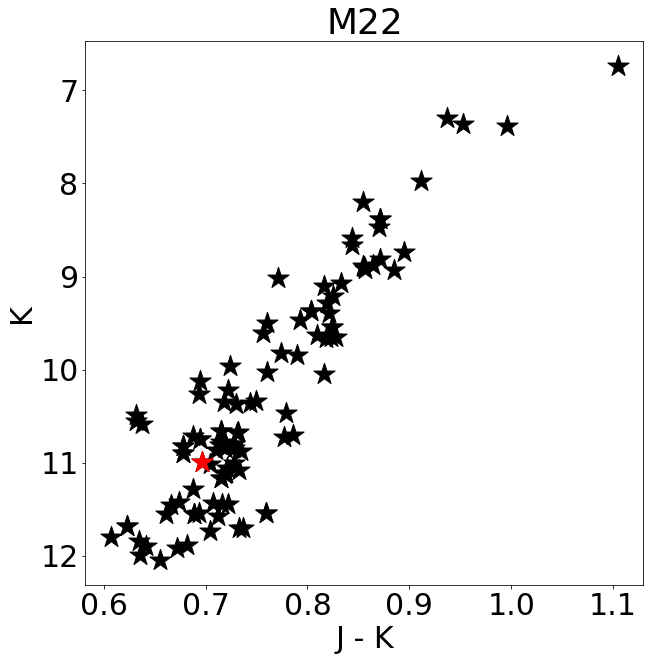

In [22]:
plt.figure(figsize=[10,10])
plt.scatter((gcs['J']-gcs['K'])[m22_idx],(gcs['K'])[m22_idx],c='k',marker='*',s=500,zorder=1) 
plt.scatter((gcs['J']-gcs['K'])[1826],(gcs['K'])[1826],c='r',marker='*',s=500,zorder=1)
plt.gca().invert_yaxis()
plt.xlabel(r'J - K')
plt.ylabel(r'K')
plt.title(r'M22')
plt.show()

In [23]:
gcs_dist[m22_idx][0]

3200.0

In [24]:
ages0 = np.arange(0,15,1.0)
aks0 = np.array([0,0.5,1.0])

initial_age = np.array([])
initial_aks = np.array([])

age = 999999.0*np.ones((len(ages0),len(aks0),len(m22_idx)))
ak = 999999.0*np.ones((len(ages0),len(aks0),len(m22_idx)))
# cmags = 999999.0*np.ones((len(ages0),len(aks0),len(m22_idx)))
chi = 999999.0*np.ones((len(ages0),len(aks0),len(m22_idx)))

for k in tqdm_notebook(range(len(m22_idx))):
    
    CalcAge = WhatsMyAgeAgain(gcs['M_H'][m22_idx[k]],gcs['ALPHA_M'][m22_idx[k]],gcs_dist[m22_idx][0],3.1,massive)
    
    for i in range(len(ages0)):
        for j in range(len(aks0)):
            try:
                popt,pcov = curve_fit(CalcAge.Teff2AppMags,gcs['TEFF'][m22_idx[k]],
                              np.array([[gcs['J'][m22_idx[k]],gcs['H'][m22_idx[k]],gcs['K'][m22_idx[k]]]],
                                       dtype=float).T.ravel(),
                              p0=[ages0[i],aks0[j]],bounds=((0.,0.),(14.,2.)),method='trf',
                              sigma=np.array([[gcs['J_ERR'][m22_idx[k]],gcs['H_ERR'][m22_idx[k]],
                                               gcs['K_ERR'][m22_idx[k]]]],
                                             dtype=float).T.ravel(),maxfev=5000)
        
                age[i,j,k] = popt[0]
                ak[i,j,k] = popt[1]
        
                calc_mags = np.asarray(CalcAge.Teff2AppMags(gcs['TEFF'][m22_idx[k]],popt[0],popt[1]))
                mag_errs = np.array([gcs['J_ERR'][m22_idx[k]],gcs['H_ERR'][m22_idx[k]],gcs['K_ERR'][m22_idx[k]]])
                mags = np.array([gcs['J'][m22_idx[k]],gcs['H'][m22_idx[k]],gcs['K'][m22_idx[k]]])
    
#         import pdb; pdb.set_trace()
                chi[i,j,k] = sum((calc_mags-mags)**2/mag_errs**2) #sum((calc_mags-mags)**2/mag_errs**2)
            
            except:
                print([i,j,k])
                age[i,j,k] = 999999.0
                ak[i,j,k] = 999999.0
                chi[i,j,k] = 999999.0 

In [25]:
for i in range(len(m22_idx)):
    print(m22_idx[i])

1748
1749
1750
1751
1752
1753
1754
1755
1756
1757
1758
1759
1760
1761
1762
1763
1764
1765
1766
1767
1768
1769
1770
1771
1772
1773
1774
1775
1776
1777
1778
1779
1780
1781
1782
1783
1784
1785
1786
1787
1788
1789
1790
1791
1792
1793
1794
1795
1796
1797
1798
1799
1800
1801
1802
1803
1804
1805
1806
1807
1808
1809
1810
1811
1812
1813
1814
1815
1816
1817
1818
1819
1820
1821
1822
1823
1824
1825
1826
1827
1828
1829
1830
1831
1832
1833
1834
1835
1836
1837
1838
1839
1840
1841
1842
1843
1844
1845
1846
1847
1848
1849
1850
1851
1852
1853
1854
1855


In [26]:
np.shape(ak)==np.shape(chi)

True

In [27]:
bestchi = [] #999999.0*np.ones(len(m22_idx))
bestak = [] #999999.0*np.ones(len(m22_idx))

for i in tqdm_notebook(range(len(m22_idx))):
    bestind = np.where(chi[:,:,i]==np.min(chi[:,:,i]))
#     print(chi[:,:,i][bestind])
    bestchi.append(chi[:,:,i][bestind][0])
    bestak.append(ak[:,:,i][bestind][0])
#     bestind = list(zip(*bestind))[0]
#     bestchi = np.append(bestchi,chi[:,:,i][bestind])
#     bestak = np.append(bestak,ak[:,:,i][bestind])

In [28]:
ejk_ak

1.4901972382364816

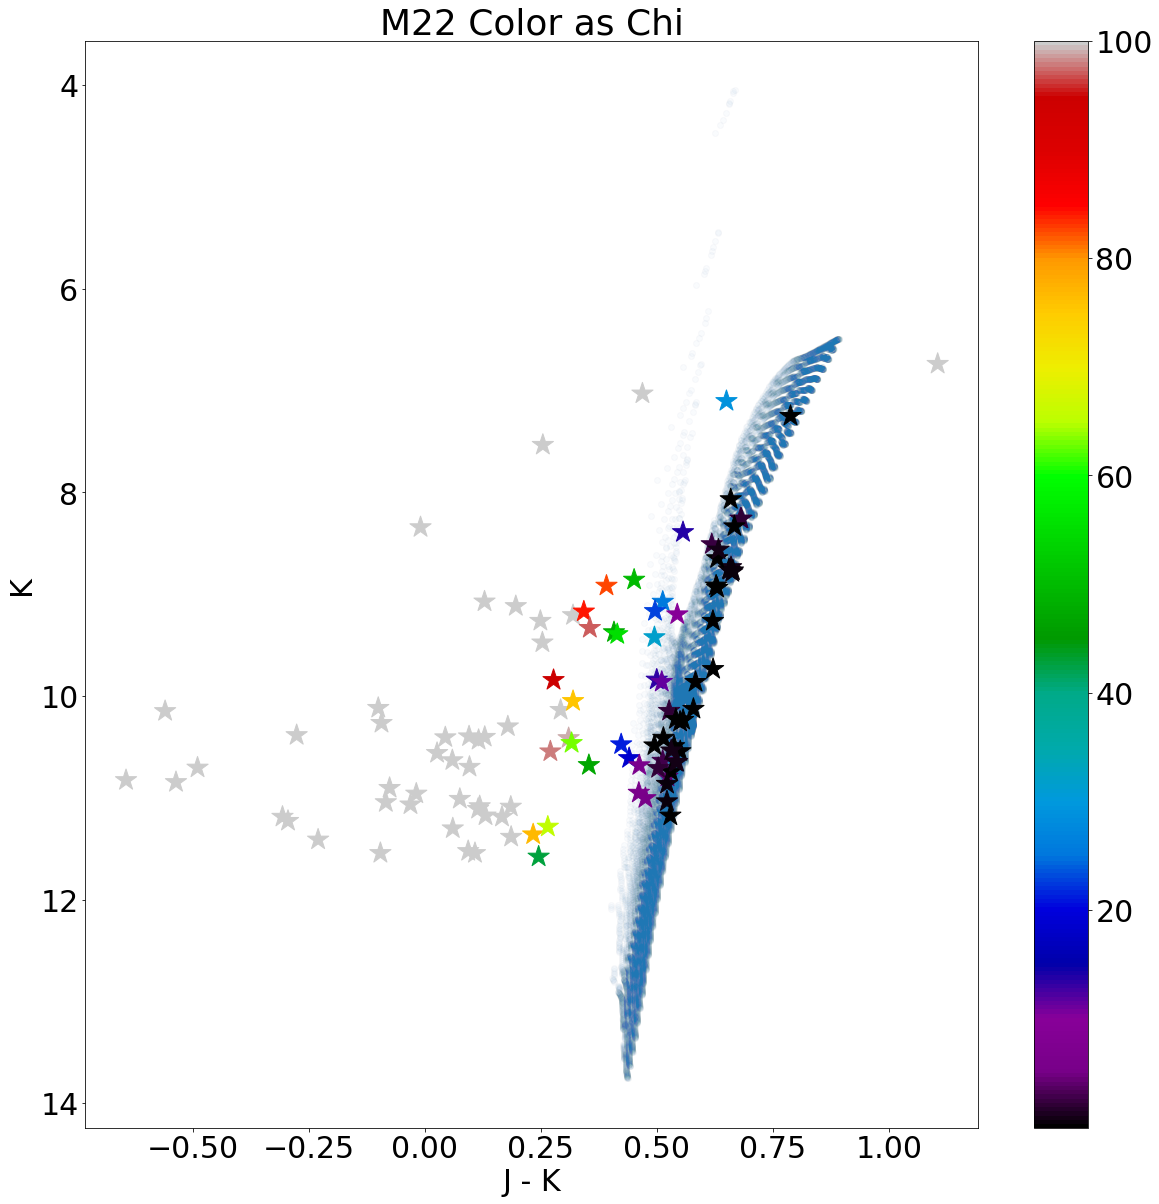

In [29]:
m22iso = np.where(massive['MH']==closest(massive['MH'],np.nanmedian(gcs['M_H'][m22_idx])+
                                              np.log10(0.638*(10**np.nanmedian(gcs['ALPHA_M'][m22_idx]))+0.362)))

plt.figure(figsize=[20,20])
plt.scatter((massive['Jmag']-massive['Ksmag'])[m22iso],
            massive[m22iso]['Ksmag']+5*np.log10(gcs_dist[m22_idx][0])-5,alpha=0.01)
plt.scatter((gcs['J']-gcs['K'])[m22_idx]-ejk_ak*np.asarray(bestak),(gcs['K'])[m22_idx]-bestak,c=bestchi,
            marker='*',s=500,zorder=1,cmap='nipy_spectral',vmax=100) 
plt.colorbar()
plt.gca().invert_yaxis()
plt.xlabel(r'J - K')
plt.ylabel(r'K')
plt.title(r'M22 Color as Chi')
plt.show()

In [30]:
#all stars keep track of chi sq cmd uses fit ak and color code by chi sq

In [31]:
m22_idx

array([1748, 1749, 1750, 1751, 1752, 1753, 1754, 1755, 1756, 1757, 1758,
       1759, 1760, 1761, 1762, 1763, 1764, 1765, 1766, 1767, 1768, 1769,
       1770, 1771, 1772, 1773, 1774, 1775, 1776, 1777, 1778, 1779, 1780,
       1781, 1782, 1783, 1784, 1785, 1786, 1787, 1788, 1789, 1790, 1791,
       1792, 1793, 1794, 1795, 1796, 1797, 1798, 1799, 1800, 1801, 1802,
       1803, 1804, 1805, 1806, 1807, 1808, 1809, 1810, 1811, 1812, 1813,
       1814, 1815, 1816, 1817, 1818, 1819, 1820, 1821, 1822, 1823, 1824,
       1825, 1826, 1827, 1828, 1829, 1830, 1831, 1832, 1833, 1834, 1835,
       1836, 1837, 1838, 1839, 1840, 1841, 1842, 1843, 1844, 1845, 1846,
       1847, 1848, 1849, 1850, 1851, 1852, 1853, 1854, 1855])

In [32]:
ages0 = np.arange(0,15,1.0)
aks0 = np.array([0,0.5,1.0])

curve_chis = 999999.0*np.ones((len(ages0),len(aks0),len(m22_idx)))
curve_ages = 999999.0*np.ones((len(ages0),len(aks0),len(m22_idx)))
curve_aks = 999999.0*np.ones((len(ages0),len(aks0),len(m22_idx)))
for k in tqdm_notebook(range(len(m22_idx))):
        CalcAge = WhatsMyAgeAgain(gcs['M_H'][m22_idx[k]],gcs['ALPHA_M'][m22_idx[k]],gcs_dist[m22_idx[k]],
                                  3.1,massive)
        for i in range(len(ages0)):
            for j in range(len(aks0)):
                try:
                    popt,_ = curve_fit(CalcAge.Teff2AppMags,gcs['TEFF'][m22_idx[k]],
                                  np.array([[gcs['J'][m22_idx[k]],gcs['H'][m22_idx[k]],gcs['K'][m22_idx[k]]]],
                                       dtype=float).T.ravel(),
                                  p0=[ages0[i],aks0[j]],bounds=((12.,0.),(12.01,2.)),method='trf',
                                  sigma=np.array([[gcs['J_ERR'][m22_idx[k]],gcs['H_ERR'][m22_idx[k]],
                                                   gcs['K_ERR'][m22_idx[k]]]],dtype=float).T.ravel(),maxfev=5000)
        
                    curve_ages[i,j,k] = popt[0]
                    curve_aks[i,j,k] = popt[1]
      
                    calc_mags = np.asarray(CalcAge.Teff2AppMags(gcs['TEFF'][m22_idx[k]],popt[0],popt[1]))
                    mag_errs = np.array([gcs['J_ERR'][m22_idx[k]],gcs['H_ERR'][m22_idx[k]],
                                         gcs['K_ERR'][m22_idx[k]]])
                    mags = np.array([gcs['J'][m22_idx[k]],gcs['H'][m22_idx[k]],gcs['K'][m22_idx[k]]])
                    curve_chis[i,j,k] = sum((calc_mags-mags)**2/mag_errs**2)
                    
                except:
                    curve_ages[i,j,k]=999999.0
                    curve_aks[i,j,k]=999999.0
                    curve_chis[i,j,k]=999999.0

In [33]:
bestaks = 999999.0*np.ones(len(m22_idx))
bestchis = 999999.0*np.ones(len(m22_idx))
bestages = 999999.0*np.ones(len(m22_idx))
for i in range(len(m22_idx)):
    bestidx = np.where(curve_chis[:,:,i]==np.min(curve_chis[:,:,i]))
    bestchis[i] = np.median(curve_chis[:,:,i][bestidx])
    bestaks[i] = np.median(curve_aks[:,:,i][bestidx])
    bestages[i] = np.median(curve_ages[:,:,i][bestidx])

0.29133331367512194


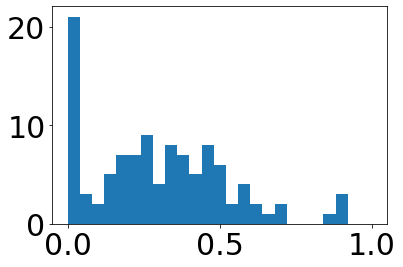

In [34]:
plt.hist(bestaks,range=(0,1.),bins=25)
print(np.median(bestaks))

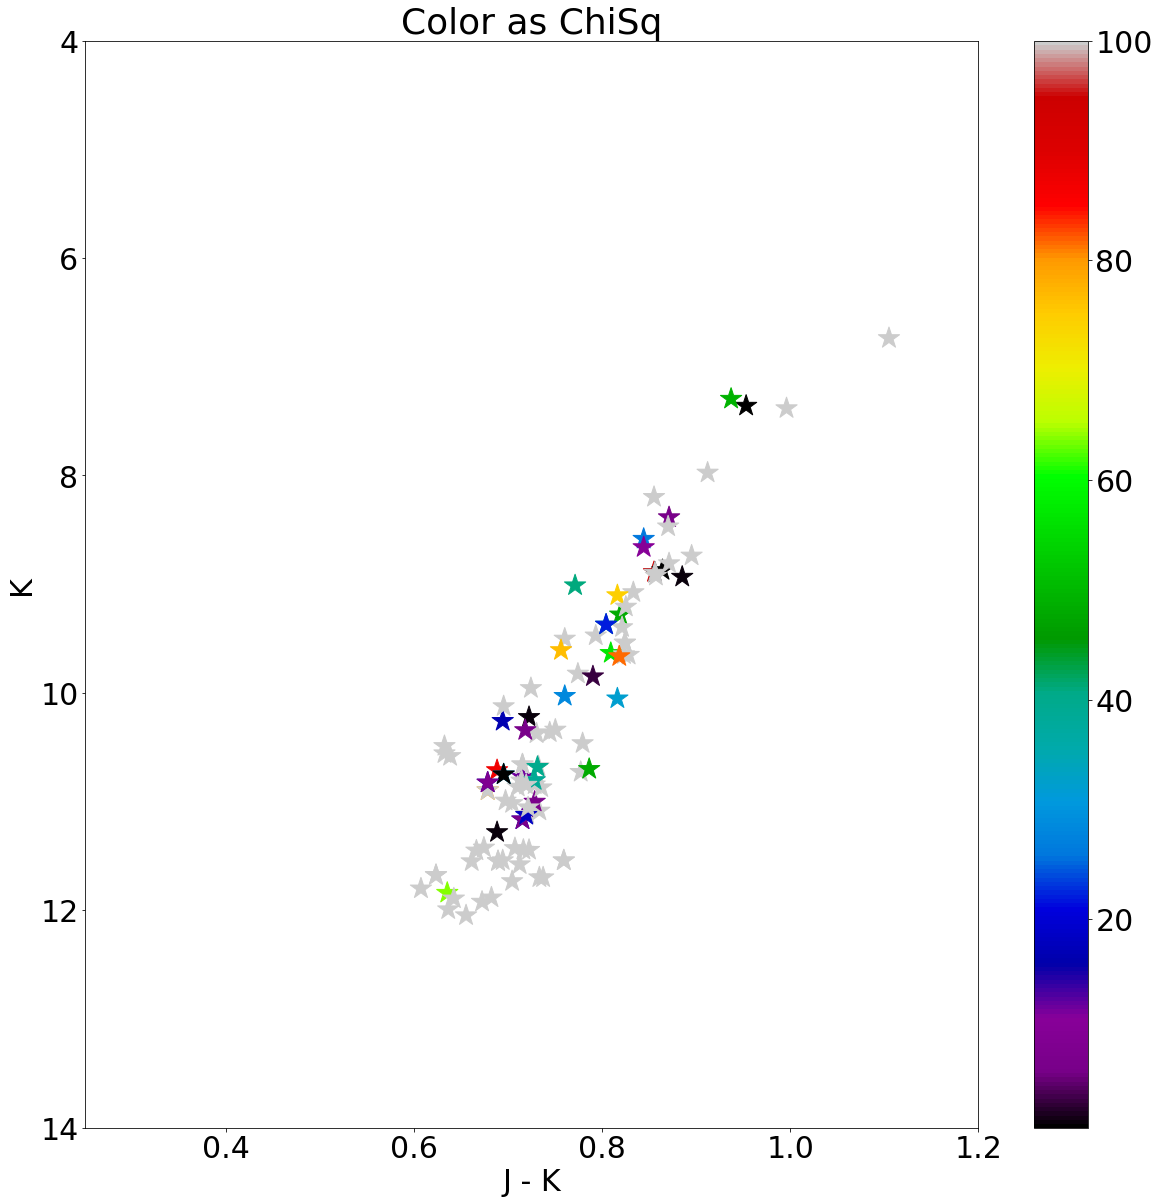

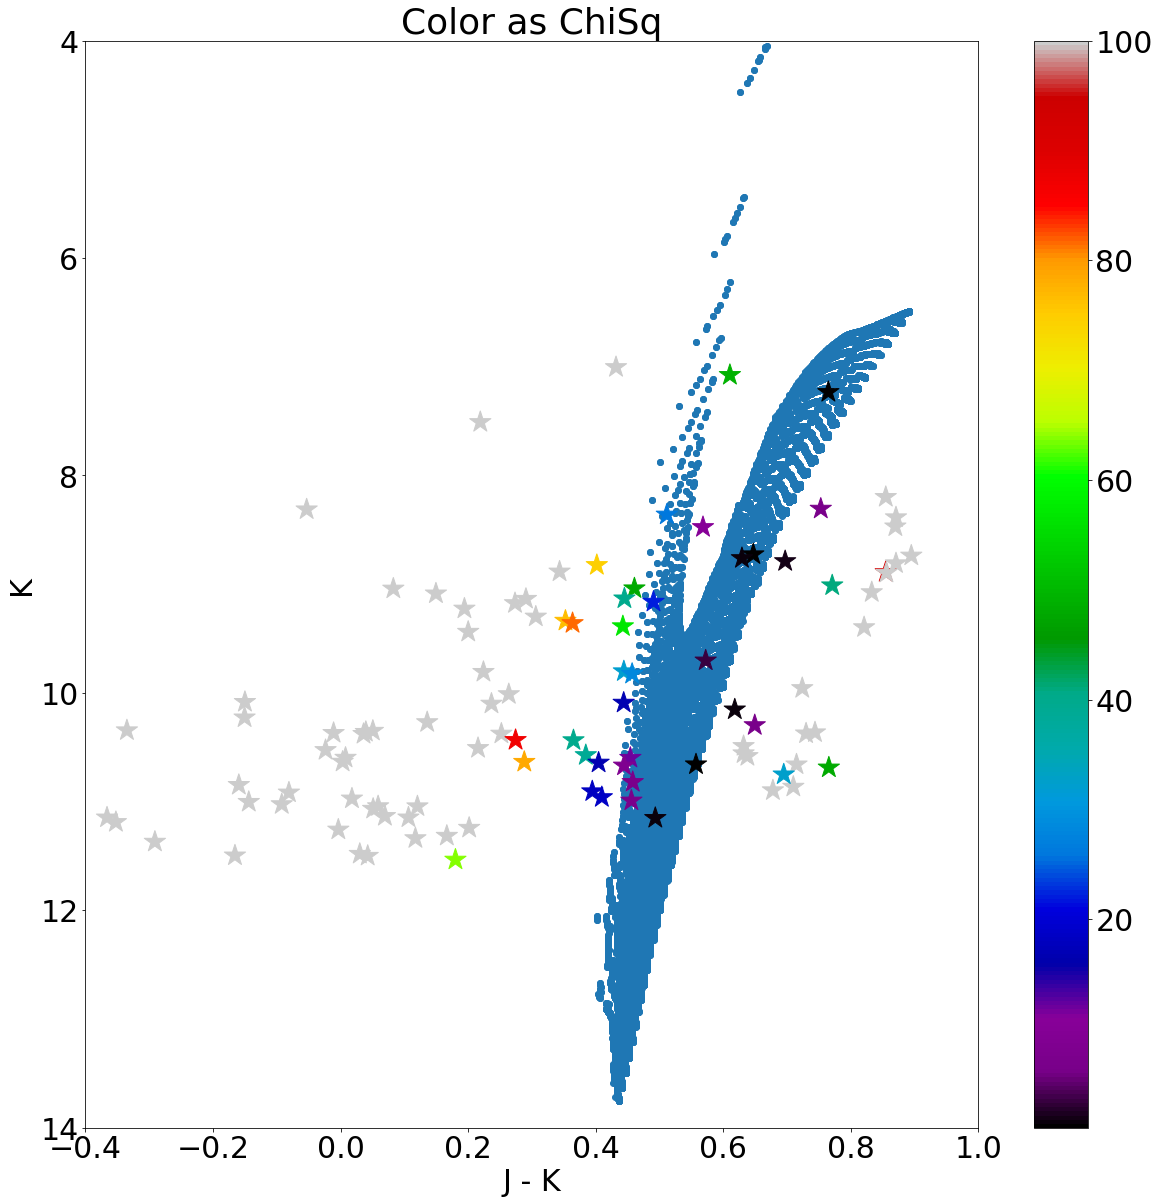

In [44]:
### Without Isochrones
plt.figure(figsize=[20,20])
plt.scatter((gcs['J']-gcs['K'])[m22_idx],gcs['K'][m22_idx],c=bestchis,cmap='nipy_spectral',vmax=100,marker='*',
            s=500)
plt.colorbar()
plt.gca().invert_yaxis()
plt.title(r'Color as ChiSq')
plt.ylabel(r'K')
plt.xlabel(r'J - K')
plt.ylim(14,4)
plt.xlim(0.25,1.2)
plt.show()

### With Isochrones
plt.figure(figsize=[20,20])
plt.scatter((massive['Jmag']-massive['Ksmag'])[m22iso],
            massive['Ksmag'][m22iso]+5*np.log10(gcs_dist[m22_idx][0])-5.0)
plt.scatter((gcs['J']-gcs['K'])[m22_idx]-ejk_ak*np.asarray(bestaks),gcs['K'][m22_idx]-bestaks,c=bestchis,cmap='nipy_spectral',vmax=100,
            marker='*',s=500)
plt.colorbar()
plt.gca().invert_yaxis()
plt.title(r'Color as ChiSq')
plt.ylabel(r'K')
plt.xlabel(r'J - K')
plt.ylim(14,4)
plt.xlim(-0.4,1.0)
plt.show()

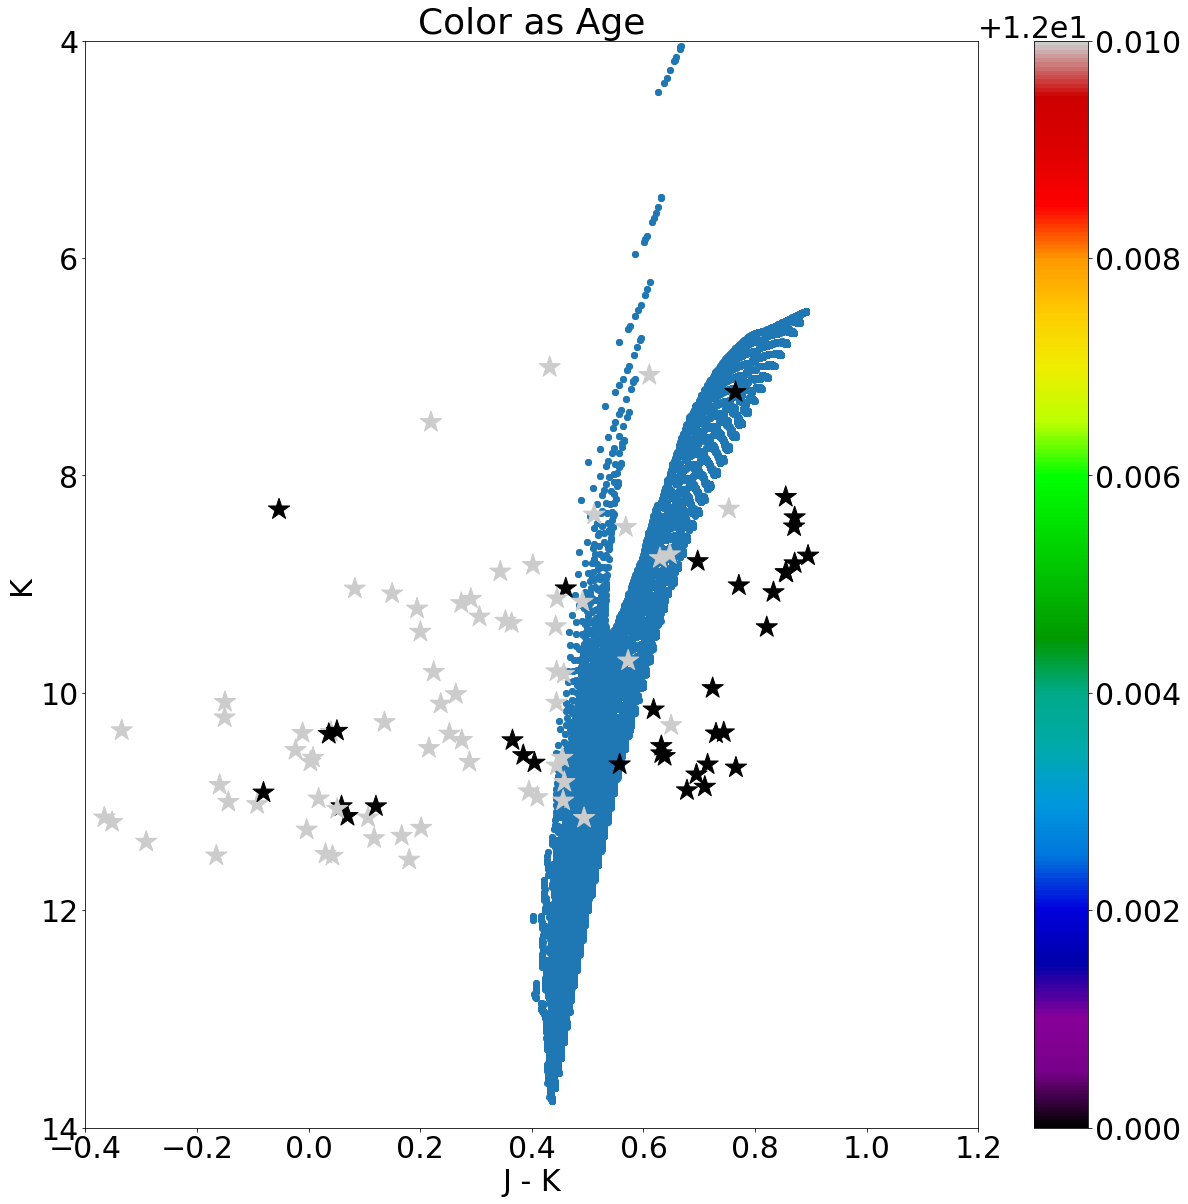

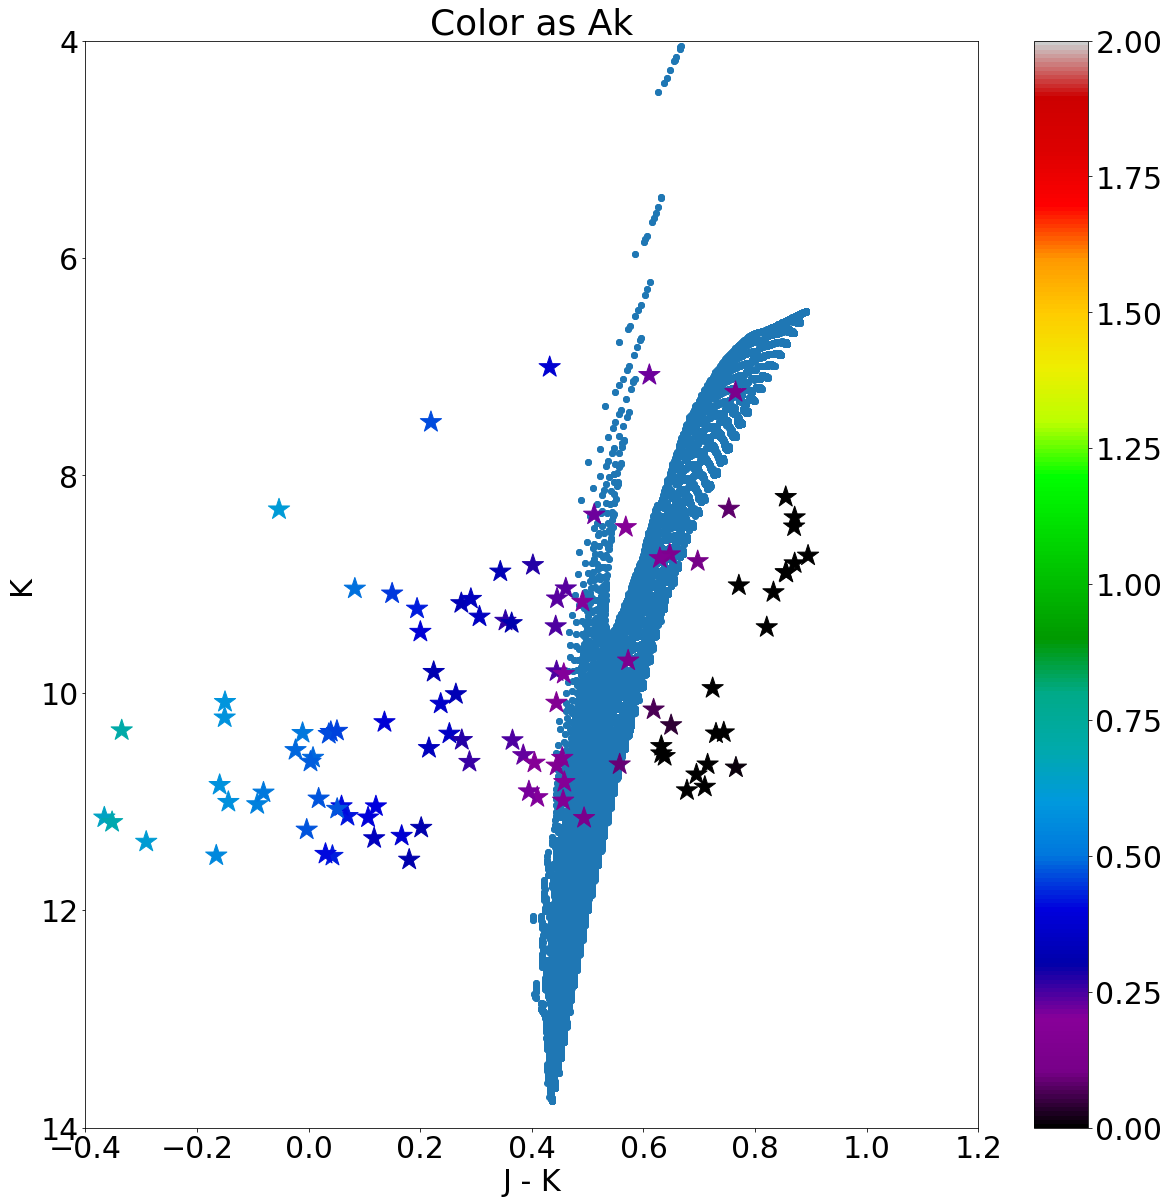

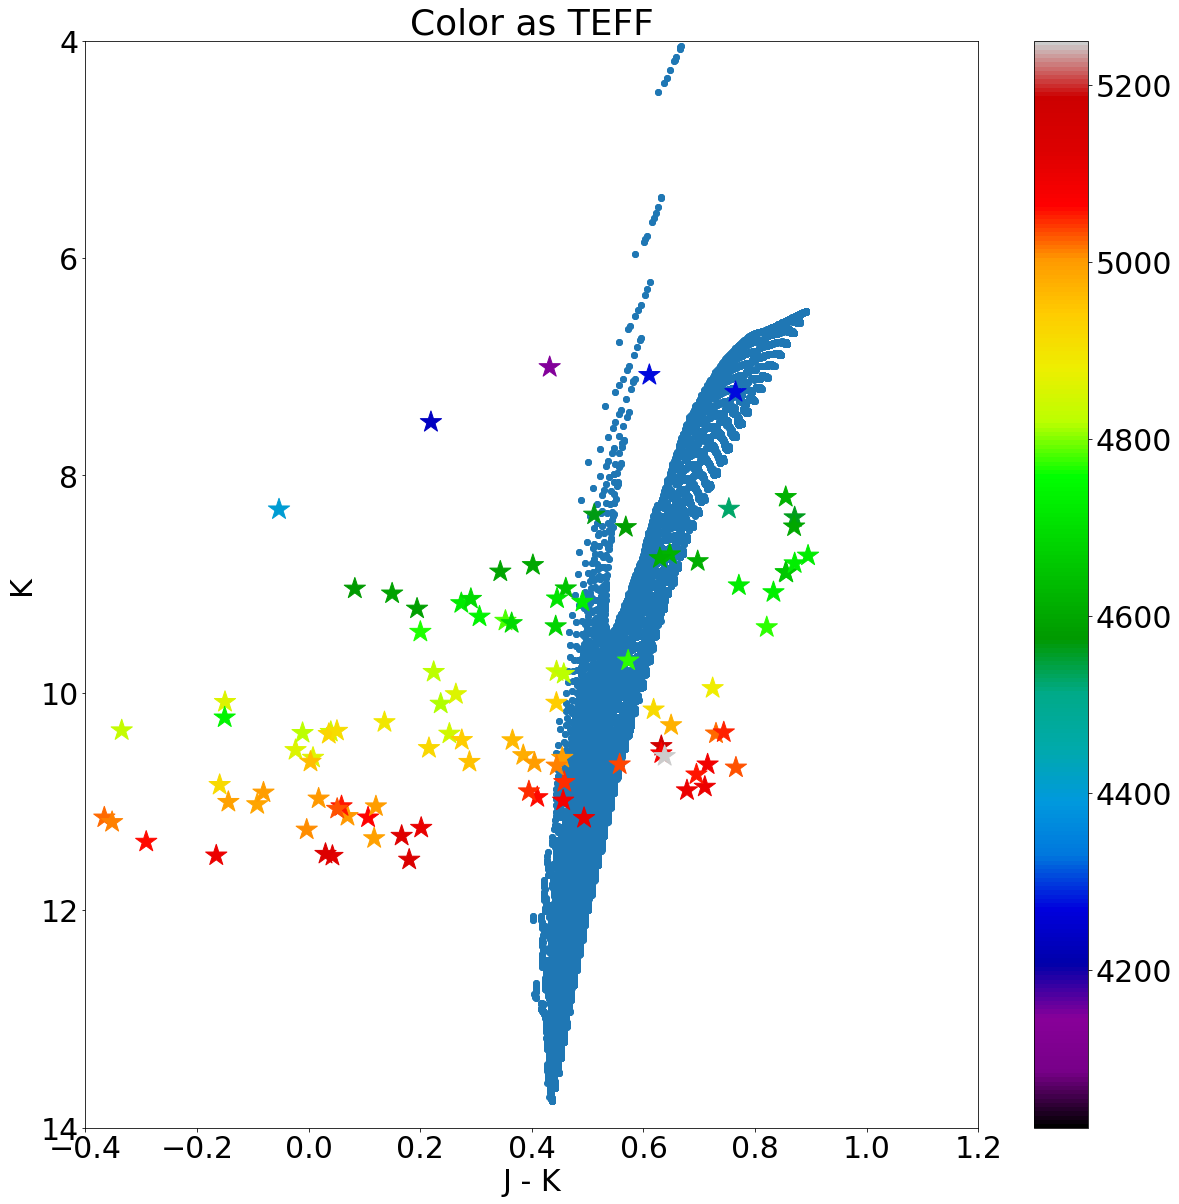

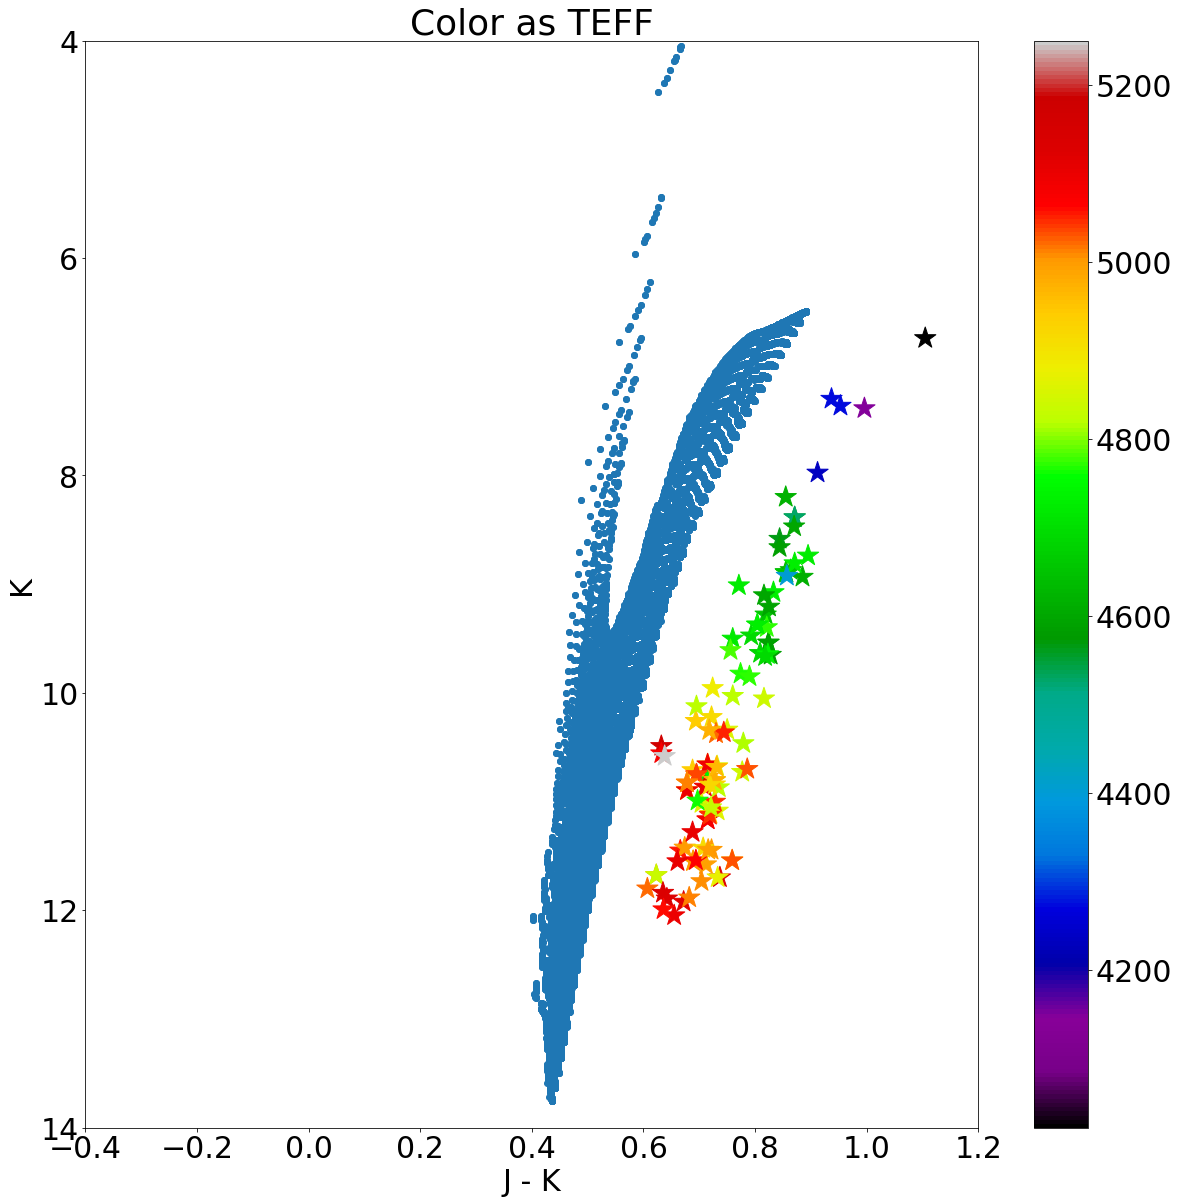

In [45]:
### Age
plt.figure(figsize=[20,20])
plt.scatter((massive['Jmag']-massive['Ksmag'])[m22iso],
            massive['Ksmag'][m22iso]+5*np.log10(gcs_dist[m22_idx][0])-5.0)
plt.scatter((gcs['J']-gcs['K'])[m22_idx]-ejk_ak*np.asarray(bestaks),gcs['K'][m22_idx]-bestaks,c=bestages,
            cmap='nipy_spectral',vmax=12.01,
            marker='*',s=500)
plt.colorbar()
plt.gca().invert_yaxis()
plt.title(r'Color as Age')
plt.ylabel(r'K')
plt.xlabel(r'J - K')
plt.ylim(14,4)
plt.xlim(-0.4,1.2)
plt.show()

### Aks
plt.figure(figsize=[20,20])
plt.scatter((massive['Jmag']-massive['Ksmag'])[m22iso],
            massive['Ksmag'][m22iso]+5*np.log10(gcs_dist[m22_idx][0])-5.0)
plt.scatter((gcs['J']-gcs['K'])[m22_idx]-ejk_ak*np.asarray(bestaks),gcs['K'][m22_idx]-bestaks,c=bestaks,
            cmap='nipy_spectral',
            marker='*',s=500,vmax=2.0)
plt.colorbar()
plt.gca().invert_yaxis()
plt.title(r'Color as Ak')
plt.ylabel(r'K')
plt.xlabel(r'J - K')
plt.ylim(14,4)
plt.xlim(-0.4,1.2)
plt.show()

### TEFF
plt.figure(figsize=[20,20])
plt.scatter((massive['Jmag']-massive['Ksmag'])[m22iso],
            massive['Ksmag'][m22iso]+5*np.log10(gcs_dist[m22_idx][0])-5.0)
plt.scatter((gcs['J']-gcs['K'])[m22_idx]-ejk_ak*np.asarray(bestaks),gcs['K'][m22_idx]-bestaks,c=gcs['TEFF'][m22_idx],
            cmap='nipy_spectral',
            marker='*',s=500)
plt.colorbar()
plt.gca().invert_yaxis()
plt.title(r'Color as TEFF')
plt.ylabel(r'K')
plt.xlabel(r'J - K')
plt.ylim(14,4)
plt.xlim(-0.4,1.2)
plt.show()

plt.figure(figsize=[20,20])
plt.scatter((massive['Jmag']-massive['Ksmag'])[m22iso],
            massive['Ksmag'][m22iso]+5*np.log10(gcs_dist[m22_idx][0])-5.0)
plt.scatter((gcs['J']-gcs['K'])[m22_idx],gcs['K'][m22_idx],c=gcs['TEFF'][m22_idx],
            cmap='nipy_spectral',
            marker='*',s=500)
plt.colorbar()
plt.gca().invert_yaxis()
plt.title(r'Color as TEFF')
plt.ylabel(r'K')
plt.xlabel(r'J - K')
plt.ylim(14,4)
plt.xlim(-0.4,1.2)
plt.show()

In [46]:
print(gcs['AK_TARG'][m22_idx])

 AK_TARG  
----------
0.16064948
0.15514188
0.15514188
0.15147014
0.11934028
0.11934028
0.18176326
0.13586396
0.20746802
0.16156785
       ...
0.11475018
0.20104204
0.19094434
0.16156785
0.13219222
0.17533816
0.17533816
0.10465159
 0.2469422
0.13494647
 0.2423521
Length = 108 rows


0.16110867


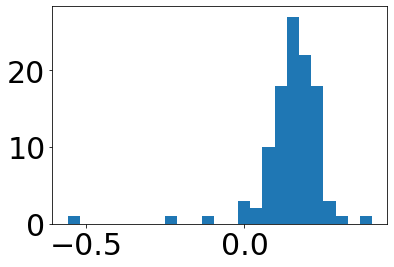

In [47]:
plt.hist(gcs[m22_idx]['AK_TARG'],bins=25)
print(np.median(gcs[m22_idx]['AK_TARG']))

In [48]:
# age-mag diagnostic few stars
# try redo fititng with rv 3.6
# include gaia bands

In [49]:
gcs_dist[m22_idx]

array([3200., 3200., 3200., 3200., 3200., 3200., 3200., 3200., 3200.,
       3200., 3200., 3200., 3200., 3200., 3200., 3200., 3200., 3200.,
       3200., 3200., 3200., 3200., 3200., 3200., 3200., 3200., 3200.,
       3200., 3200., 3200., 3200., 3200., 3200., 3200., 3200., 3200.,
       3200., 3200., 3200., 3200., 3200., 3200., 3200., 3200., 3200.,
       3200., 3200., 3200., 3200., 3200., 3200., 3200., 3200., 3200.,
       3200., 3200., 3200., 3200., 3200., 3200., 3200., 3200., 3200.,
       3200., 3200., 3200., 3200., 3200., 3200., 3200., 3200., 3200.,
       3200., 3200., 3200., 3200., 3200., 3200., 3200., 3200., 3200.,
       3200., 3200., 3200., 3200., 3200., 3200., 3200., 3200., 3200.,
       3200., 3200., 3200., 3200., 3200., 3200., 3200., 3200., 3200.,
       3200., 3200., 3200., 3200., 3200., 3200., 3200., 3200., 3200.])

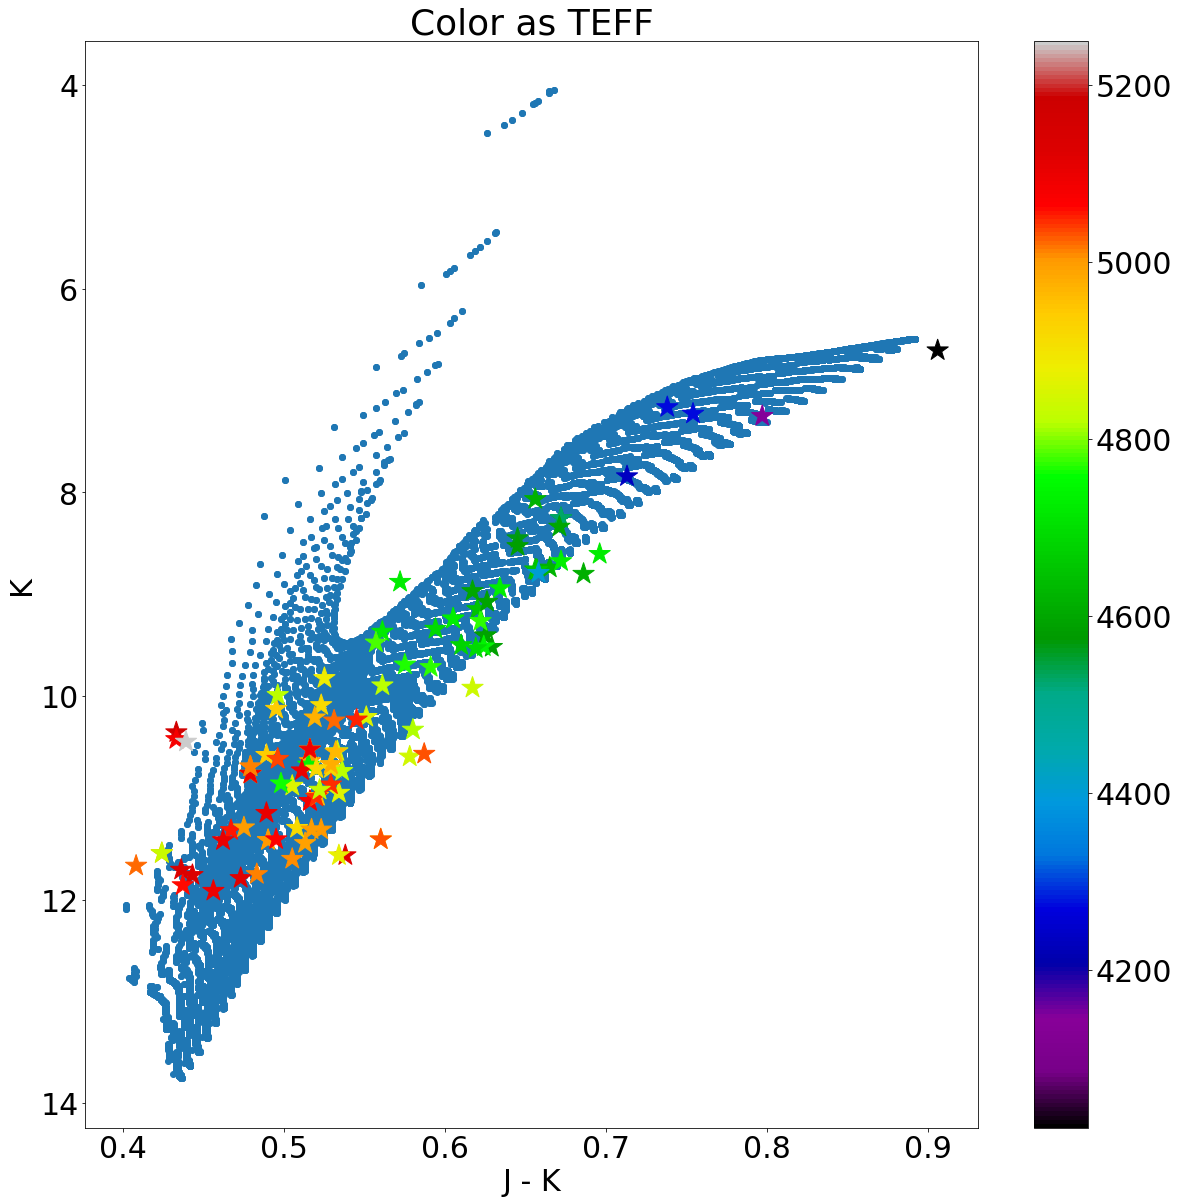

In [50]:
#E(J-K) = .28
#ak = .18

ak_test = 0.1325
ejk_test = 1.5*ak_test

plt.figure(figsize=[20,20])
plt.scatter((massive['Jmag']-massive['Ksmag'])[m22iso],
            massive['Ksmag'][m22iso]+5*np.log10(gcs_dist[m22_idx][0])-5.0)
plt.scatter((gcs['J']-gcs['K'])[m22_idx]-ejk_test,gcs['K'][m22_idx]-ak_test,c=gcs['TEFF'][m22_idx],
            cmap='nipy_spectral',
            marker='*',s=500)
plt.colorbar()
plt.gca().invert_yaxis()
plt.title(r'Color as TEFF')
plt.ylabel(r'K')
plt.xlabel(r'J - K')
plt.show()

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 107.,   0.]),
 array([ 0. ,  1.4,  2.8,  4.2,  5.6,  7. ,  8.4,  9.8, 11.2, 12.6, 14. ]),
 <a list of 10 Patch objects>)

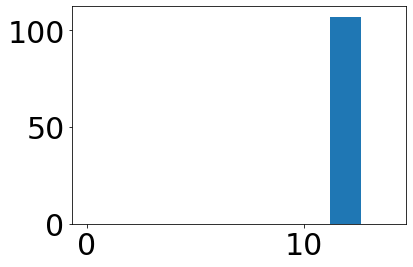

In [52]:
plt.hist(bestages,range=(0,14))

0.4341440994449493


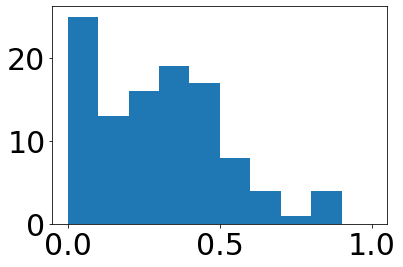

In [56]:
plt.hist(bestaks,range=(0,1))
print(np.median(bestaks)*ejk_ak)

In [57]:
#harris E(B-V) = 0.34

(0.34*(cardelli_alav(leff['J'],3.1)-cardelli_alav(leff['K'],3.1))/
 (cardelli_alav(0.445,3.1)-cardelli_alav(0.551,3.1)))

0.18928887563095959

In [58]:
ejk_ak

1.4901972382364816

In [59]:
(cardelli_alav(leff['J'],3.1)-cardelli_alav(leff['K'],3.1))/(cardelli_alav(0.445,3.1)-cardelli_alav(0.551,3.1))

0.556731987149881

In [60]:
0.3806570847132866/0.18928887563095959

2.0109849743913175

In [209]:
# idx = m22star
# theo_mags = []
# CalcAge = WhatsMyAgeAgain(gcs['M_H'][idx],gcs['ALPHA_M'][idx],gcs_dist[idx],massive)
# for i in range(0,14):
#     theo_mags.append(CalcAge.Teff2AppMags(gcs['TEFF'][idx],i,ak[np.where(chi==np.min(chi))]))
    
# # print(theo_mags)

# testmag = CalcAge.Teff2AppMags(gcs['TEFF'][idx],1.59001318,0.051967578556212986)
# print(testmag)
# print(gcs['J'][m22star])
# print(gcs['H'][m22star])
# print(gcs['K'][m22star])

In [213]:
# # run with age
# CalcAge.Teff2AppMags(gcs['TEFF'][idx],1.59001318,0)

In [33]:
aj_ak = cardelli_alav(leff['J'],3.1)/cardelli_alav(leff['K'],3.1)
ah_ak = cardelli_alav(leff['H'],3.1)/cardelli_alav(leff['K'],3.1)

exts = np.array([aj_ak,ah_ak,1.0])*ak[np.where(chi==np.min(chi))]
exts

array([0.1294095 , 0.08197223, 0.05196757])

In [267]:
theo_mags = []
CalcAge = WhatsMyAgeAgain(gcs['M_H'][m22star],gcs['ALPHA_M'][m22star],gcs_dist[m22star],massive)
for i in np.arange(0,15,0.25):
    theo_mags.append(CalcAge.Teff2AppMags(gcs['TEFF'][m22star],i,curve_ak))

Input [Age, Ak]:  [0.0, 0.8496309455302625]
[lgage_lo,lgage_hi]:  [7.397939999999999, 7.69897]
[J,H,K]:  [999999. 999999. 999999.]
Input [Age, Ak]:  [0.25, 0.8496309455302625]
[lgage_lo,lgage_hi]:  [8.39794, 8.43933]
[J,H,K]:  [999999. 999999. 999999.]
Input [Age, Ak]:  [0.5, 0.8496309455302625]
[lgage_lo,lgage_hi]:  [8.69897, 8.72016]
[J,H,K]:  [999999. 999999. 999999.]
Input [Age, Ak]:  [0.75, 0.8496309455302625]
[lgage_lo,lgage_hi]:  [8.875060000000001, 8.8893]
[J,H,K]:  [999999. 999999. 999999.]
Input [Age, Ak]:  [1.0, 0.8496309455302625]
[J,H,K]:  [999999. 999999. 999999.]
Input [Age, Ak]:  [1.25, 0.8496309455302625]
[lgage_lo,lgage_hi]:  [9.096910000000001, 9.10551]
[J,H,K]:  [999999. 999999. 999999.]
Input [Age, Ak]:  [1.5, 0.8496309455302625]
[lgage_lo,lgage_hi]:  [9.17609, 9.18327]
[J,H,K]:  [11.07242535  9.75976336  9.188403  ]
Input [Age, Ak]:  [1.75, 0.8496309455302625]
[lgage_lo,lgage_hi]:  [9.243039999999999, 9.2492]
[J,H,K]:  [11.1596983   9.84611278  9.27478351]
Input [

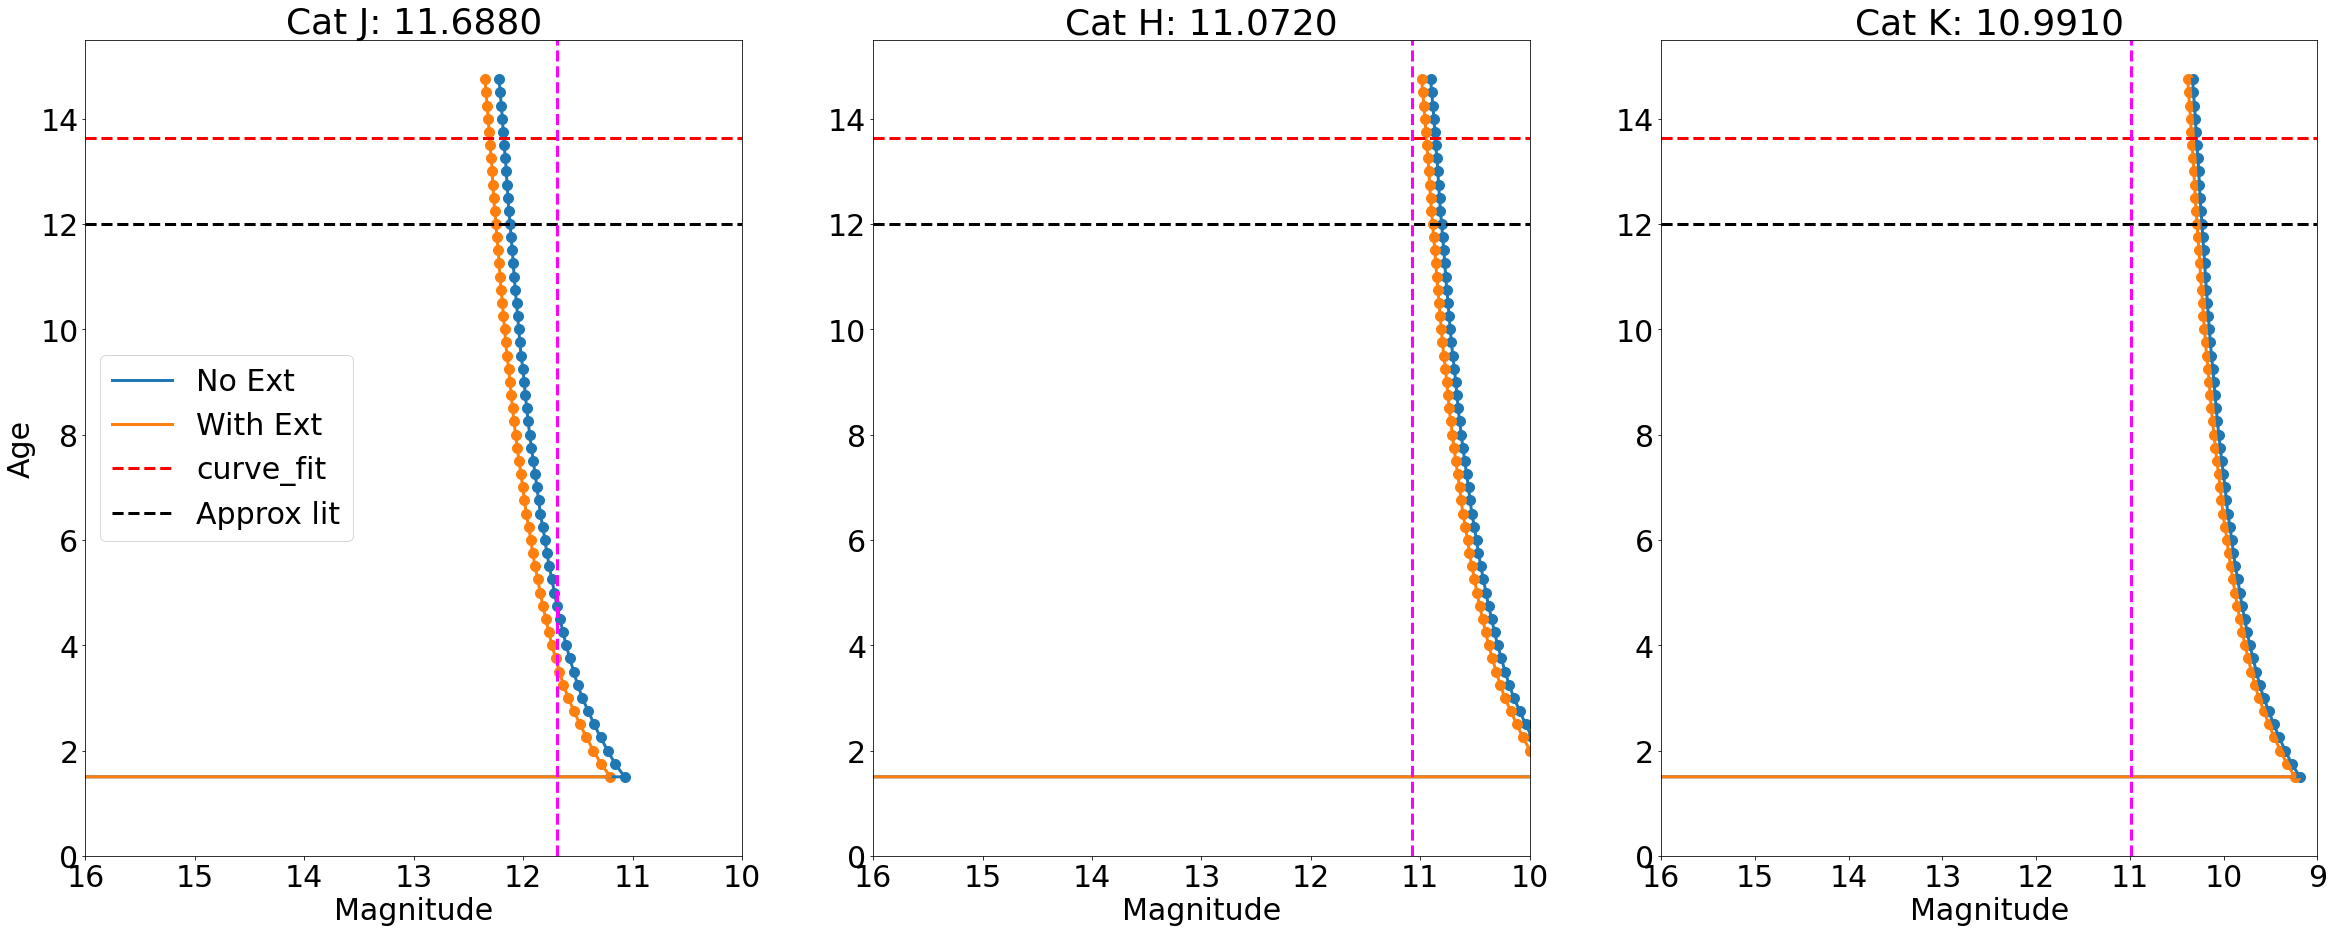

In [270]:
bands = ['J','H','K']
catalog_mags = [gcs[m22star]['J'][0],gcs[m22star]['H'][0],gcs[m22star]['K'][0]]
fig, ax = plt.subplots(1,3,figsize=[40,15])
for i in range(3):
    ax[i].scatter(np.asarray(theo_mags)[:,i],np.arange(0,15,0.25),s=100)
    ax[i].plot(np.asarray(theo_mags)[:,i],np.arange(0,15.,0.25),lw=3.0,label='No Ext')
    ax[i].scatter(np.asarray(theo_mags)[:,i]+exts[i],np.arange(0,15,0.25),s=100)
    ax[i].plot(np.asarray(theo_mags)[:,i]+exts[i],np.arange(0,15,0.25),lw=3.0,label='With Ext')
    ax[i].set_ylim(bottom=0)
    ax[i].axhline(curve_age,c='r',ls='--',label='curve_fit',lw=3.0)
    ax[i].axhline(12,c='k',ls='--',label='Approx lit',lw=3.0)
    ax[i].set_xlabel('Magnitude')
    ax[i].set_title(r'Cat {}: {:.4f}'.format(bands[i],catalog_mags[i]))

ax[0].axvline(catalog_mags[0],ls='--',c='magenta',lw=3.0)
ax[1].axvline(catalog_mags[1],ls='--',c='magenta',lw=3.0)
ax[2].axvline(catalog_mags[2],ls='--',c='magenta',lw=3.0)

# ax[0].set_xlim(12.5,10.)
# ax[1].set_xlim(12,9.0)
# ax[2].set_xlim(12,8.25)

ax[0].set_xlim(16,10)
ax[1].set_xlim(16,10)
ax[2].set_xlim(16,9)

ax[0].legend()

ax[0].set_ylabel('Age')
plt.show()

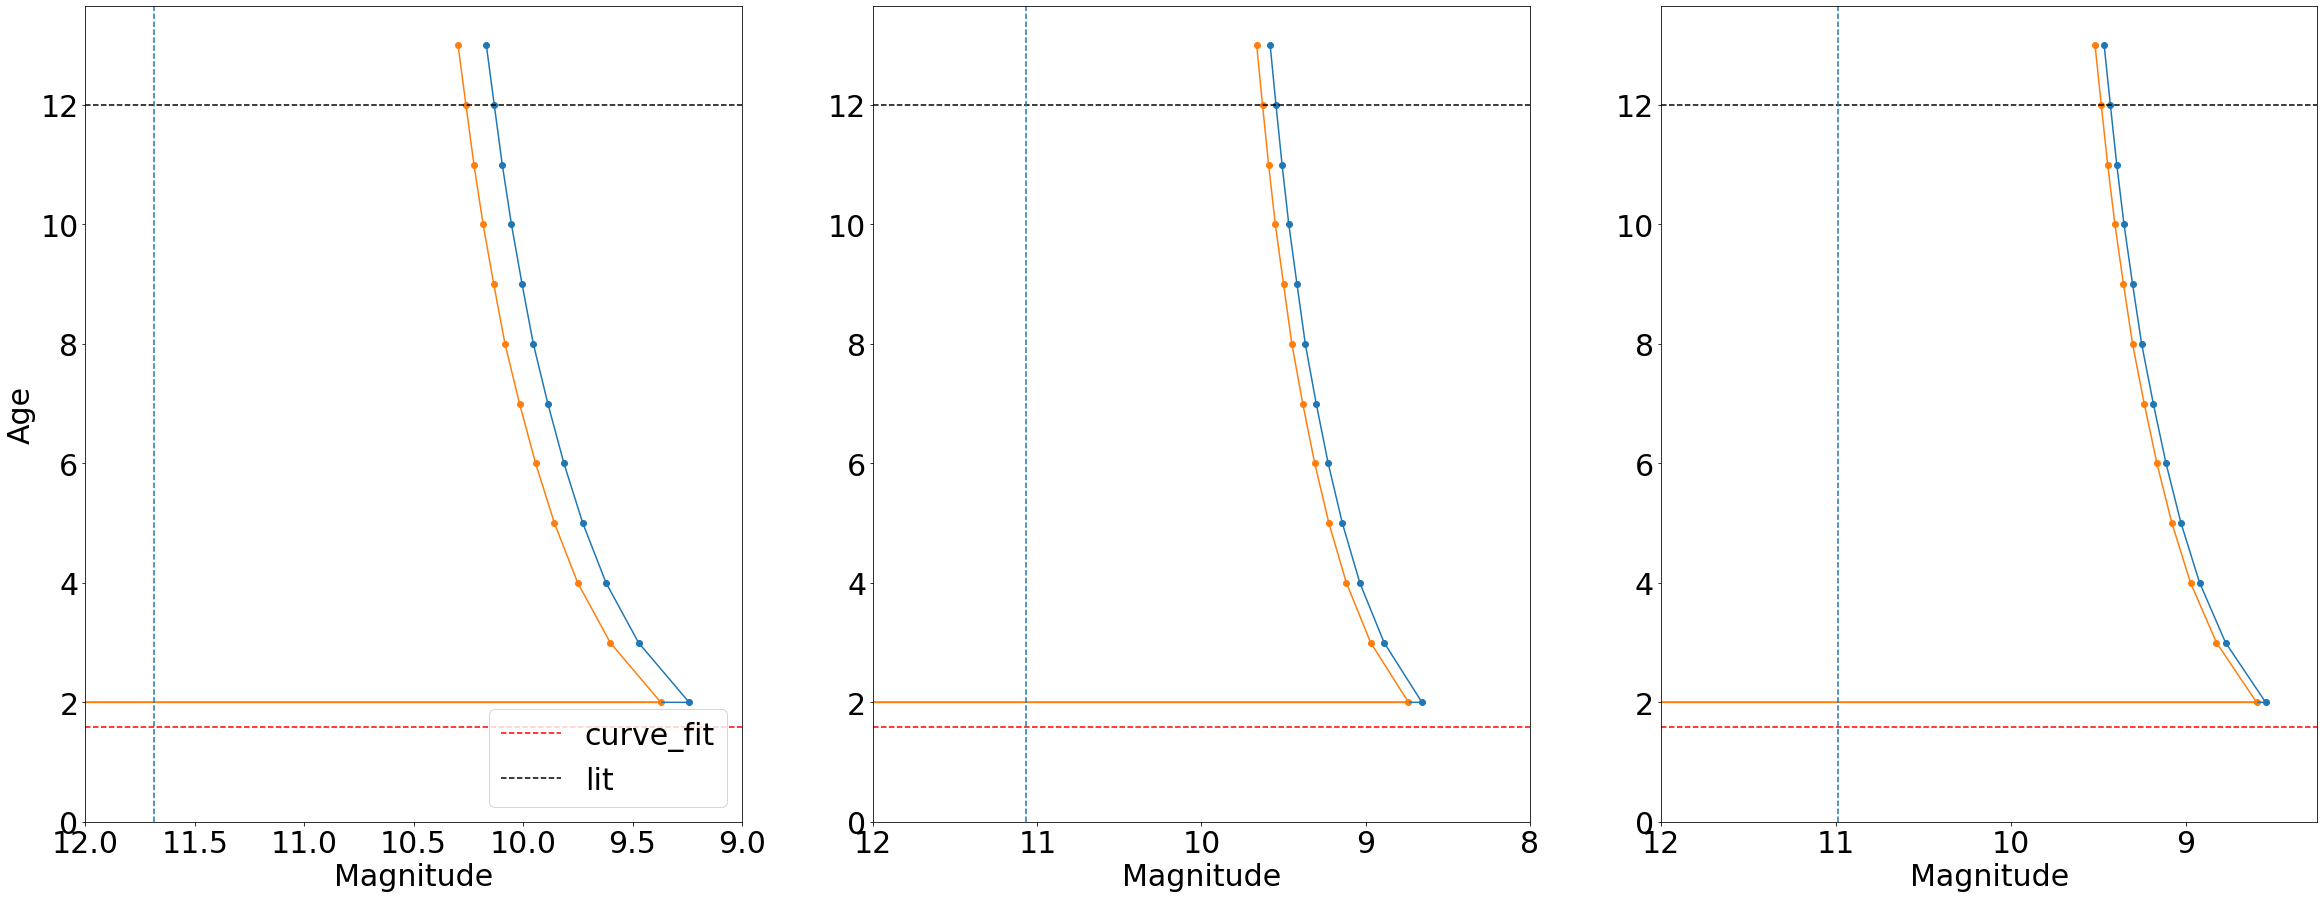

In [83]:
fig, ax = plt.subplots(1,3,figsize=[40,15])
for i in range(3):
    ax[i].scatter(np.asarray(theo_mags)[:,i],range(0,14))
    ax[i].plot(np.asarray(theo_mags)[:,i],range(0,14))
    ax[i].scatter(np.asarray(theo_mags)[:,i]+exts[i],range(0,14))
    ax[i].plot(np.asarray(theo_mags)[:,i]+exts[i],range(0,14))
    ax[i].set_ylim(bottom=0)
    ax[i].axhline(age[np.where(chi==np.min(chi))],c='r',ls='--',label='curve_fit')
    ax[i].axhline(12,c='k',ls='--',label='lit')
    ax[i].set_xlabel('Magnitude')

ax[0].axvline(gcs[idx]['J'][0],ls='--',c='tab:blue')
ax[1].axvline(gcs[idx]['H'][0],ls='--',c='tab:blue')
ax[2].axvline(gcs[idx]['K'][0],ls='--',c='tab:blue')

ax[0].set_xlim(12,9.0)
ax[1].set_xlim(12,8.0)
ax[2].set_xlim(12,8.25)

ax[0].legend()

ax[0].set_ylabel('Age')
plt.show()

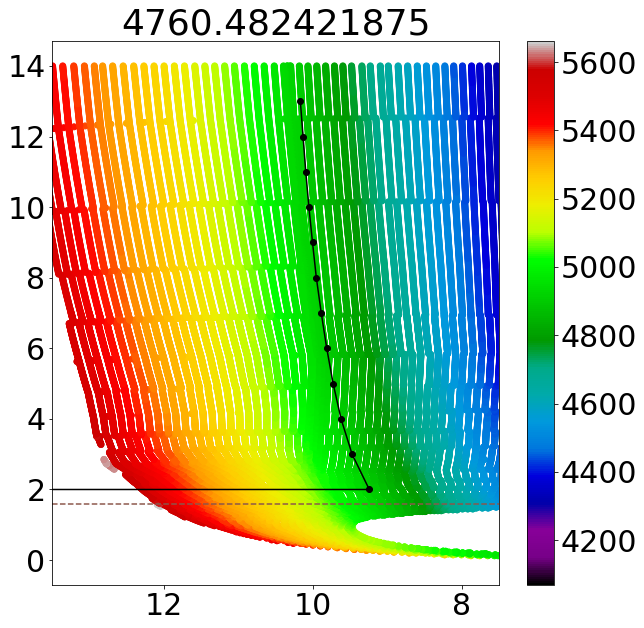

In [109]:
plt.figure(figsize=[10,10])
plt.scatter(massive['Ksmag'][isopick]+5.0*np.log10(gcs_dist[m22star])-5.0,10**massive['logAge'][isopick]/10**9,
            c=10**massive['logTe'][isopick],cmap="nipy_spectral")
plt.colorbar()
plt.plot(np.asarray(theo_mags)[:,0],range(0,14),'o-',c='black')
plt.gca().invert_xaxis()
plt.xlim(13.5,7.5)
plt.axhline(age[np.where(chi==np.min(chi))],c='tab:brown',ls='--',label='curve_fit')
plt.title(r'{}'.format(gcs[idx]['TEFF'][0]));

In [128]:
curvefitage = age[np.where(chi==np.min(chi))][0]
curvefitiso, = np.where((massive['MH']==closest(massive['MH'],np.nanmedian(gcs['M_H'][m22star])+
                                              np.log10(0.638*(10**np.nanmedian(gcs['ALPHA_M'][m22star]))+0.362)))&
                    (massive['logAge']==closest(massive['logAge'],np.log10(curvefitage*10**9))))

twgyr, = np.where((massive['MH']==closest(massive['MH'],np.nanmedian(gcs['M_H'][m22star])+
                                              np.log10(0.638*(10**np.nanmedian(gcs['ALPHA_M'][m22star]))+0.362)))&
                    (massive['logAge']==closest(massive['logAge'],np.log10(12*10**9))))

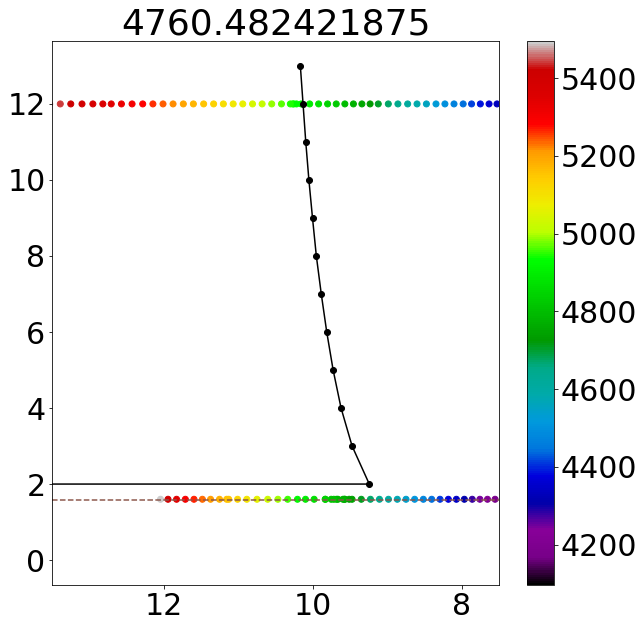

In [129]:
plt.figure(figsize=[10,10])

plt.scatter(massive['Ksmag'][curvefitiso]+5.0*np.log10(gcs_dist[m22star])-5.0,
            10**massive['logAge'][curvefitiso]/10**9,
            c=10**massive['logTe'][curvefitiso],cmap="nipy_spectral")

plt.scatter(massive['Ksmag'][twgyr]+5.0*np.log10(gcs_dist[m22star])-5.0,
            10**massive['logAge'][twgyr]/10**9,
            c=10**massive['logTe'][twgyr],cmap="nipy_spectral")

plt.colorbar()
plt.plot(np.asarray(theo_mags)[:,0],range(0,14),'o-',c='black')
plt.gca().invert_xaxis()
plt.xlim(13.5,7.5)
plt.axhline(age[np.where(chi==np.min(chi))],c='tab:brown',ls='--',label='curve_fit')
plt.title(r'{}'.format(gcs[idx]['TEFF'][0]));

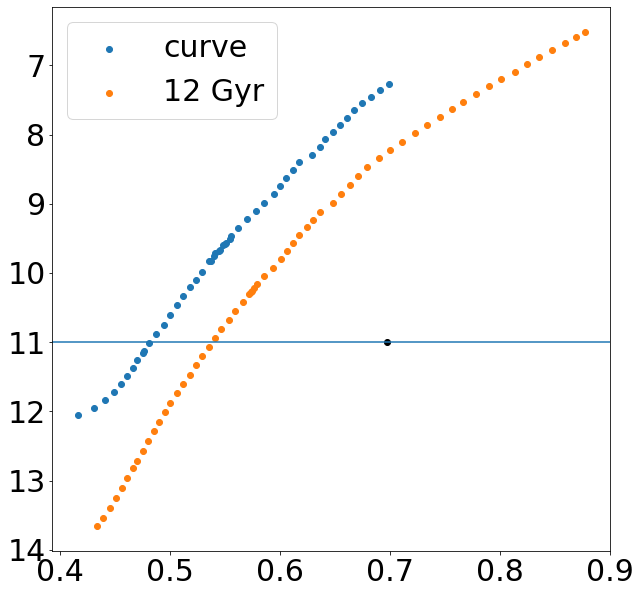

In [162]:
plt.figure(figsize=[10,10])
plt.scatter((massive['Jmag']-massive['Ksmag'])[curvefitiso],
            massive[curvefitiso]['Ksmag']+5.0*np.log10(gcs_dist[m22star])-5.0,label='curve')
plt.scatter((massive['Jmag']-massive['Ksmag'])[twgyr],
            massive[twgyr]['Ksmag']+5.0*np.log10(gcs_dist[m22star])-5.0,label='12 Gyr')
plt.legend()
plt.scatter((gcs['J']-gcs['K'])[m22star],gcs['K'][m22star],c='k')
plt.axhline(gcs['K'][m22star])
plt.gca().invert_yaxis()

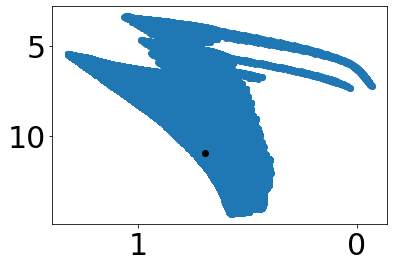

In [133]:
plt.scatter(massive['Jmag']-massive['Ksmag'],massive['Ksmag']+5.0*np.log10(gcs_dist[m22star])-5.0,label='curve')
plt.scatter((gcs['J']-gcs['K'])[m22star],gcs['K'][m22star],c='k')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

# Multiple Bad Stars Age-Mag Plot

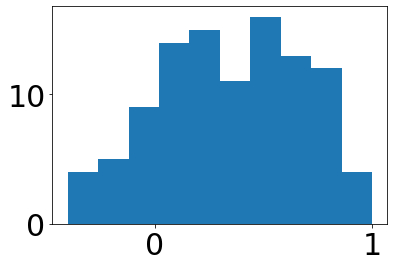

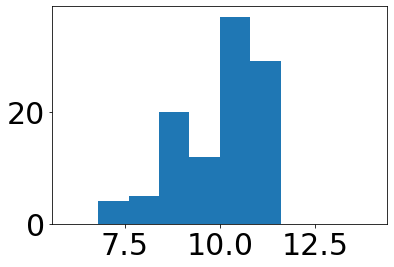

In [73]:
plt.hist(badcolors,range=(-0.4,1.0))
plt.show()

plt.hist(badmags,range=(6,14))
plt.show()

In [85]:
def euclid2d(arr,pt):
    ptx,pty=pt
    arrx,arry=arr
    arrx = arrx.data
    arry = arry.data
    euc = np.subtract(arrx,ptx)**2+np.subtract(arry,pty)**2
    return euc

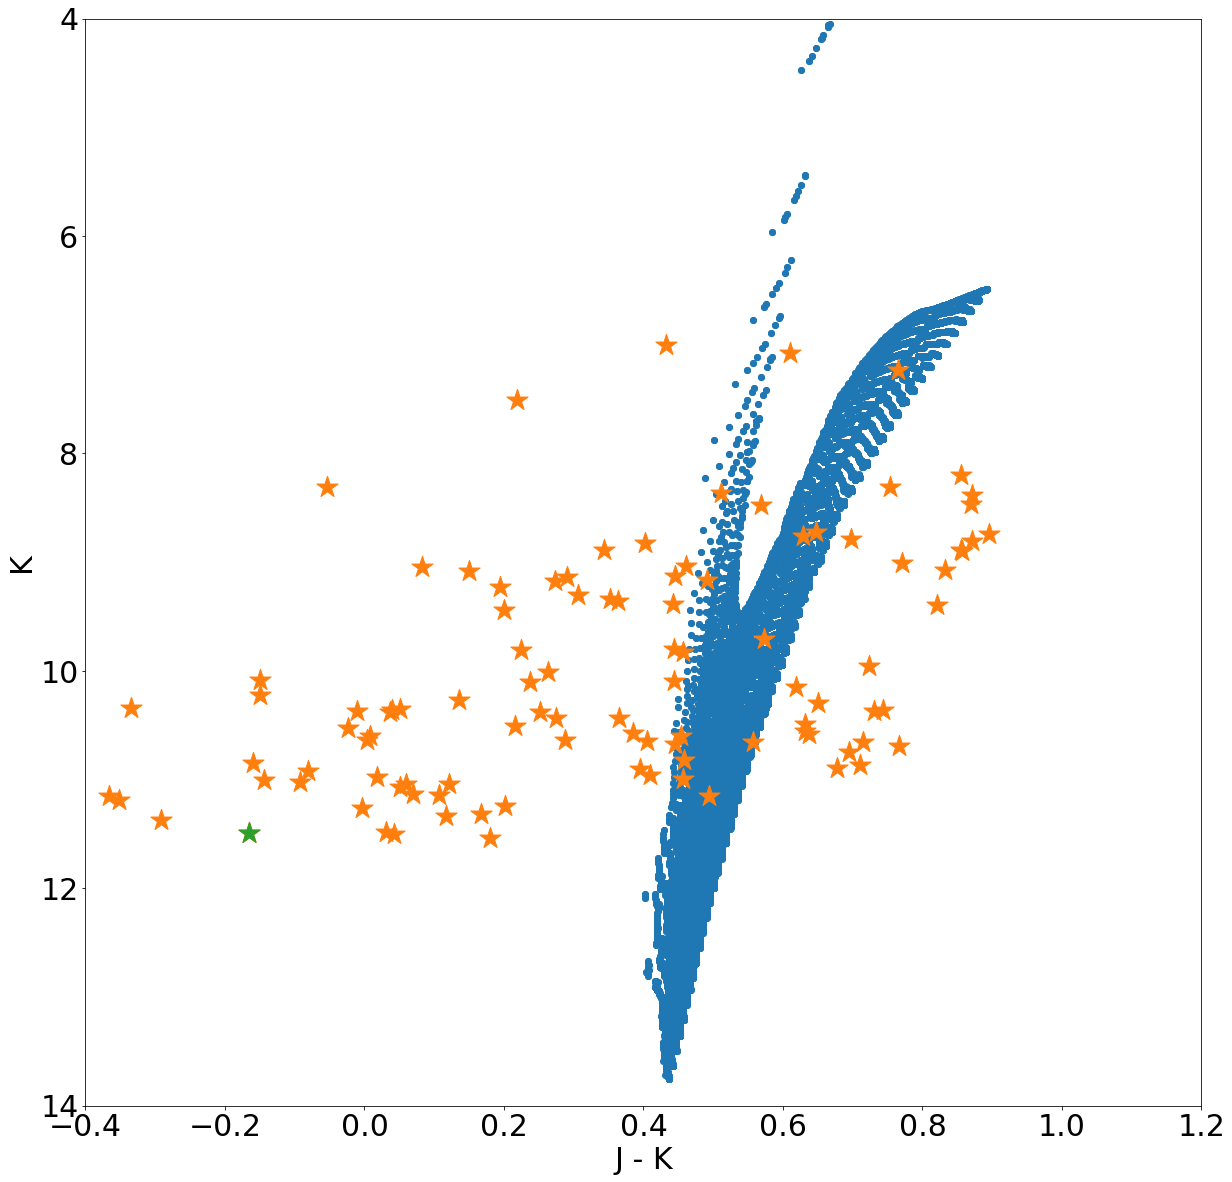

In [176]:
badcolors = (gcs['J']-gcs['K'])[m22_idx]-ejk_ak*np.asarray(bestaks)
badmags = gcs['K'][m22_idx]-bestaks

bad1 = euclid2d([badcolors,badmags],[-0.1,8.0]).argmin()
bad2 = euclid2d([badcolors,badmags],[0.2,9.0]).argmin()
bad3 = euclid2d([badcolors,badmags],[-0.3,12.0]).argmin()
bad4 = euclid2d([badcolors,badmags],[0.3,7.0]).argmin()
bad5 = euclid2d([badcolors,badmags],[0.8,10.0]).argmin()

plt.figure(figsize=[20,20])
plt.scatter((massive['Jmag']-massive['Ksmag'])[m22iso],
            massive['Ksmag'][m22iso]+5*np.log10(gcs_dist[m22_idx][0])-5.0)
plt.scatter((gcs['J']-gcs['K'])[m22_idx]-ejk_ak*np.asarray(bestaks),gcs['K'][m22_idx]-bestaks,marker='*',s=500)
# plt.scatter(((gcs['J']-gcs['K'])[m22_idx]-ejk_ak*np.asarray(bestaks))[bad1],(gcs['K'][m22_idx]-bestaks)[bad1],
#             marker='*',s=500,c='tab:green')
# plt.scatter(((gcs['J']-gcs['K'])[m22_idx]-ejk_ak*np.asarray(bestaks))[bad2],(gcs['K'][m22_idx]-bestaks)[bad2],
#             marker='*',s=500,c='tab:green')
plt.scatter(((gcs['J']-gcs['K'])[m22_idx]-ejk_ak*np.asarray(bestaks))[bad3],(gcs['K'][m22_idx]-bestaks)[bad3],
            marker='*',s=500,c='tab:green')
# plt.scatter(((gcs['J']-gcs['K'])[m22_idx]-ejk_ak*np.asarray(bestaks))[bad4],(gcs['K'][m22_idx]-bestaks)[bad4],
#             marker='*',s=500,c='tab:green')
# plt.scatter(((gcs['J']-gcs['K'])[m22_idx]-ejk_ak*np.asarray(bestaks))[bad5],(gcs['K'][m22_idx]-bestaks)[bad5],
#             marker='*',s=500,c='tab:green')
plt.gca().invert_yaxis()
plt.ylabel(r'K')
plt.xlabel(r'J - K')
plt.ylim(14,4)
plt.xlim(-0.4,1.2)
plt.show()

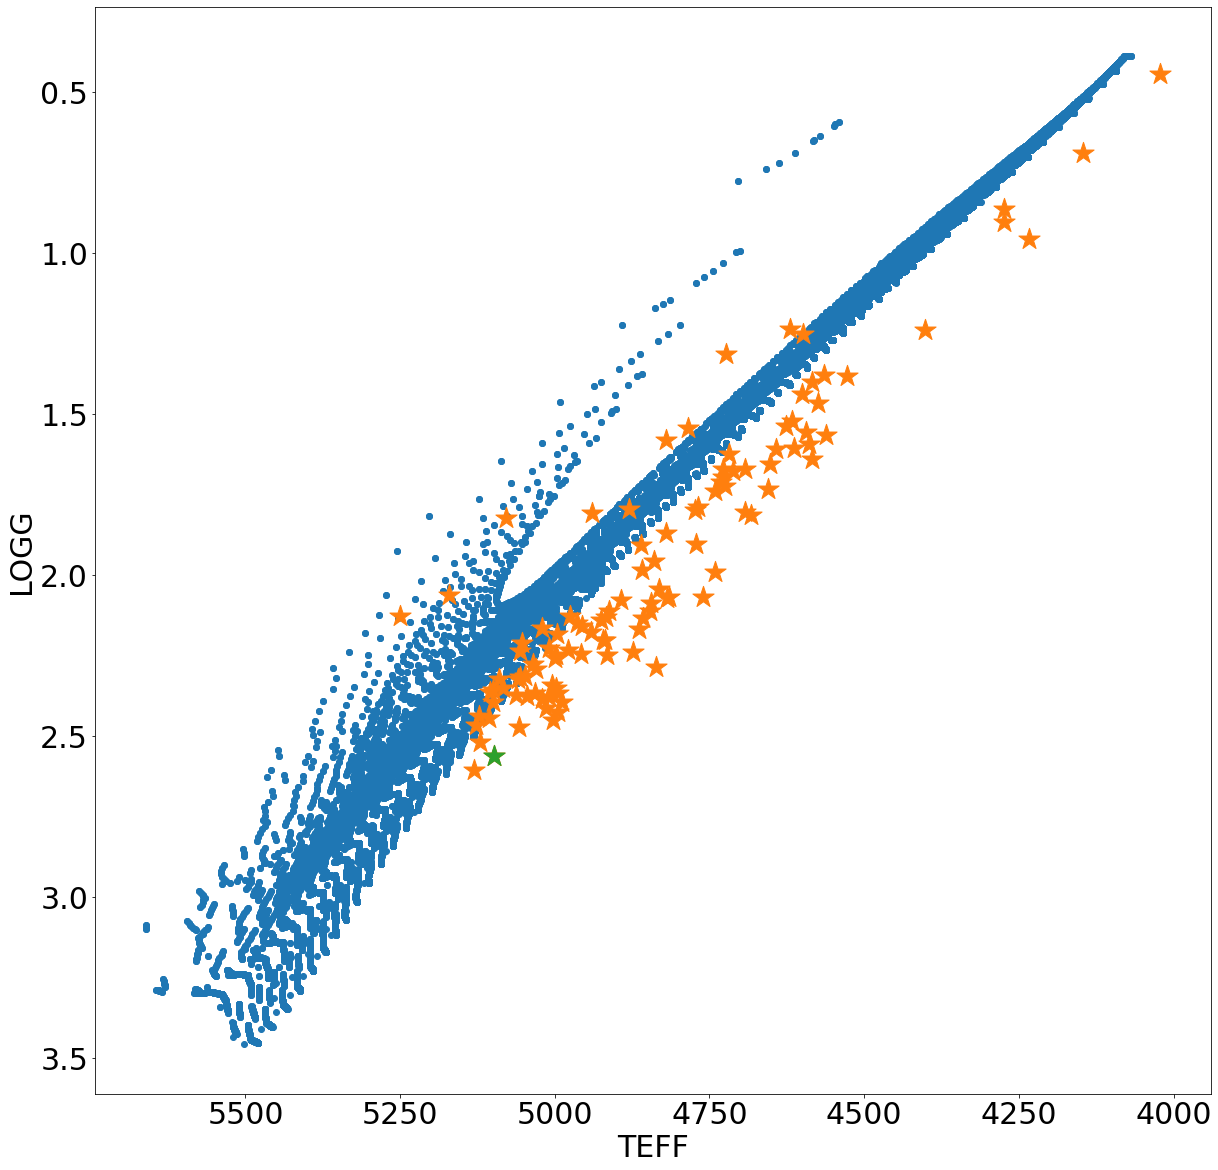

In [180]:
plt.figure(figsize=[20,20])
plt.scatter(10**massive['logTe'][m22iso],massive['logg'][m22iso])
plt.scatter(gcs['TEFF'][m22_idx],gcs['LOGG'][m22_idx],marker='*',s=500)
plt.scatter(gcs['TEFF'][m22_idx][bad3],gcs['LOGG'][m22_idx][bad3],marker='*',s=500,c='tab:green')
plt.gca().invert_yaxis()
plt.ylabel(r'LOGG')
plt.xlabel(r'TEFF')
plt.gca().invert_xaxis()
plt.show()

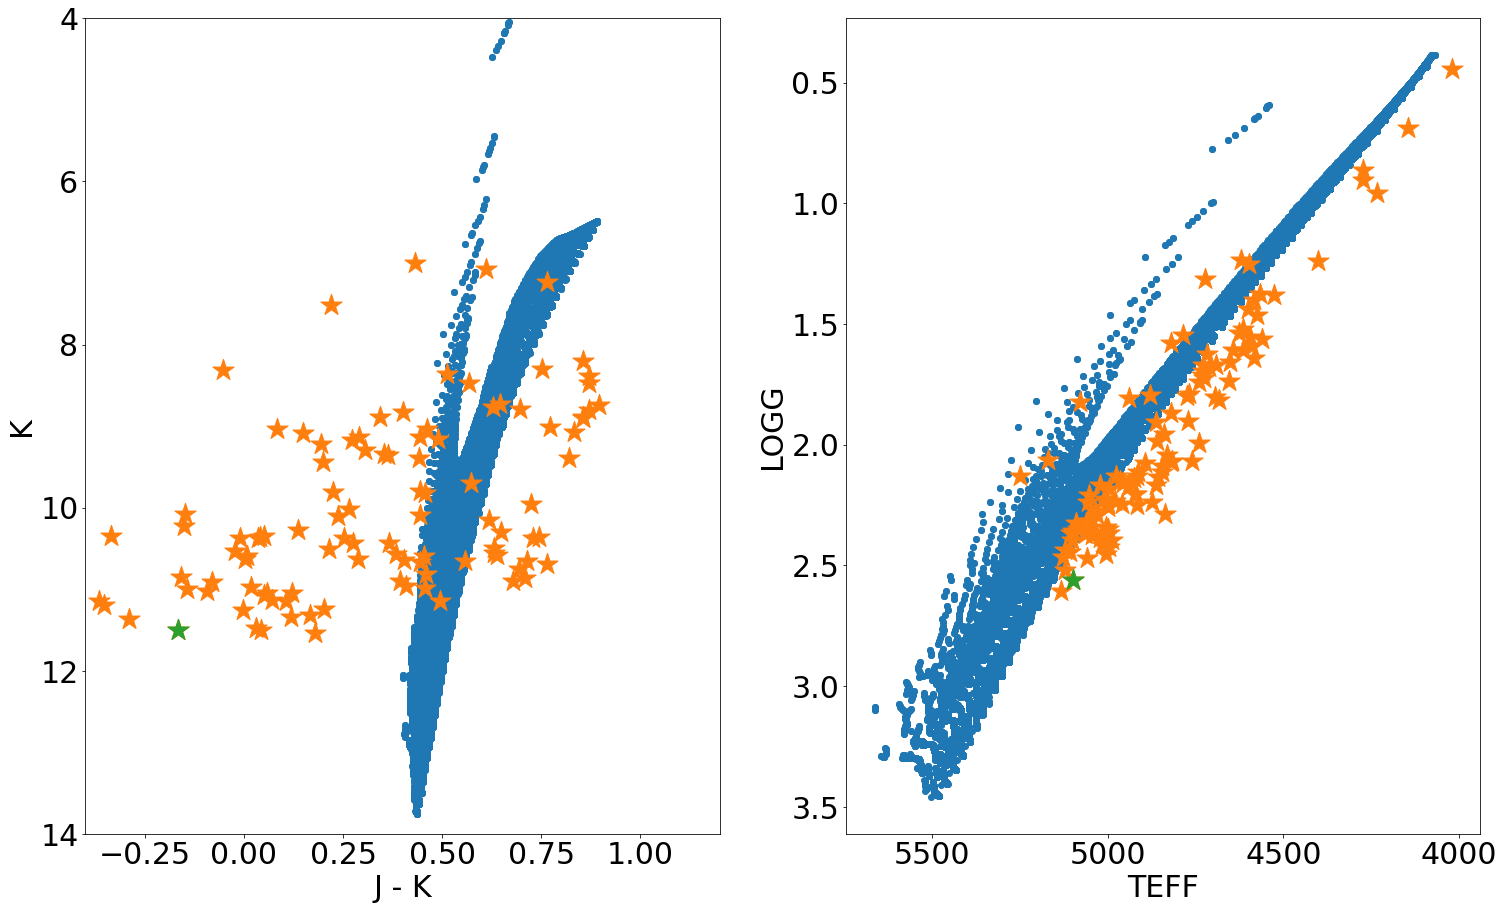

In [186]:
fig, ax = plt.subplots(1,2,figsize=[25,15])
### CMD
ax[0].scatter((massive['Jmag']-massive['Ksmag'])[m22iso],
            massive['Ksmag'][m22iso]+5*np.log10(gcs_dist[m22_idx][0])-5.0)
ax[0].scatter((gcs['J']-gcs['K'])[m22_idx]-ejk_ak*np.asarray(bestaks),gcs['K'][m22_idx]-bestaks,marker='*',s=500)
ax[0].scatter(((gcs['J']-gcs['K'])[m22_idx]-ejk_ak*np.asarray(bestaks))[bad3],(gcs['K'][m22_idx]-bestaks)[bad3],
            marker='*',s=500,c='tab:green')
ax[0].invert_yaxis()
ax[0].set_ylabel(r'K')
ax[0].set_xlabel(r'J - K')
ax[0].set_ylim(14,4)
ax[0].set_xlim(-0.4,1.2)

### sHR
ax[1].scatter(10**massive['logTe'][m22iso],massive['logg'][m22iso])
ax[1].scatter(gcs['TEFF'][m22_idx],gcs['LOGG'][m22_idx],marker='*',s=500)
ax[1].scatter(gcs['TEFF'][m22_idx][bad3],gcs['LOGG'][m22_idx][bad3],marker='*',s=500,c='tab:green')
ax[1].invert_yaxis()
ax[1].set_ylabel(r'LOGG')
ax[1].set_xlabel(r'TEFF')
ax[1].invert_xaxis()

plt.show()

In [104]:
bads = np.array([bad1,bad2,bad3,bad4,bad5])
gcs_bad_idx = np.array([m22_idx[bad1],m22_idx[bad2],m22_idx[bad3],m22_idx[bad4],m22_idx[bad5]])
gcs_bad_idx

array([1839, 1750, 1776, 1808, 1785])

In [108]:
np.shape(badtheos)

(60, 5)

In [125]:
print(len(gcs_bad_idx))
print(len(np.arange(0,15,0.25)))

5
60


In [142]:
badtheos = 999999.0*np.ones((len(np.arange(0,15,0.25)),len(gcs_bad_idx),3))
badtheos0 = 999999.0*np.ones((len(np.arange(0,15,0.25)),len(gcs_bad_idx),3))

for i in tqdm_notebook(range(len(gcs_bad_idx))):
    CalcAge = WhatsMyAgeAgain(gcs['M_H'][gcs_bad_idx[i]],gcs['ALPHA_M'][gcs_bad_idx[i]],gcs_dist[gcs_bad_idx[i]],
                              3.1,massive)

    for j in range(len(np.arange(0,15,0.25))):
        theo = CalcAge.Teff2AppMags(gcs['TEFF'][gcs_bad_idx[i]],np.arange(0,15,0.25)[j],bestaks[bads[i]])
        theo0 = CalcAge.Teff2AppMags(gcs['TEFF'][gcs_bad_idx[i]],np.arange(0,15,0.25)[j],0)
        badtheos[j,i,0] = theo[0]
        badtheos[j,i,1] = theo[1]
        badtheos[j,i,2] = theo[2]
        badtheos0[j,i,0] = theo0[0]
        badtheos0[j,i,1] = theo0[1]
        badtheos0[j,i,2] = theo0[2]

In [130]:
badtheos[:,0,:]

array([[9.99999000e+05, 9.99999000e+05, 9.99999000e+05],
       [9.99999000e+05, 9.99999000e+05, 9.99999000e+05],
       [9.99999000e+05, 9.99999000e+05, 9.99999000e+05],
       [9.99999000e+05, 9.99999000e+05, 9.99999000e+05],
       [9.99999000e+05, 9.99999000e+05, 9.99999000e+05],
       [9.99999000e+05, 9.99999000e+05, 9.99999000e+05],
       [9.99999000e+05, 9.99999000e+05, 9.99999000e+05],
       [9.99999000e+05, 9.99999000e+05, 9.99999000e+05],
       [9.25823647e+00, 8.06268936e+00, 7.61234090e+00],
       [9.31904992e+00, 8.12351762e+00, 7.67333674e+00],
       [9.37129194e+00, 8.17465042e+00, 7.72479699e+00],
       [9.42453604e+00, 8.22787915e+00, 7.77744235e+00],
       [9.47136081e+00, 8.27433274e+00, 7.82422302e+00],
       [9.51189580e+00, 8.31529987e+00, 7.86516208e+00],
       [9.55130803e+00, 8.35466030e+00, 7.90431297e+00],
       [9.58144124e+00, 8.38449629e+00, 7.93373982e+00],
       [9.61139611e+00, 8.41438086e+00, 7.96439931e+00],
       [9.63731930e+00, 8.44102

In [160]:
bestages

array([1.20100e+01, 1.20100e+01, 1.20100e+01, 1.20000e+01, 1.20100e+01,
       1.20100e+01, 1.20100e+01, 1.20100e+01, 1.20000e+01, 1.20000e+01,
       1.20100e+01, 1.20100e+01, 1.20100e+01, 1.20100e+01, 1.20000e+01,
       1.20000e+01, 1.20100e+01, 1.20000e+01, 1.20100e+01, 1.20000e+01,
       1.20100e+01, 1.20100e+01, 1.20100e+01, 1.20100e+01, 1.20100e+01,
       1.20100e+01, 1.20100e+01, 1.20100e+01, 1.20100e+01, 1.20000e+01,
       1.20000e+01, 1.20100e+01, 1.20100e+01, 1.20000e+01, 9.99999e+05,
       1.20100e+01, 1.20100e+01, 1.20000e+01, 1.20100e+01, 1.20000e+01,
       1.20100e+01, 1.20000e+01, 1.20100e+01, 1.20100e+01, 1.20100e+01,
       1.20100e+01, 1.20100e+01, 1.20100e+01, 1.20100e+01, 1.20000e+01,
       1.20000e+01, 1.20100e+01, 1.20100e+01, 1.20000e+01, 1.20000e+01,
       1.20000e+01, 1.20000e+01, 1.20100e+01, 1.20000e+01, 1.20100e+01,
       1.20100e+01, 1.20000e+01, 1.20100e+01, 1.20100e+01, 1.20100e+01,
       1.20100e+01, 1.20000e+01, 1.20100e+01, 1.20100e+01, 1.200

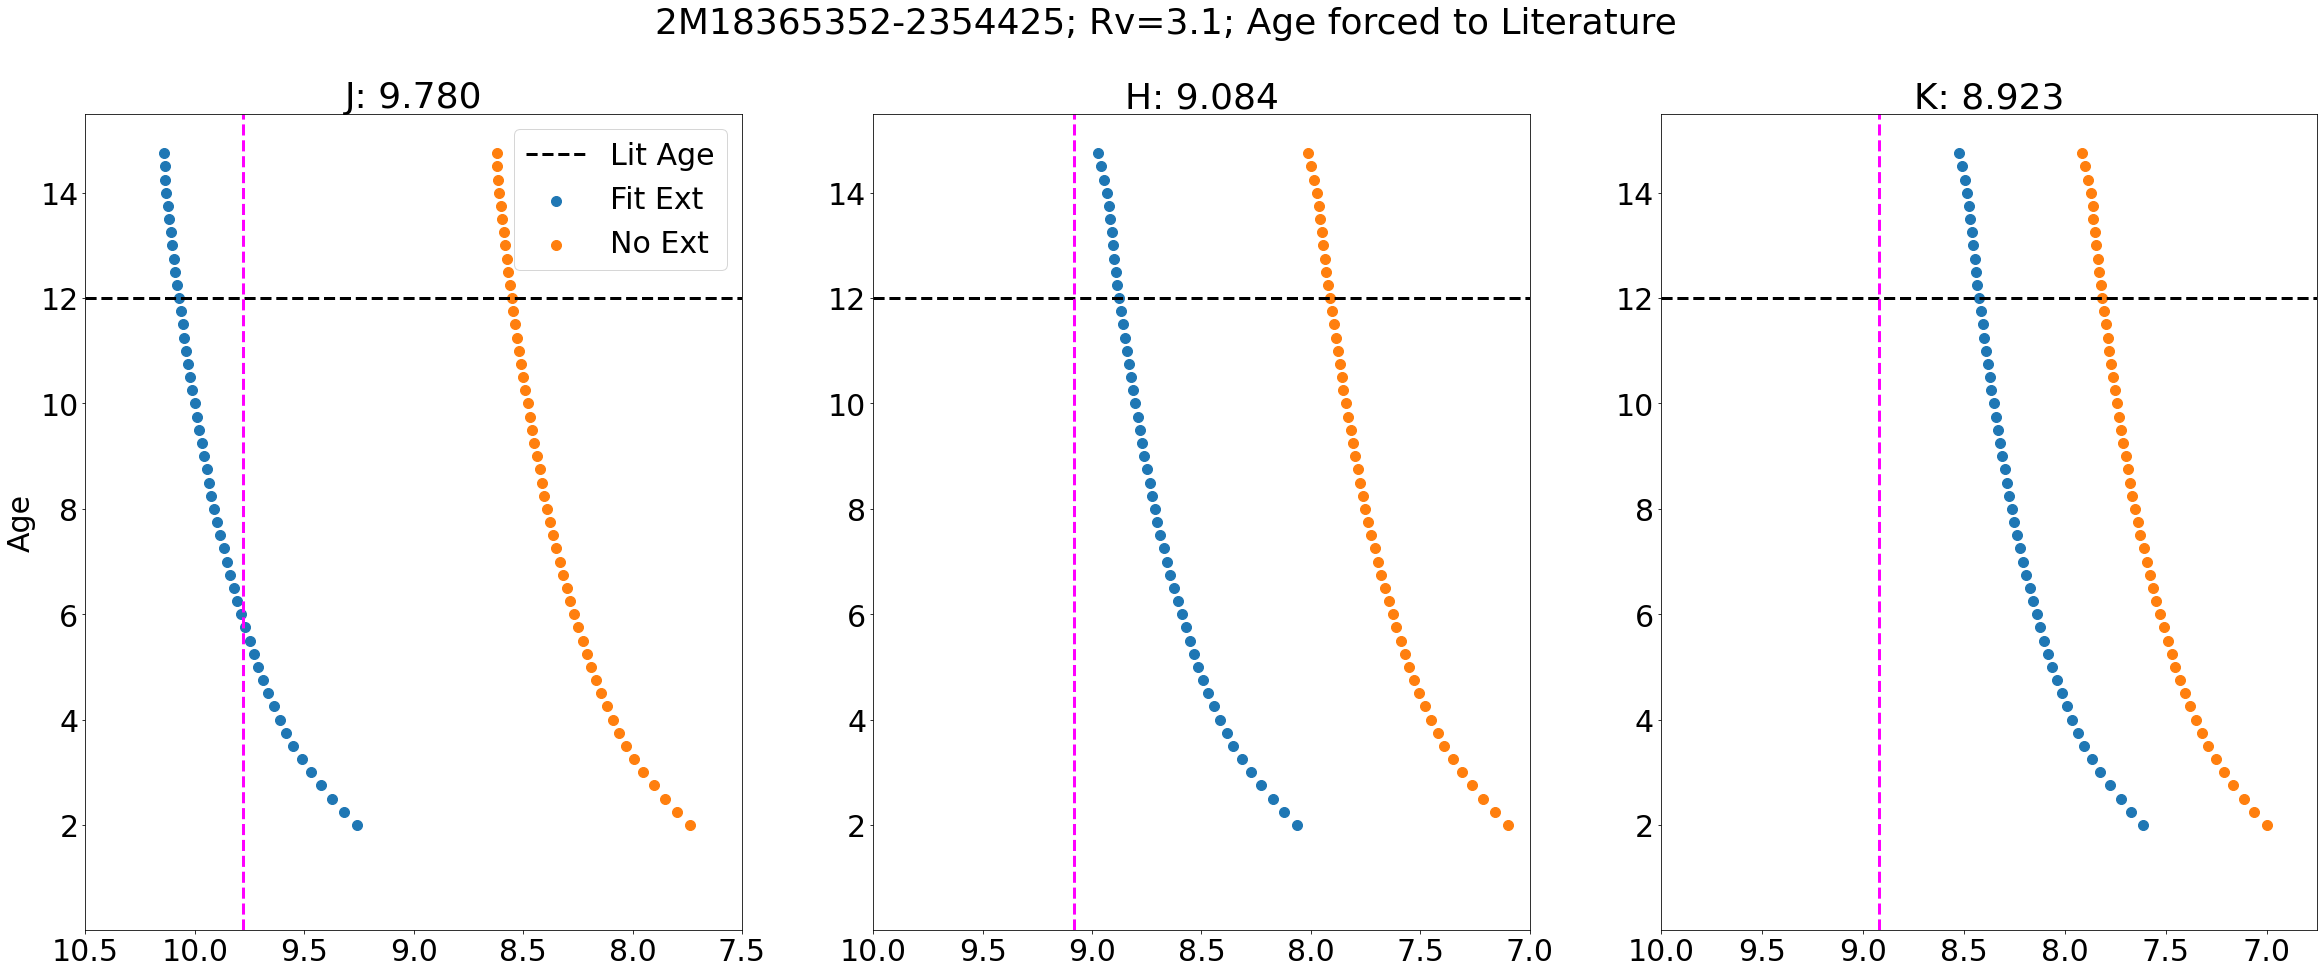

In [162]:
bands = ['J','H','K']
fig, ax = plt.subplots(1,3,figsize=[40,15])
for i in range(3):
    ax[i].scatter(badtheos[:,0,i],np.arange(0,15,0.25),s=100,label='Fit Ext')
    ax[i].scatter(badtheos0[:,0,i],np.arange(0,15,0.25),s=100,label='No Ext')
    ax[i].set_ylim(bottom=0.01)
    ax[i].axhline(12.0,c='k',ls='--',label='Lit Age',lw=3.0)

ax[0].axvline(gcs[gcs_bad_idx[0]]['J'],ls='--',c='magenta',lw=3.0)
ax[1].axvline(gcs[gcs_bad_idx[0]]['H'],ls='--',c='magenta',lw=3.0)
ax[2].axvline(gcs[gcs_bad_idx[0]]['K'],ls='--',c='magenta',lw=3.0)

ax[0].set_title(r'J: {:.3f}'.format(gcs[gcs_bad_idx[0]]['J']))
ax[1].set_title(r'H: {:.3f}'.format(gcs[gcs_bad_idx[0]]['H']))
ax[2].set_title(r'K: {:.3f}'.format(gcs[gcs_bad_idx[0]]['K']))

ax[0].set_xlim(10.5,7.5)
ax[1].set_xlim(10.,7.)
ax[2].set_xlim(10.,6.75)

ax[0].legend()

ax[0].set_ylabel('Age')
plt.suptitle(r'{}; Rv=3.1; Age forced to Literature'.format(gcs[gcs_bad_idx[0]]['APOGEE_ID']))

plt.show()

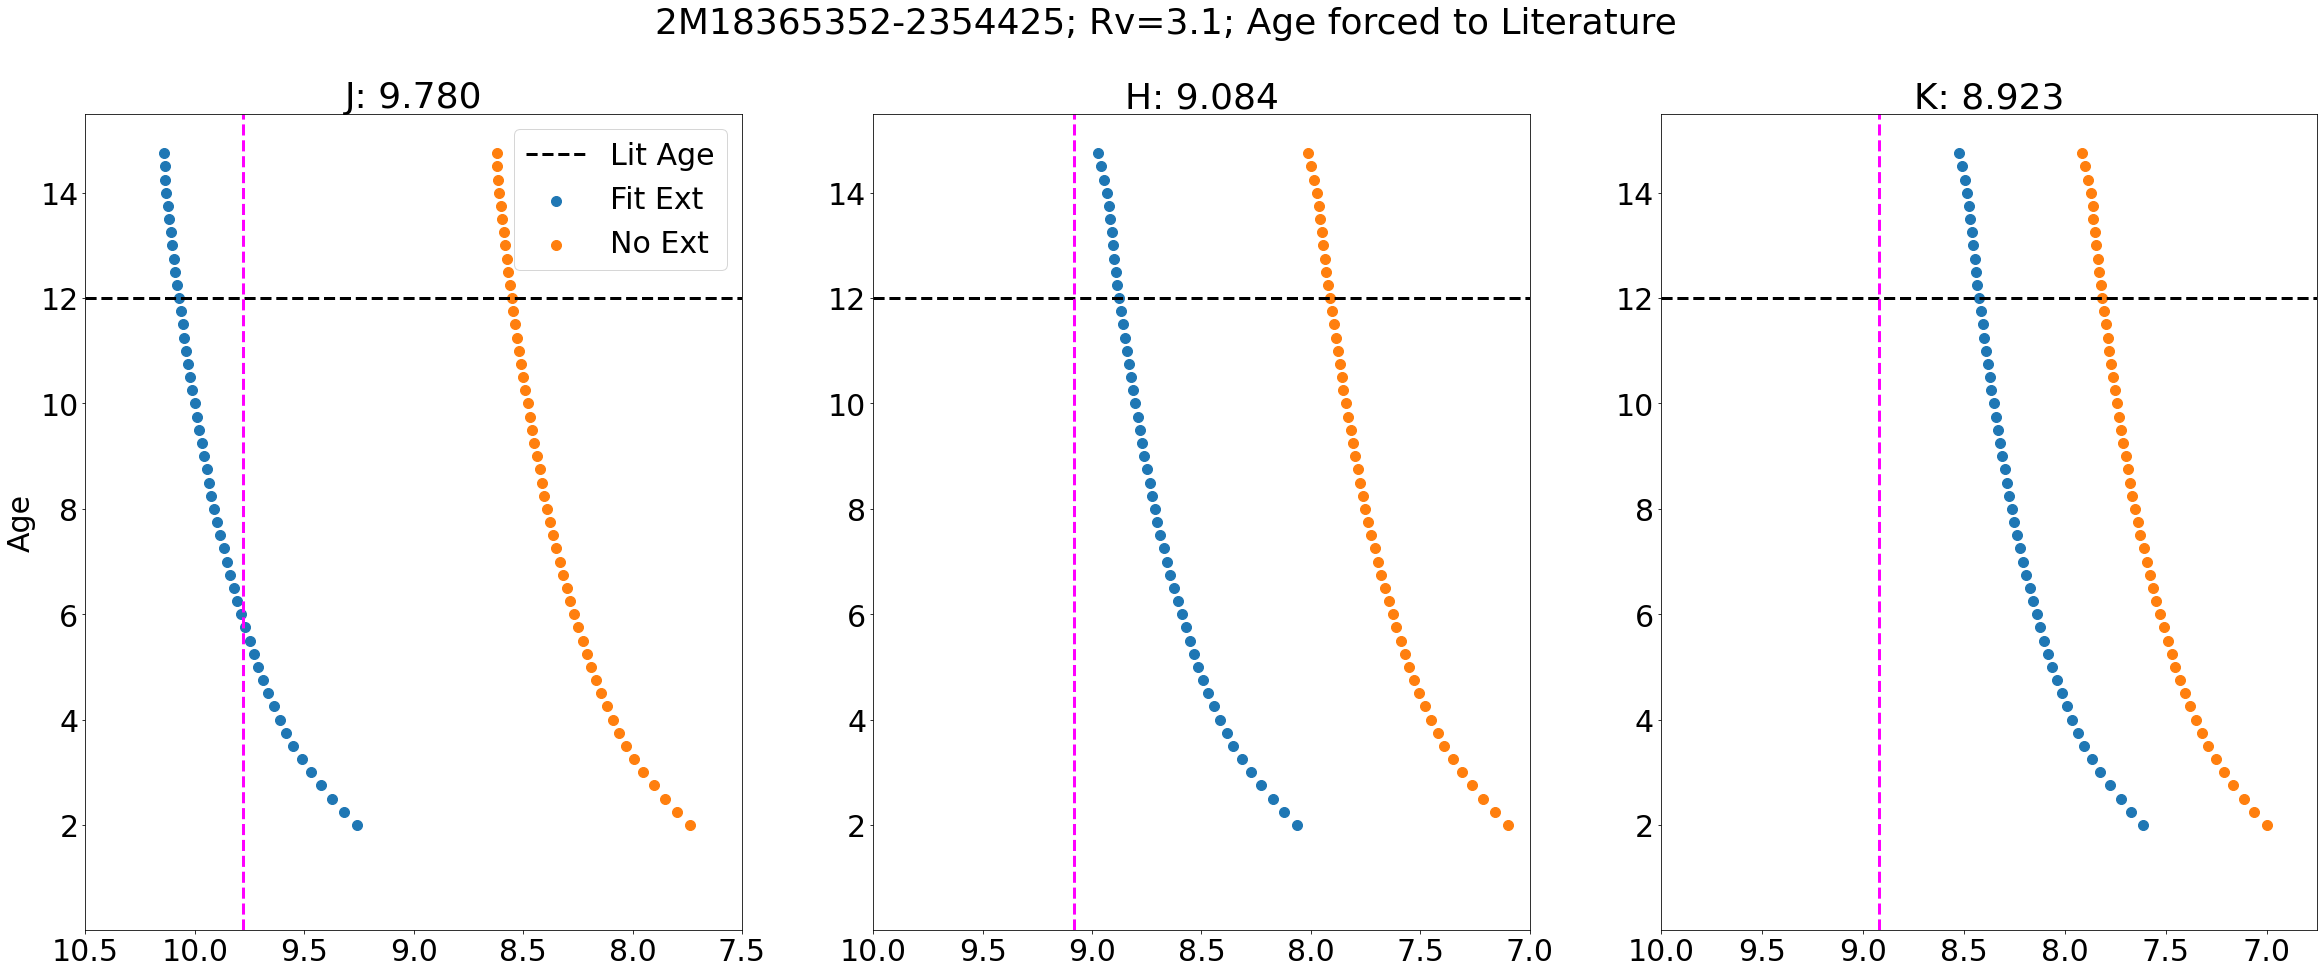

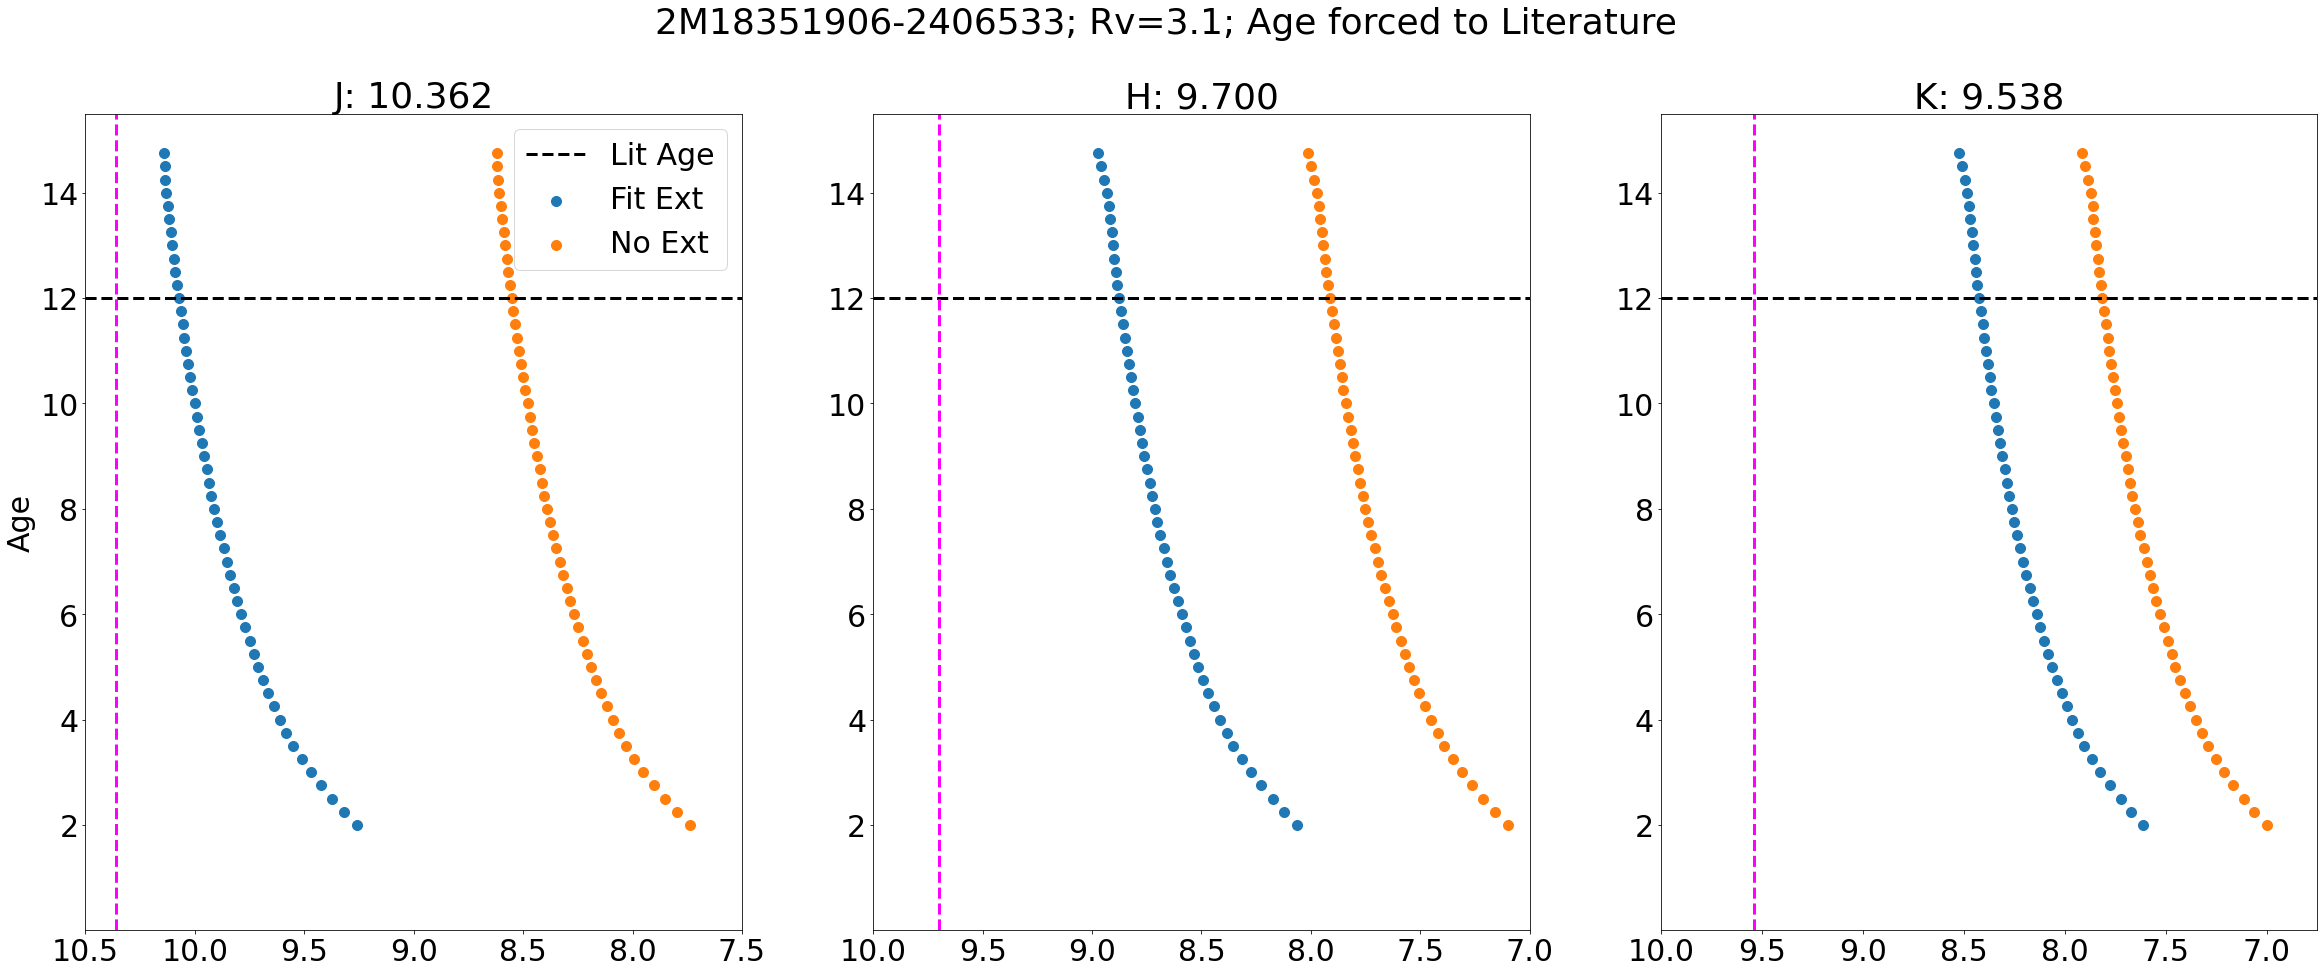

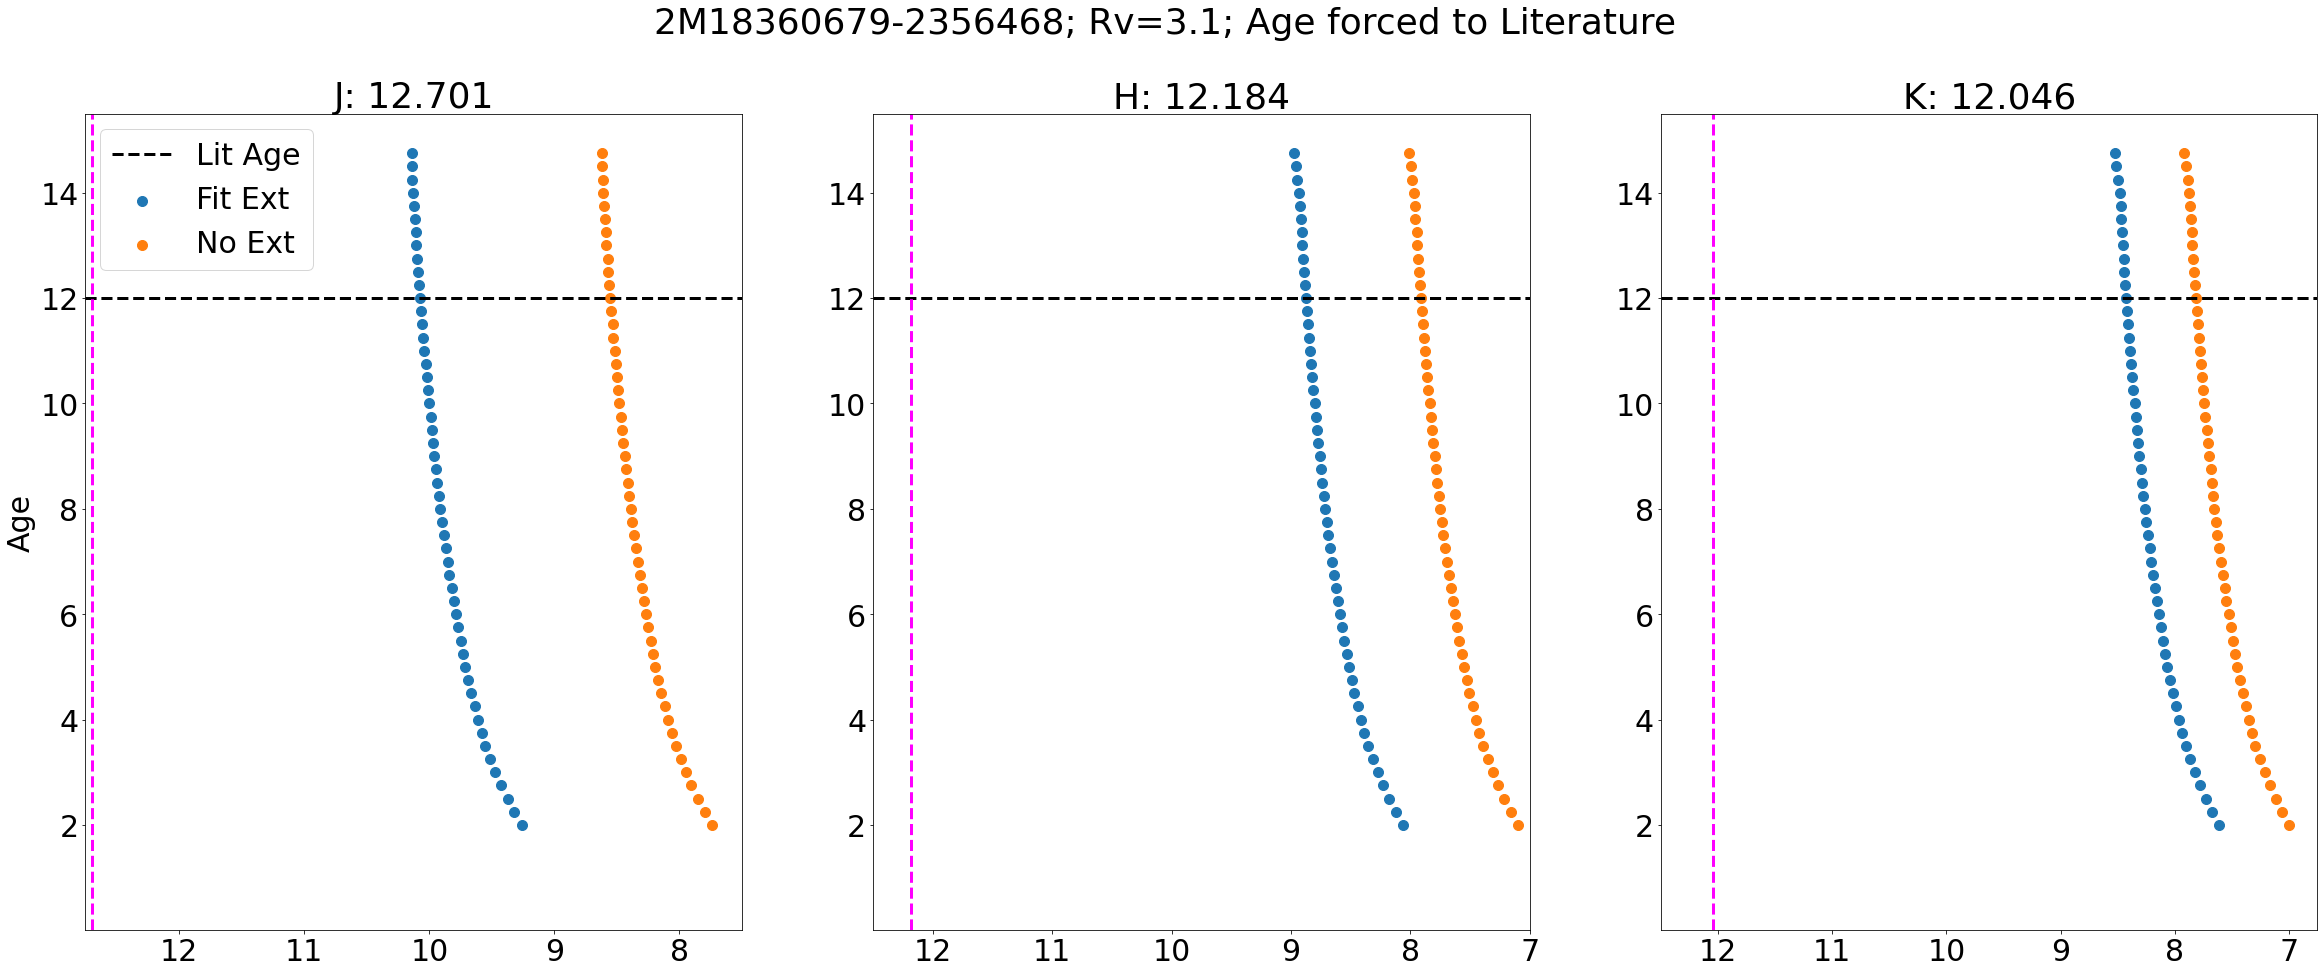

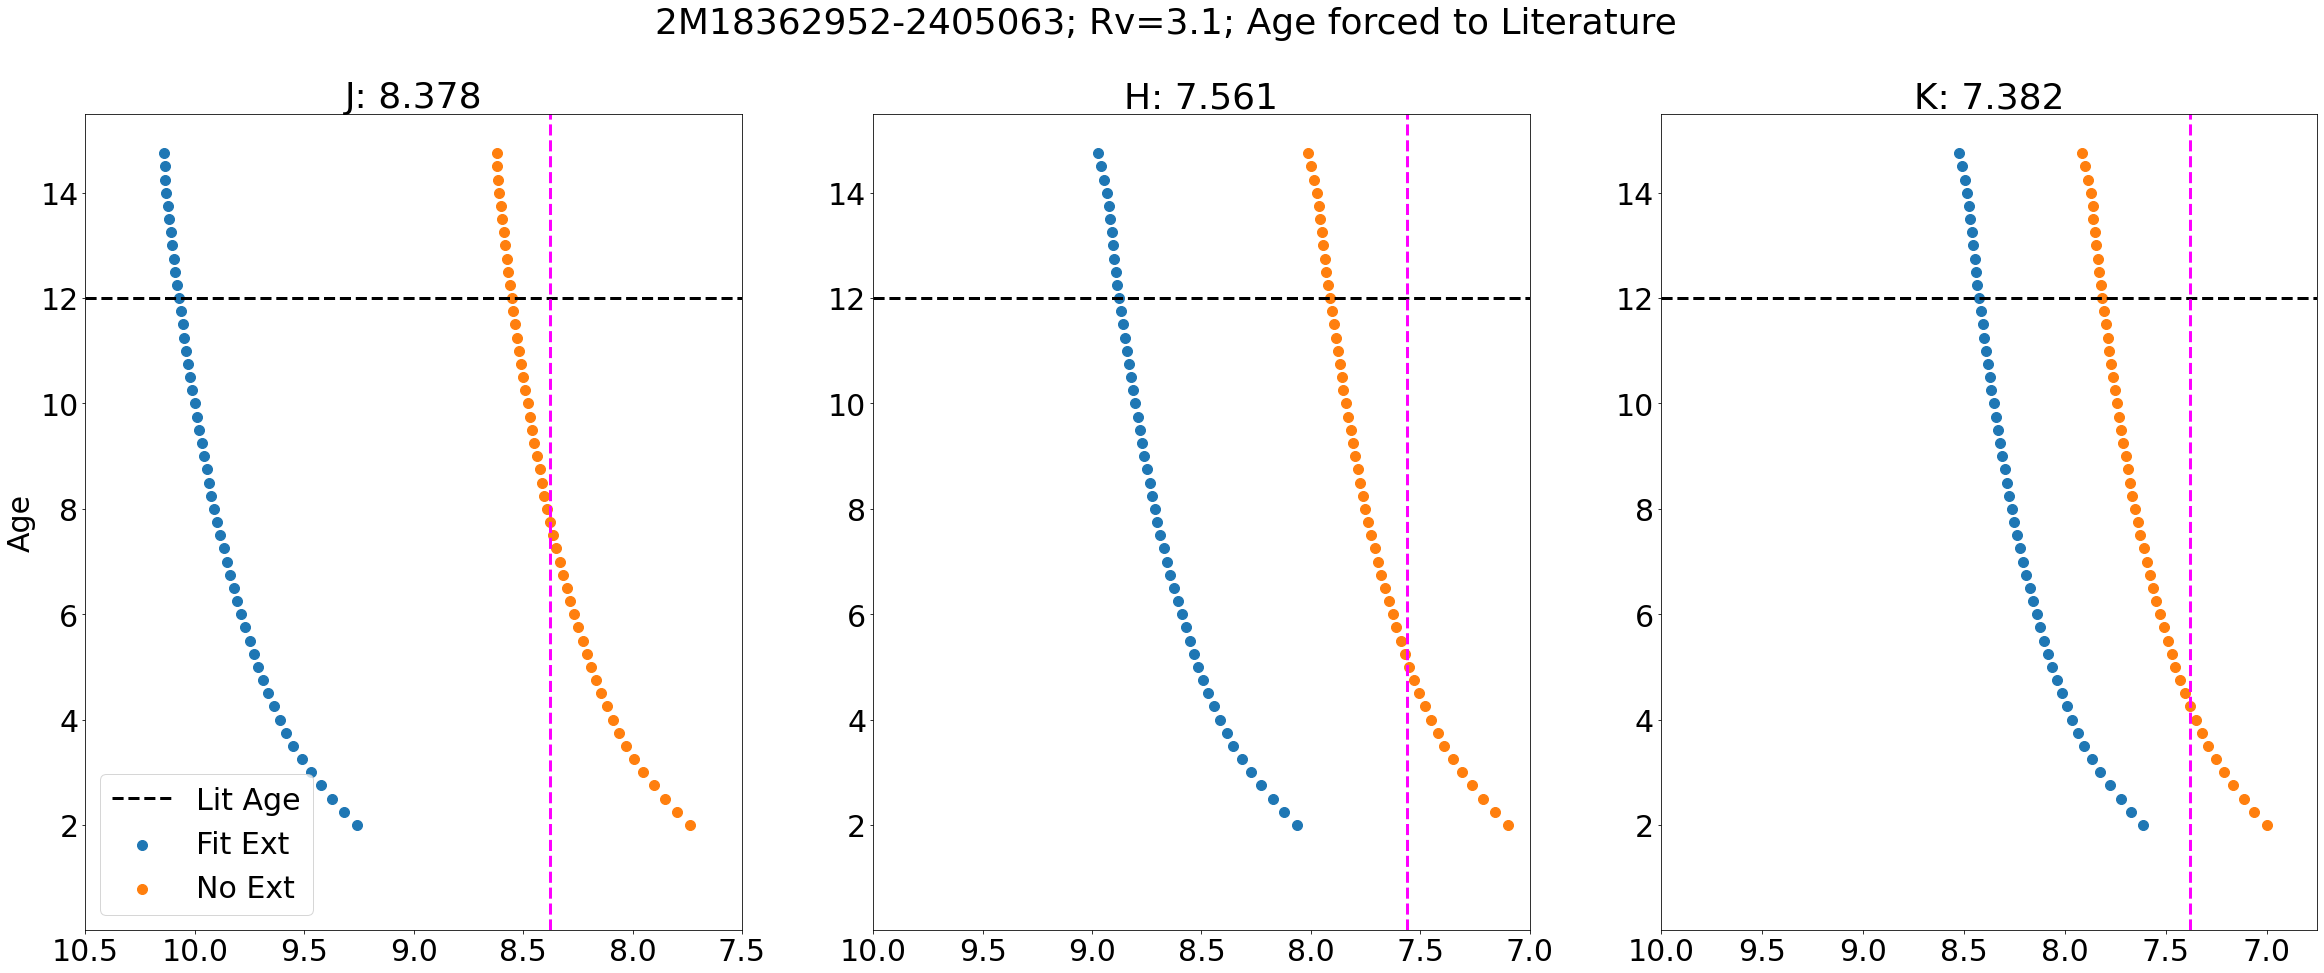

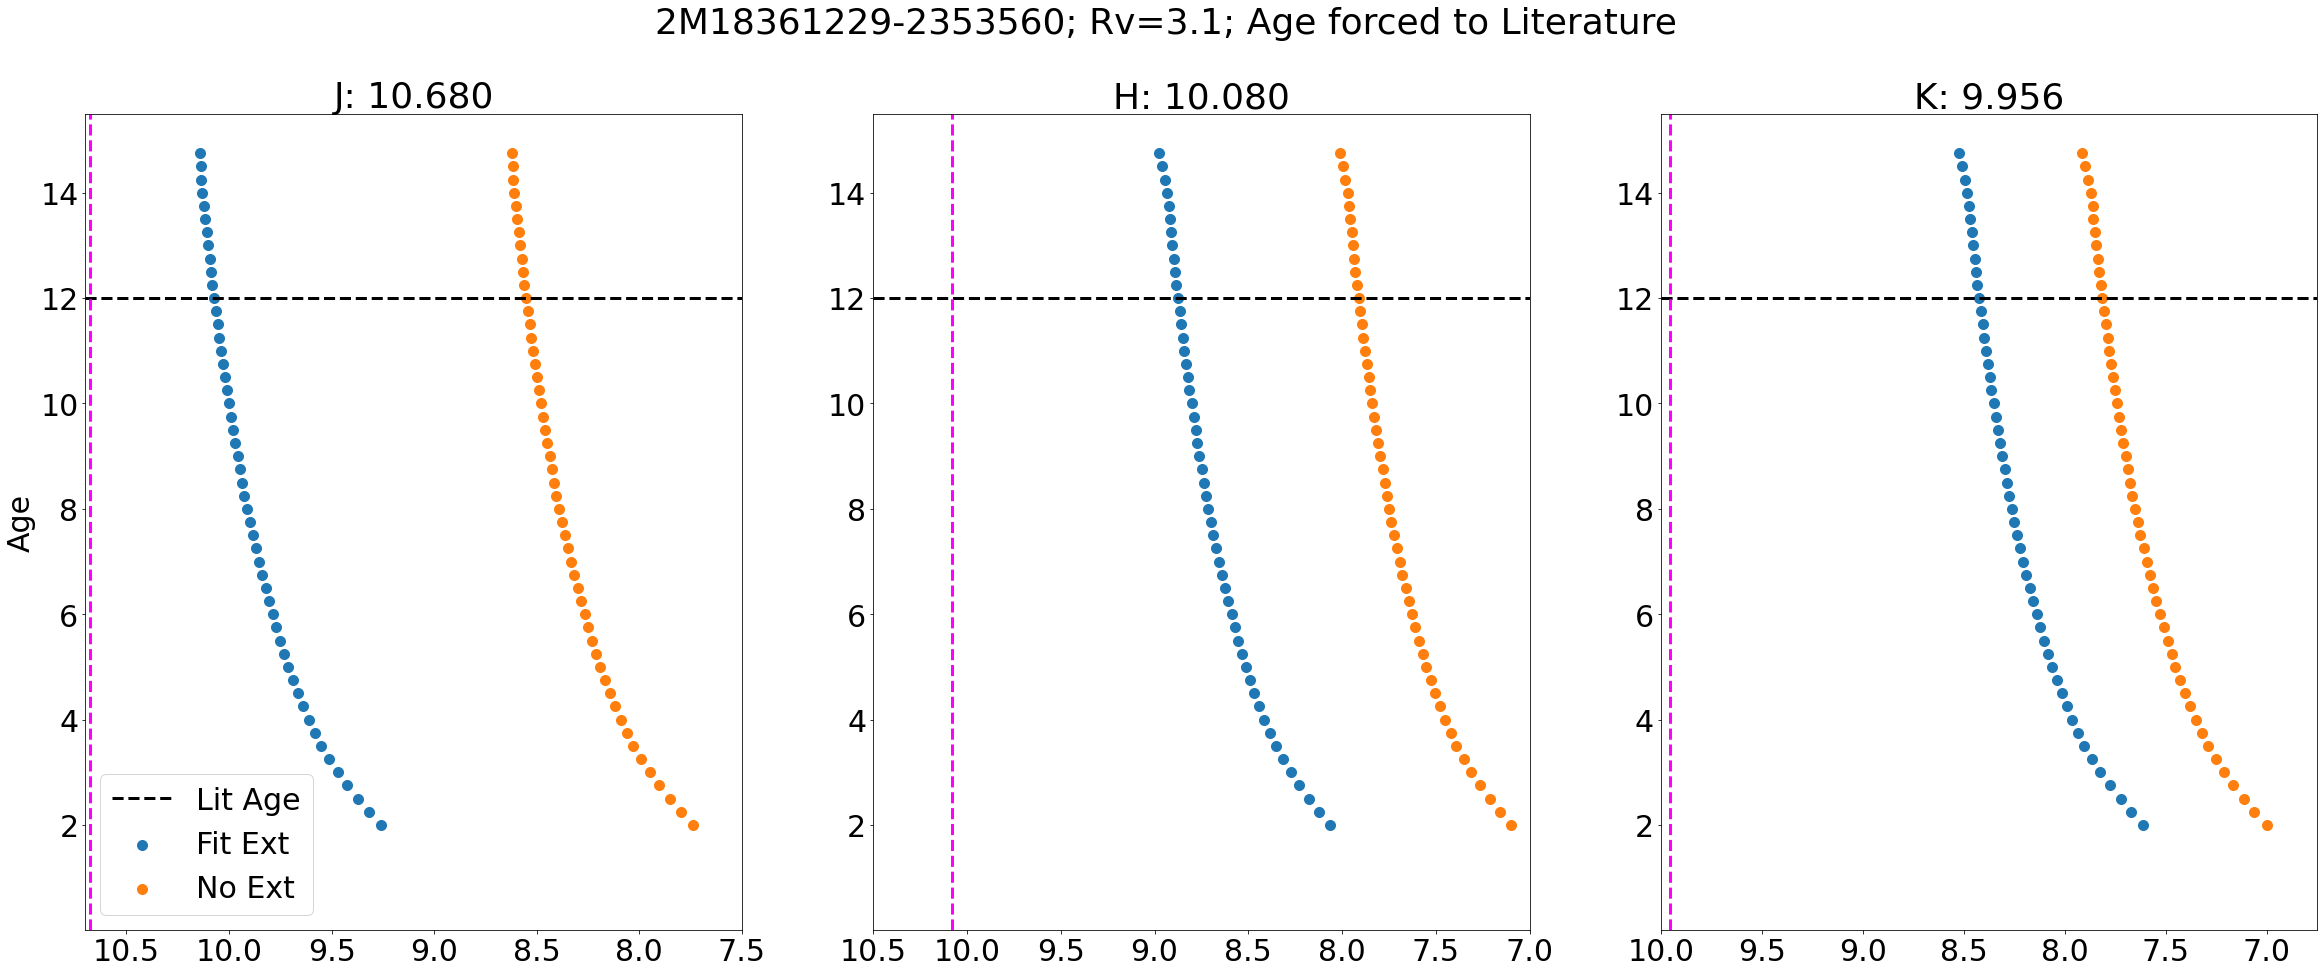

In [167]:
bands = ['J','H','K']
for j in range(len(gcs_bad_idx)):
    fig, ax = plt.subplots(1,3,figsize=[40,15])
    for i in range(3):
        ax[i].scatter(badtheos[:,0,i],np.arange(0,15,0.25),s=100,label='Fit Ext')
        ax[i].scatter(badtheos0[:,0,i],np.arange(0,15,0.25),s=100,label='No Ext')
        ax[i].set_ylim(bottom=0.01)
        ax[i].axhline(12.0,c='k',ls='--',label='Lit Age',lw=3.0)

    ax[0].axvline(gcs[gcs_bad_idx[j]]['J'],ls='--',c='magenta',lw=3.0)
    ax[1].axvline(gcs[gcs_bad_idx[j]]['H'],ls='--',c='magenta',lw=3.0)
    ax[2].axvline(gcs[gcs_bad_idx[j]]['K'],ls='--',c='magenta',lw=3.0)

    ax[0].set_title(r'J: {:.3f}'.format(gcs[gcs_bad_idx[j]]['J']))
    ax[1].set_title(r'H: {:.3f}'.format(gcs[gcs_bad_idx[j]]['H']))
    ax[2].set_title(r'K: {:.3f}'.format(gcs[gcs_bad_idx[j]]['K']))

    ax[0].set_xlim(10.5,7.5)
    ax[1].set_xlim(10.,7.)
    ax[2].set_xlim(10.,6.75)
    
    if j == 2:
        ax[0].set_xlim(12.75,7.5)
        ax[1].set_xlim(12.5,7.)
        ax[2].set_xlim(12.5,6.75)
        
    if j == 4:
        ax[0].set_xlim(10.7,7.5)
        ax[1].set_xlim(10.5,7.)
        ax[2].set_xlim(10.,6.75)

    ax[0].legend()

    ax[0].set_ylabel('Age')
    plt.suptitle(r'{}; Rv=3.1; Age forced to Literature'.format(gcs[gcs_bad_idx[j]]['APOGEE_ID']))

    plt.show()

# Rv = 3.6

In [168]:
ages0 = np.arange(0,15,1.0)
aks0 = np.array([0,0.5,1.0])

curve_chis36 = 999999.0*np.ones((len(ages0),len(aks0),len(m22_idx)))
curve_ages36 = 999999.0*np.ones((len(ages0),len(aks0),len(m22_idx)))
curve_aks36 = 999999.0*np.ones((len(ages0),len(aks0),len(m22_idx)))
for k in tqdm_notebook(range(len(m22_idx))):
        CalcAge = WhatsMyAgeAgain(gcs['M_H'][m22_idx[k]],gcs['ALPHA_M'][m22_idx[k]],gcs_dist[m22_idx[k]],
                                  3.1,massive)
        for i in range(len(ages0)):
            for j in range(len(aks0)):
                try:
                    popt,_ = curve_fit(CalcAge.Teff2AppMags,gcs['TEFF'][m22_idx[k]],
                                  np.array([[gcs['J'][m22_idx[k]],gcs['H'][m22_idx[k]],gcs['K'][m22_idx[k]]]],
                                       dtype=float).T.ravel(),
                                  p0=[ages0[i],aks0[j]],bounds=((12.,0.),(12.01,2.)),method='trf',
                                  sigma=np.array([[gcs['J_ERR'][m22_idx[k]],gcs['H_ERR'][m22_idx[k]],
                                                   gcs['K_ERR'][m22_idx[k]]]],dtype=float).T.ravel(),maxfev=5000)
        
                    curve_ages36[i,j,k] = popt[0]
                    curve_aks36[i,j,k] = popt[1]
      
                    calc_mags = np.asarray(CalcAge.Teff2AppMags(gcs['TEFF'][m22_idx[k]],popt[0],popt[1]))
                    mag_errs = np.array([gcs['J_ERR'][m22_idx[k]],gcs['H_ERR'][m22_idx[k]],
                                         gcs['K_ERR'][m22_idx[k]]])
                    mags = np.array([gcs['J'][m22_idx[k]],gcs['H'][m22_idx[k]],gcs['K'][m22_idx[k]]])
                    curve_chis36[i,j,k] = sum((calc_mags-mags)**2/mag_errs**2)
                    
                except:
                    curve_ages36[i,j,k]=999999.0
                    curve_aks36[i,j,k]=999999.0
                    curve_chis36[i,j,k]=999999.0

In [169]:
bestaks36 = 999999.0*np.ones(len(m22_idx))
bestchis36 = 999999.0*np.ones(len(m22_idx))
bestages36 = 999999.0*np.ones(len(m22_idx))
for i in range(len(m22_idx)):
    bestidx = np.where(curve_chis36[:,:,i]==np.min(curve_chis36[:,:,i]))
    bestchis36[i] = np.median(curve_chis36[:,:,i][bestidx])
    bestaks36[i] = np.median(curve_aks36[:,:,i][bestidx])
    bestages36[i] = np.median(curve_ages36[:,:,i][bestidx])

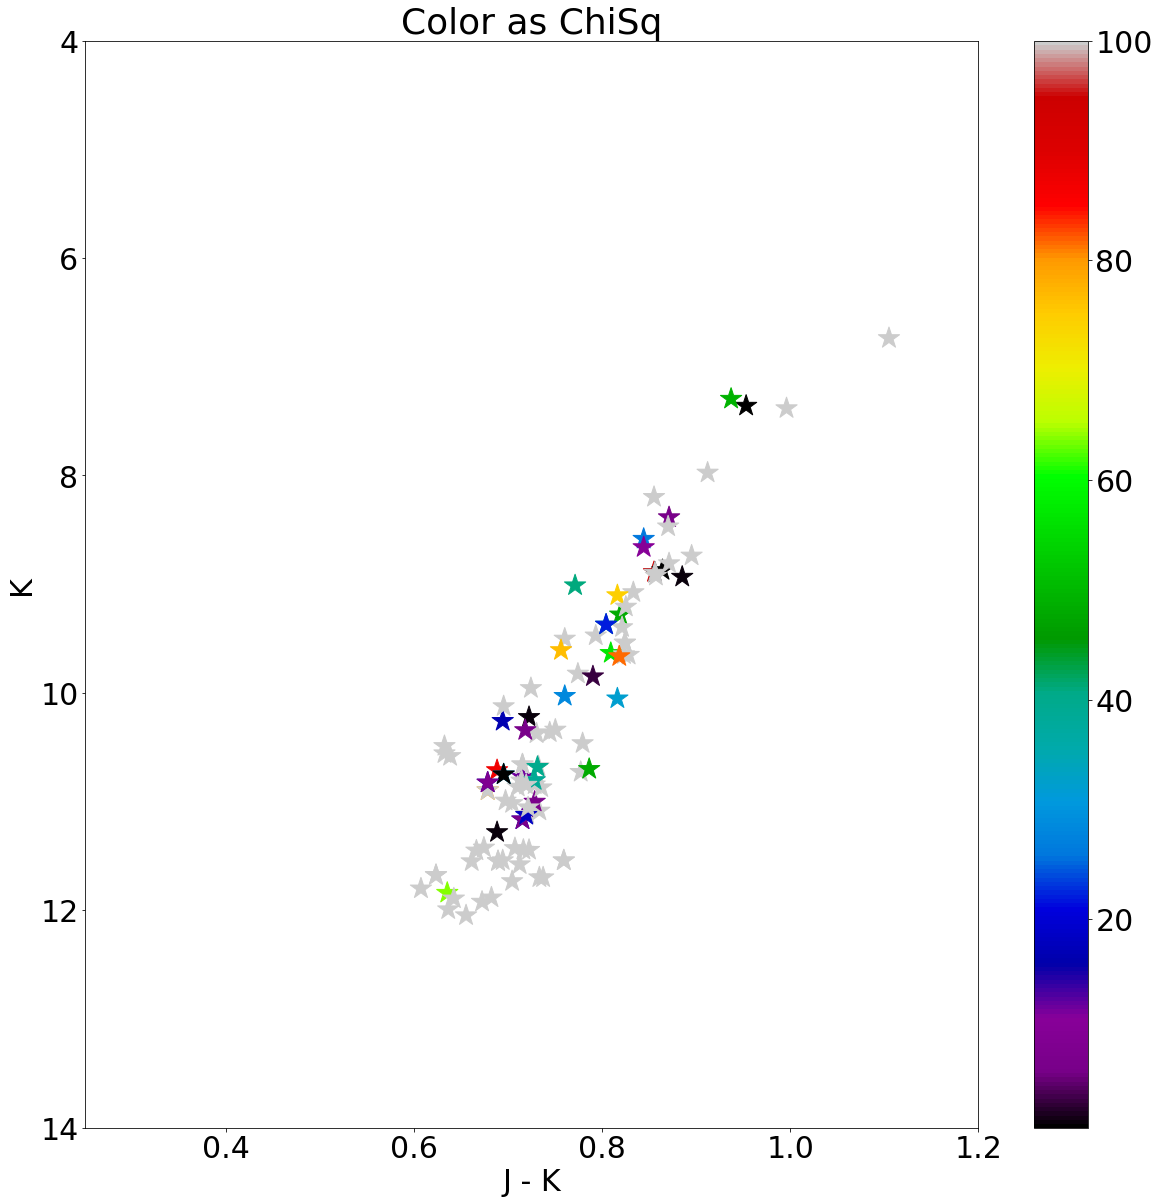

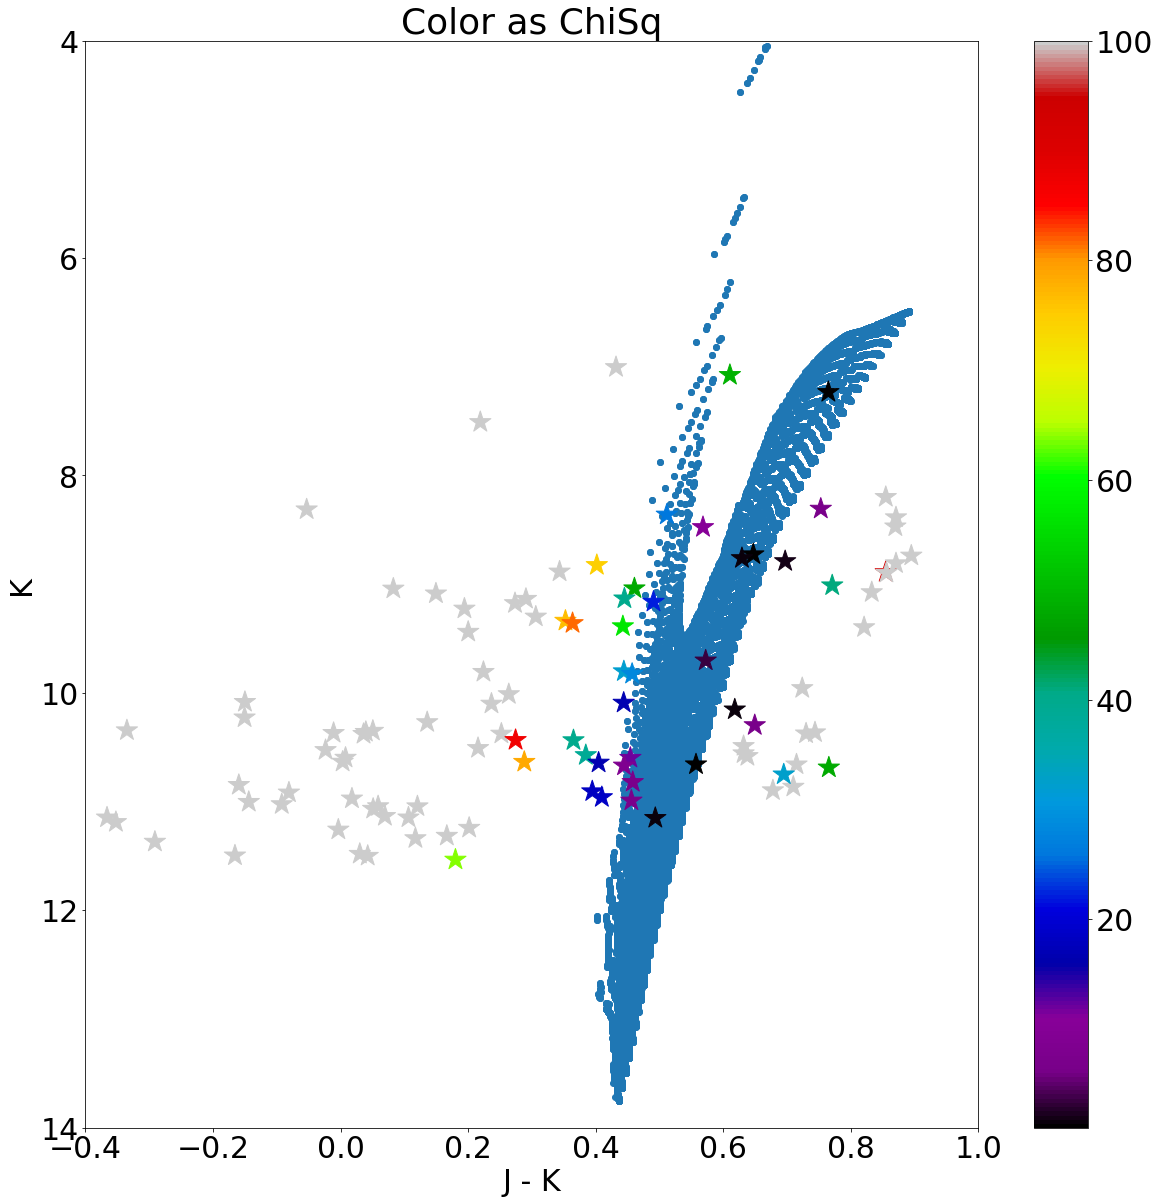

In [170]:
### Without Isochrones
plt.figure(figsize=[20,20])
plt.scatter((gcs['J']-gcs['K'])[m22_idx],gcs['K'][m22_idx],c=bestchis36,cmap='nipy_spectral',vmax=100,marker='*',
            s=500)
plt.colorbar()
plt.gca().invert_yaxis()
plt.title(r'Color as ChiSq')
plt.ylabel(r'K')
plt.xlabel(r'J - K')
plt.ylim(14,4)
plt.xlim(0.25,1.2)
plt.show()

### With Isochrones
plt.figure(figsize=[20,20])
plt.scatter((massive['Jmag']-massive['Ksmag'])[m22iso],
            massive['Ksmag'][m22iso]+5*np.log10(gcs_dist[m22_idx][0])-5.0)
plt.scatter((gcs['J']-gcs['K'])[m22_idx]-ejk_ak*np.asarray(bestaks36),gcs['K'][m22_idx]-bestaks36,c=bestchis36,
            cmap='nipy_spectral',vmax=100,
            marker='*',s=500)
plt.colorbar()
plt.gca().invert_yaxis()
plt.title(r'Color as ChiSq')
plt.ylabel(r'K')
plt.xlabel(r'J - K')
plt.ylim(14,4)
plt.xlim(-0.4,1.0)
plt.show()

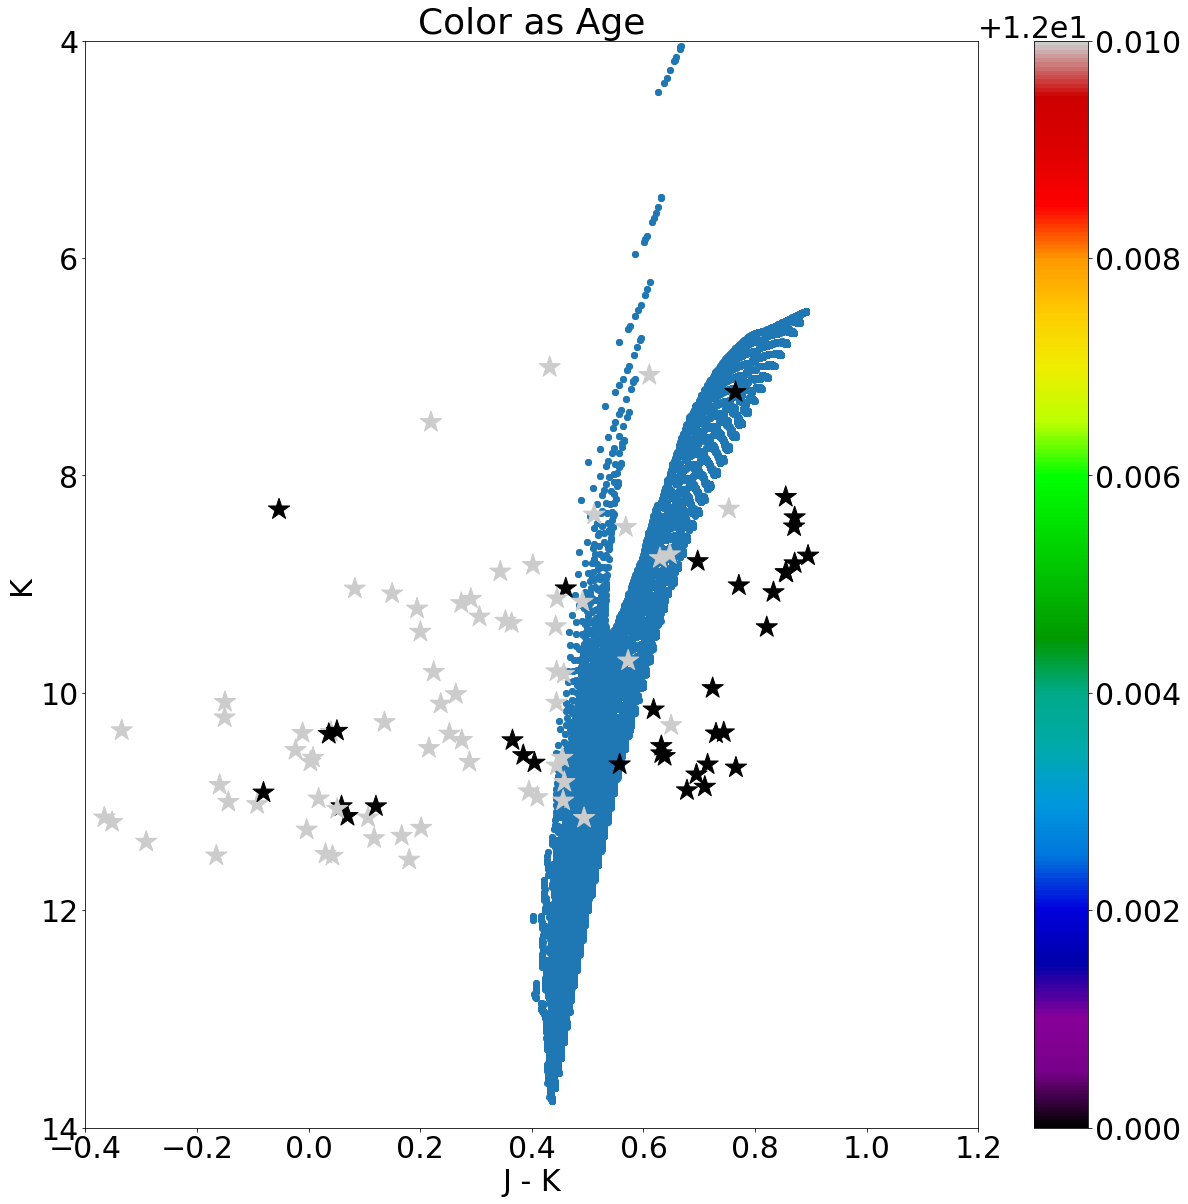

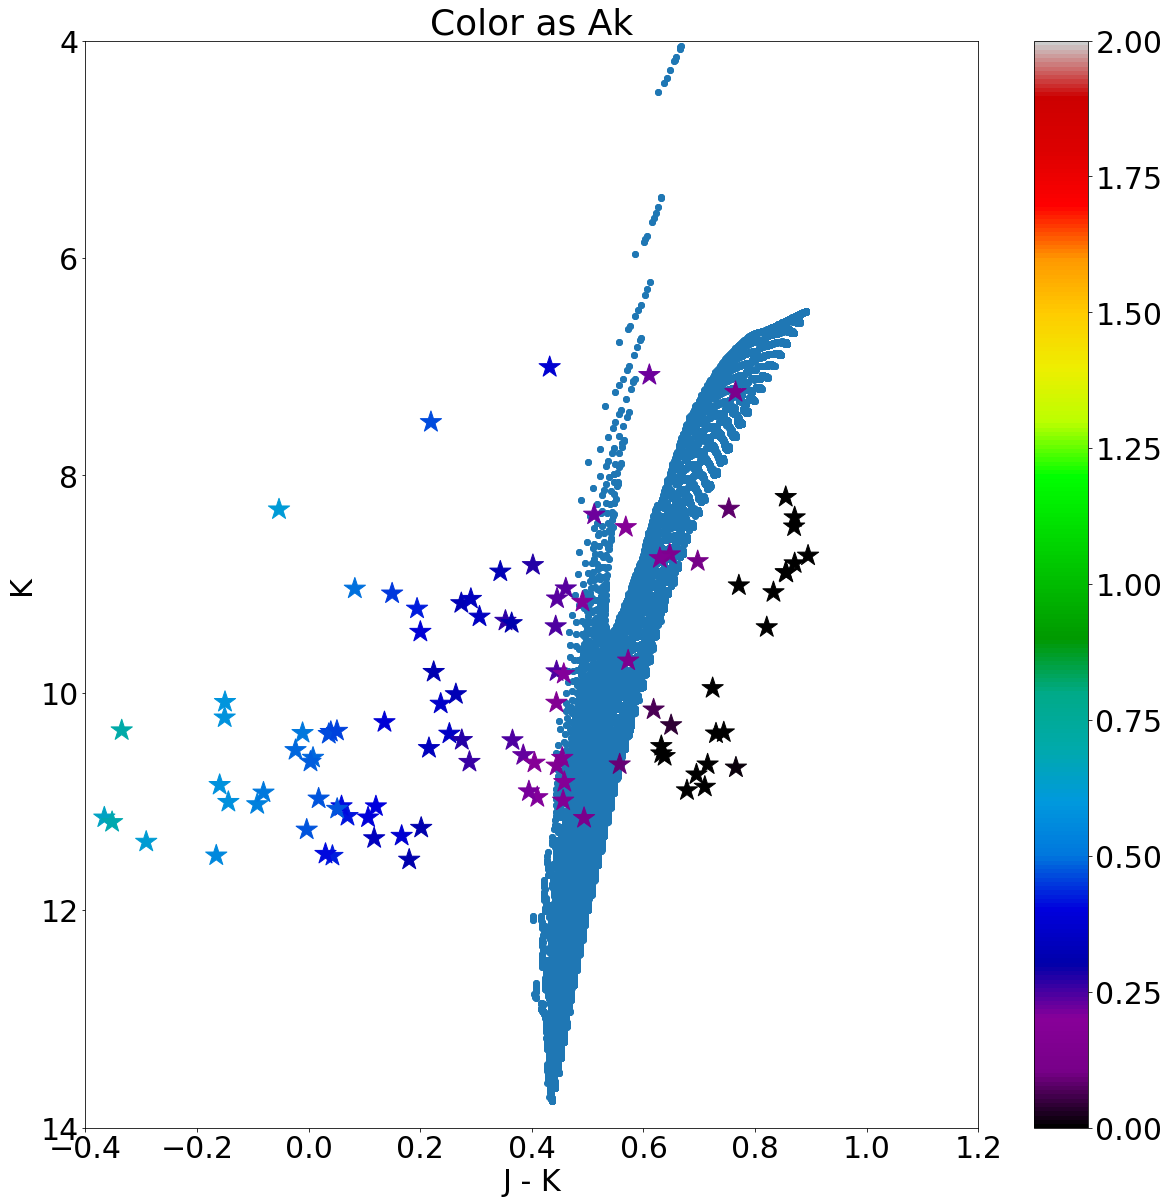

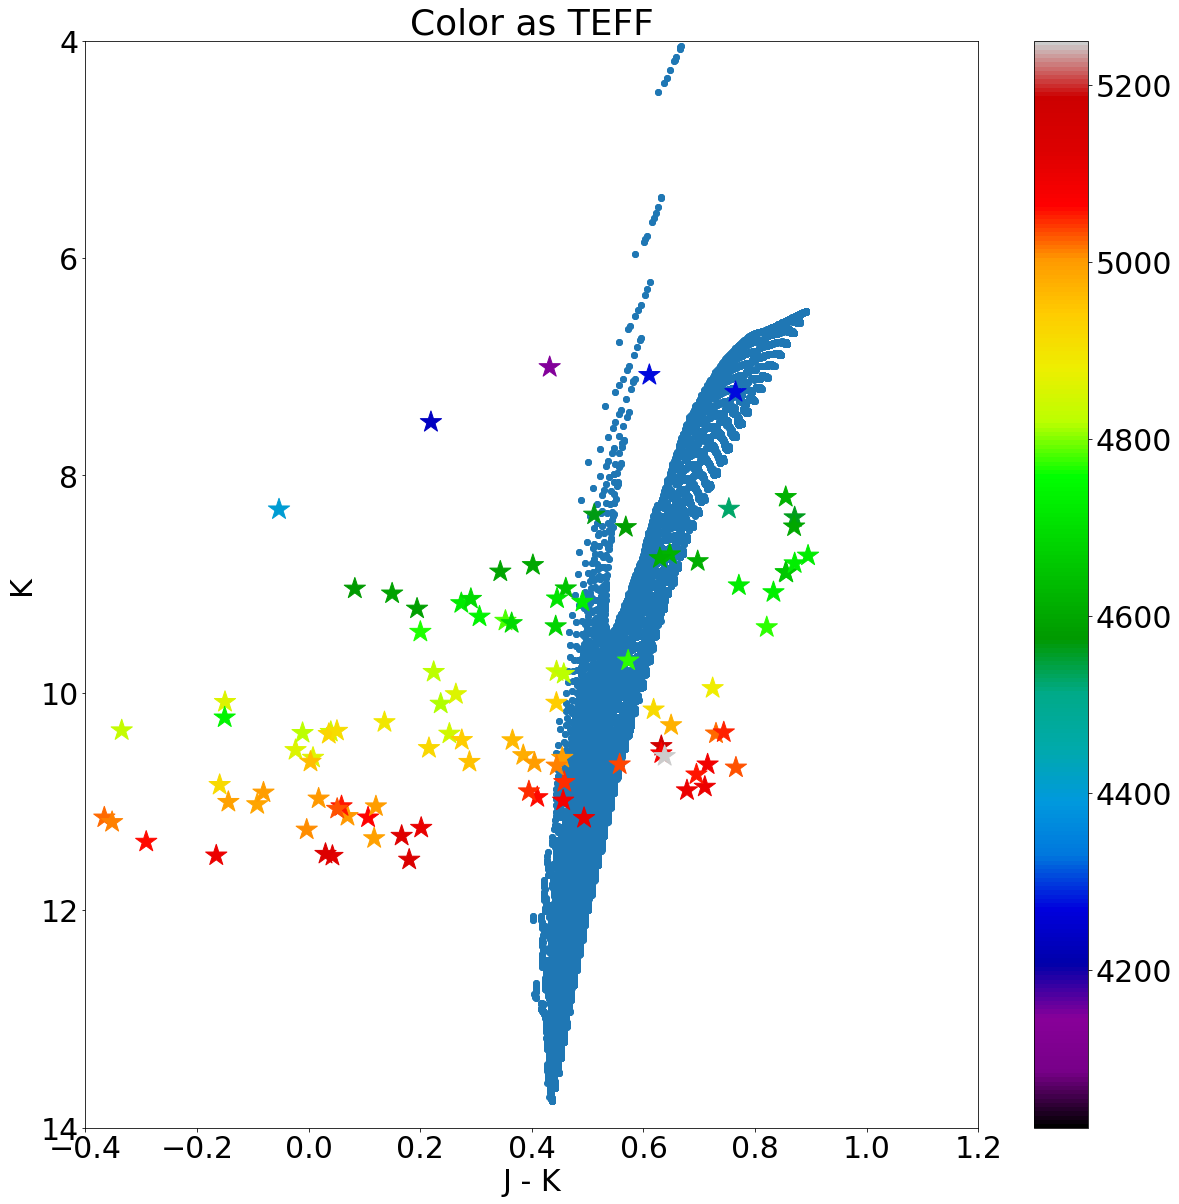

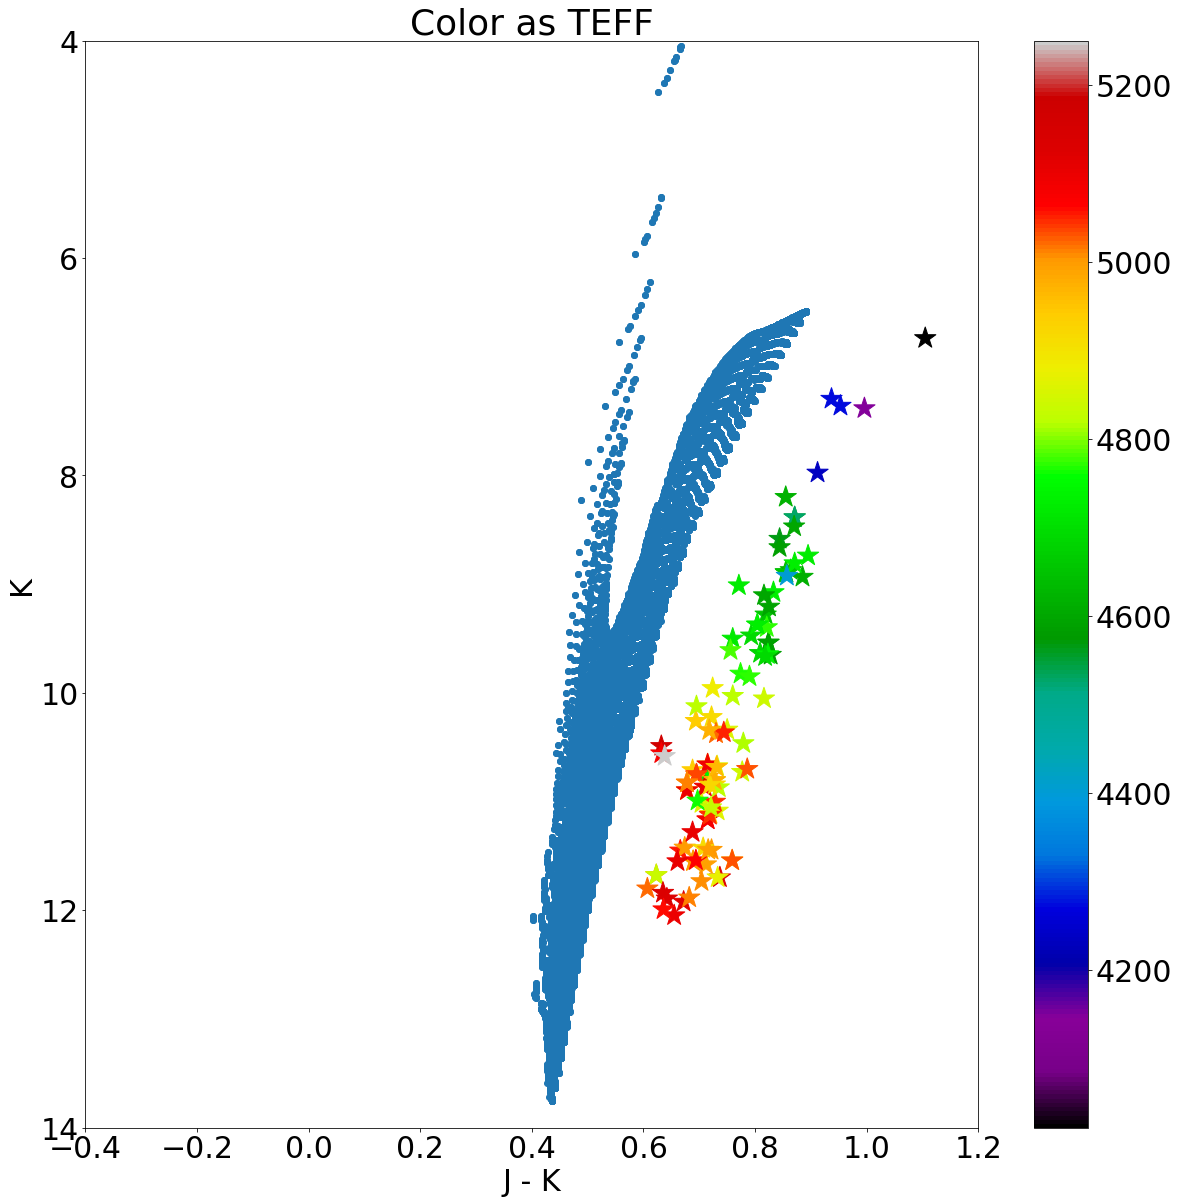

In [171]:
### Age
plt.figure(figsize=[20,20])
plt.scatter((massive['Jmag']-massive['Ksmag'])[m22iso],
            massive['Ksmag'][m22iso]+5*np.log10(gcs_dist[m22_idx][0])-5.0)
plt.scatter((gcs['J']-gcs['K'])[m22_idx]-ejk_ak*np.asarray(bestaks36),gcs['K'][m22_idx]-bestaks36,c=bestages,
            cmap='nipy_spectral',vmax=12.01,
            marker='*',s=500)
plt.colorbar()
plt.gca().invert_yaxis()
plt.title(r'Color as Age')
plt.ylabel(r'K')
plt.xlabel(r'J - K')
plt.ylim(14,4)
plt.xlim(-0.4,1.2)
plt.show()

### Aks
plt.figure(figsize=[20,20])
plt.scatter((massive['Jmag']-massive['Ksmag'])[m22iso],
            massive['Ksmag'][m22iso]+5*np.log10(gcs_dist[m22_idx][0])-5.0)
plt.scatter((gcs['J']-gcs['K'])[m22_idx]-ejk_ak*np.asarray(bestaks36),gcs['K'][m22_idx]-bestaks36,c=bestaks36,
            cmap='nipy_spectral',
            marker='*',s=500,vmax=2.0)
plt.colorbar()
plt.gca().invert_yaxis()
plt.title(r'Color as Ak')
plt.ylabel(r'K')
plt.xlabel(r'J - K')
plt.ylim(14,4)
plt.xlim(-0.4,1.2)
plt.show()

### TEFF
plt.figure(figsize=[20,20])
plt.scatter((massive['Jmag']-massive['Ksmag'])[m22iso],
            massive['Ksmag'][m22iso]+5*np.log10(gcs_dist[m22_idx][0])-5.0)
plt.scatter((gcs['J']-gcs['K'])[m22_idx]-ejk_ak*np.asarray(bestaks36),gcs['K'][m22_idx]-bestaks36,c=gcs['TEFF'][m22_idx],
            cmap='nipy_spectral',
            marker='*',s=500)
plt.colorbar()
plt.gca().invert_yaxis()
plt.title(r'Color as TEFF')
plt.ylabel(r'K')
plt.xlabel(r'J - K')
plt.ylim(14,4)
plt.xlim(-0.4,1.2)
plt.show()

plt.figure(figsize=[20,20])
plt.scatter((massive['Jmag']-massive['Ksmag'])[m22iso],
            massive['Ksmag'][m22iso]+5*np.log10(gcs_dist[m22_idx][0])-5.0)
plt.scatter((gcs['J']-gcs['K'])[m22_idx],gcs['K'][m22_idx],c=gcs['TEFF'][m22_idx],
            cmap='nipy_spectral',
            marker='*',s=500)
plt.colorbar()
plt.gca().invert_yaxis()
plt.title(r'Color as TEFF')
plt.ylabel(r'K')
plt.xlabel(r'J - K')
plt.ylim(14,4)
plt.xlim(-0.4,1.2)
plt.show()

In [172]:
badtheos36 = 999999.0*np.ones((len(np.arange(0,15,0.25)),len(gcs_bad_idx),3))
badtheos360 = 999999.0*np.ones((len(np.arange(0,15,0.25)),len(gcs_bad_idx),3))

for i in tqdm_notebook(range(len(gcs_bad_idx))):
    CalcAge = WhatsMyAgeAgain(gcs['M_H'][gcs_bad_idx[i]],gcs['ALPHA_M'][gcs_bad_idx[i]],gcs_dist[gcs_bad_idx[i]],
                              3.1,massive)

    for j in range(len(np.arange(0,15,0.25))):
        theo = CalcAge.Teff2AppMags(gcs['TEFF'][gcs_bad_idx[i]],np.arange(0,15,0.25)[j],bestaks36[bads[i]])
        theo0 = CalcAge.Teff2AppMags(gcs['TEFF'][gcs_bad_idx[i]],np.arange(0,15,0.25)[j],0)
        badtheos36[j,i,0] = theo[0]
        badtheos36[j,i,1] = theo[1]
        badtheos36[j,i,2] = theo[2]
        badtheos360[j,i,0] = theo0[0]
        badtheos360[j,i,1] = theo0[1]
        badtheos360[j,i,2] = theo0[2]

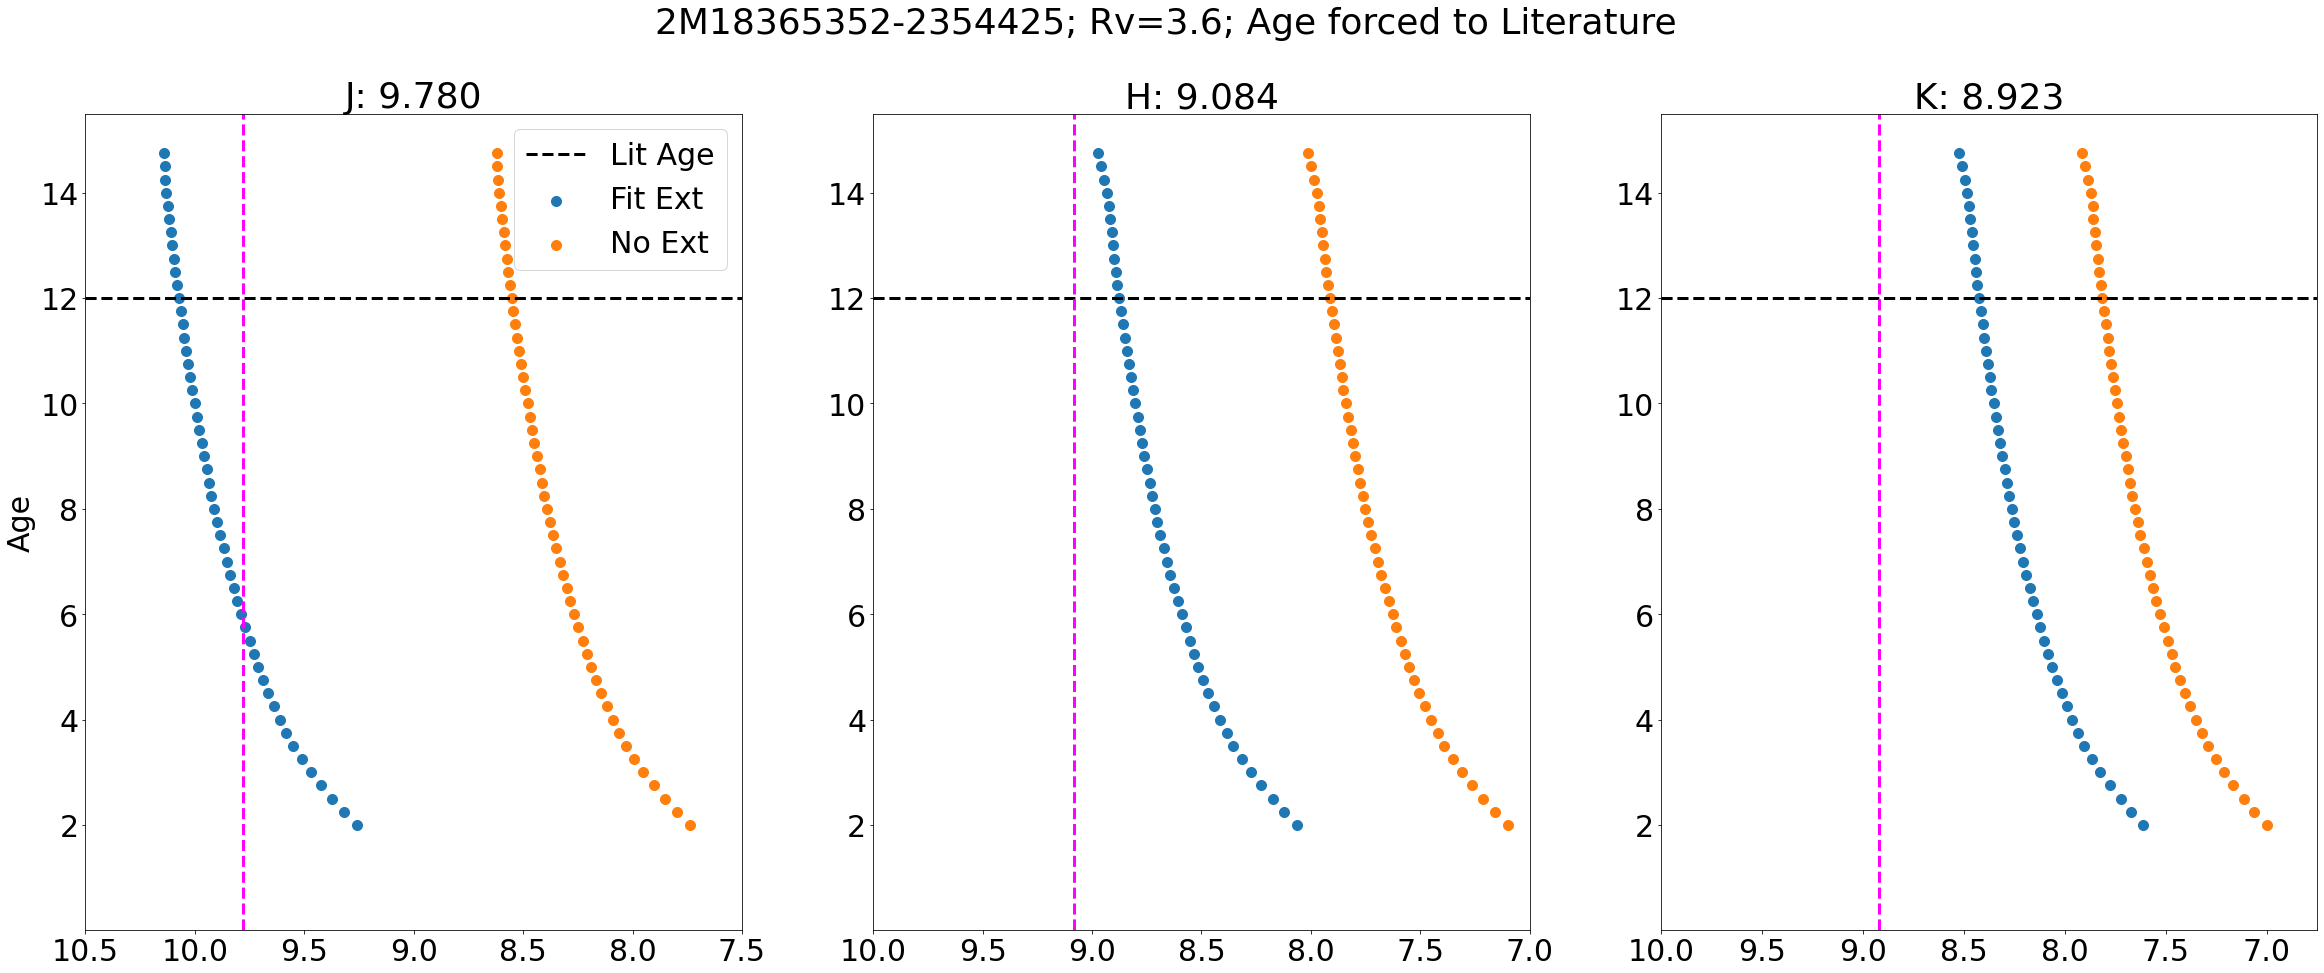

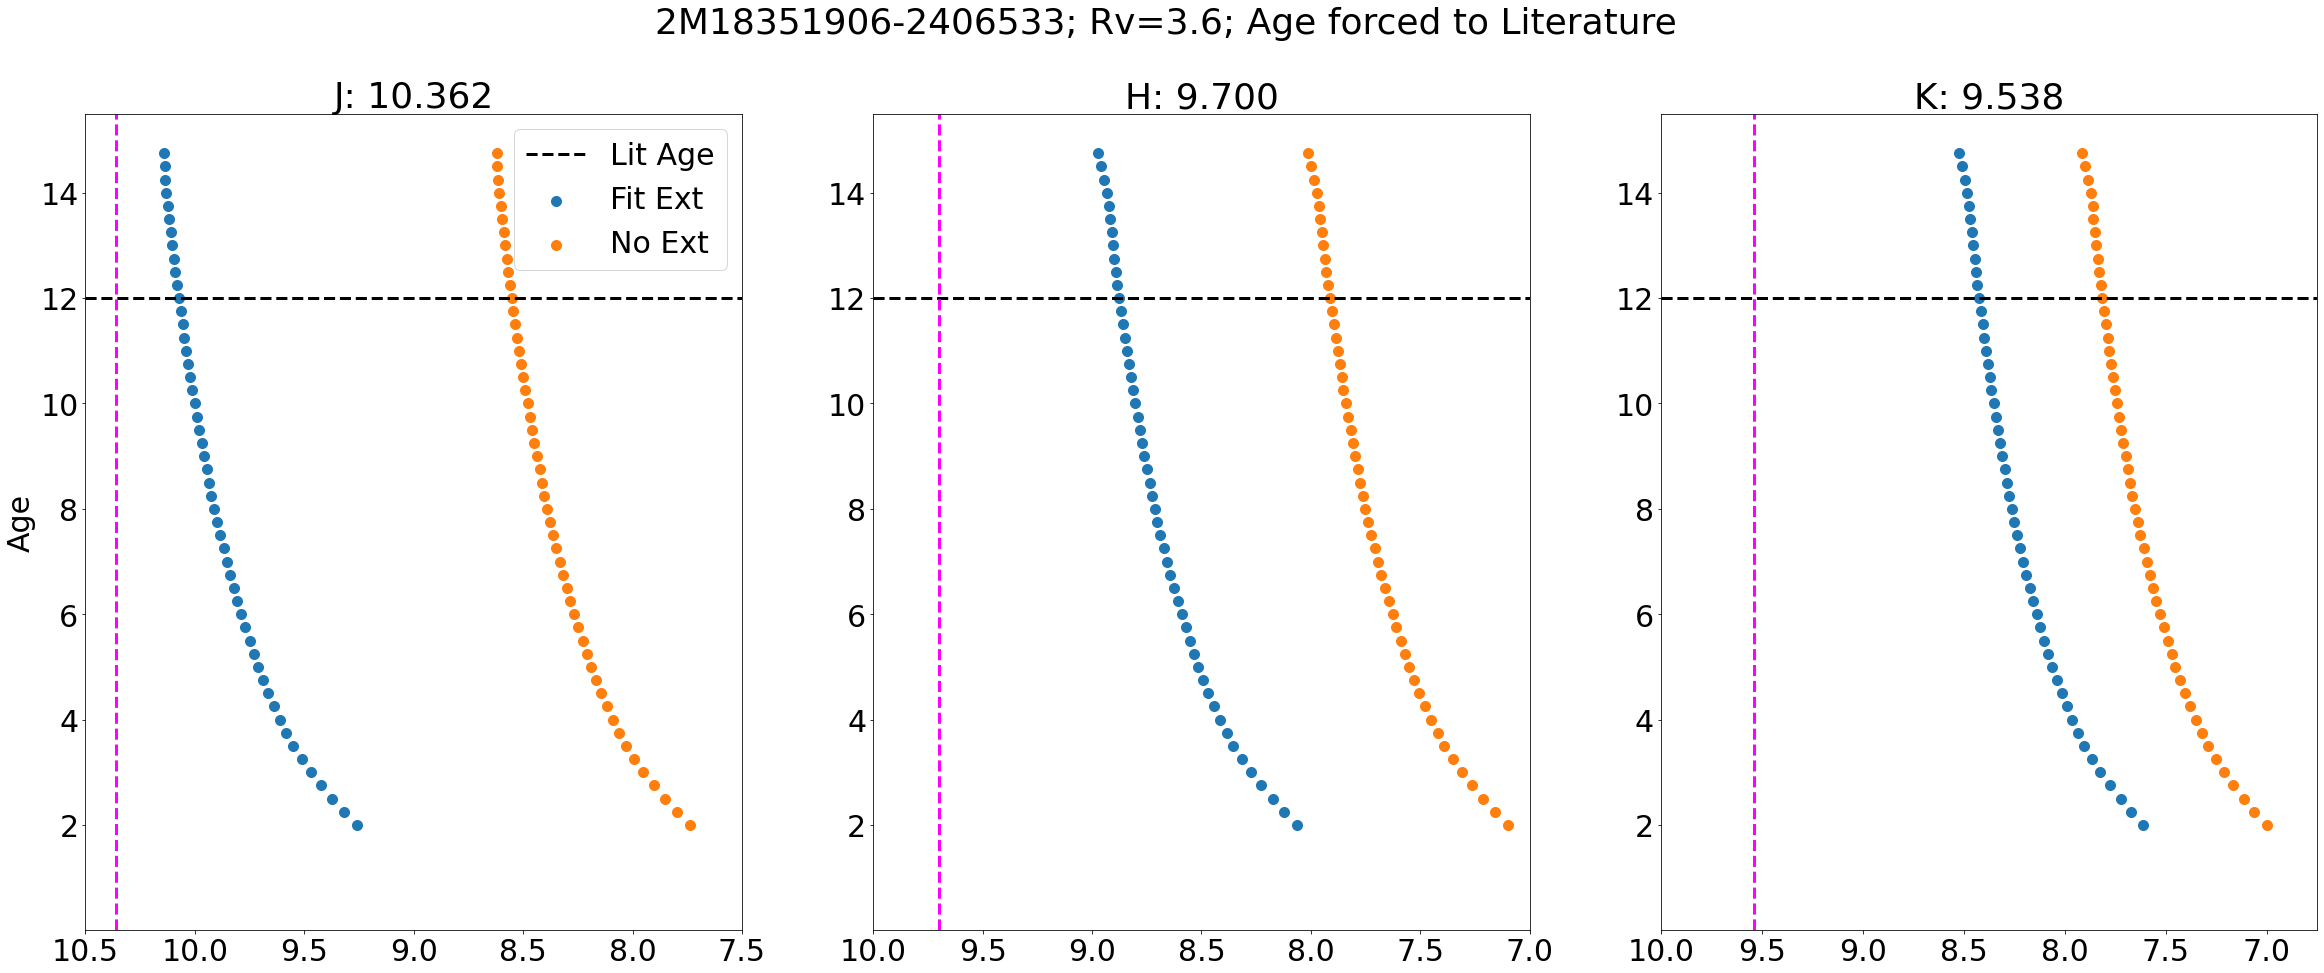

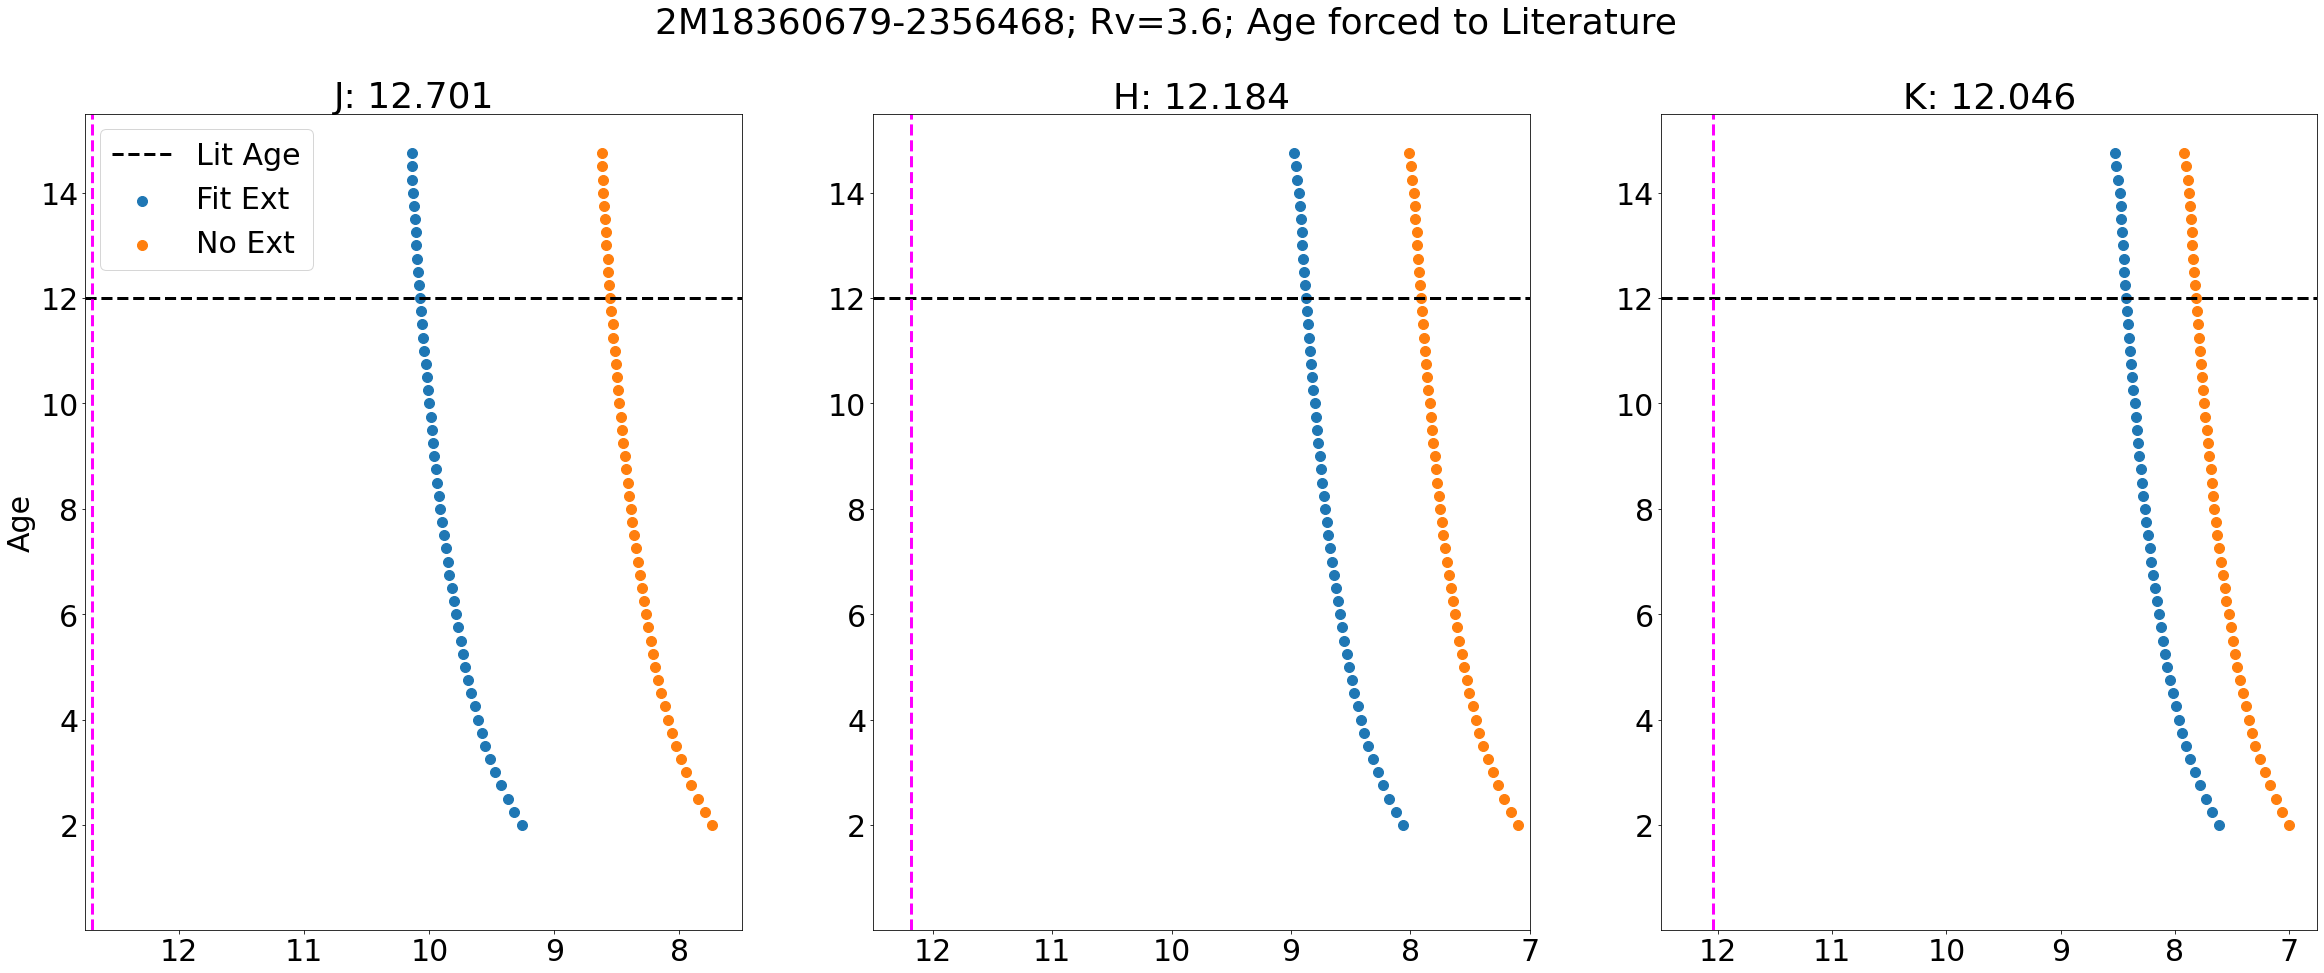

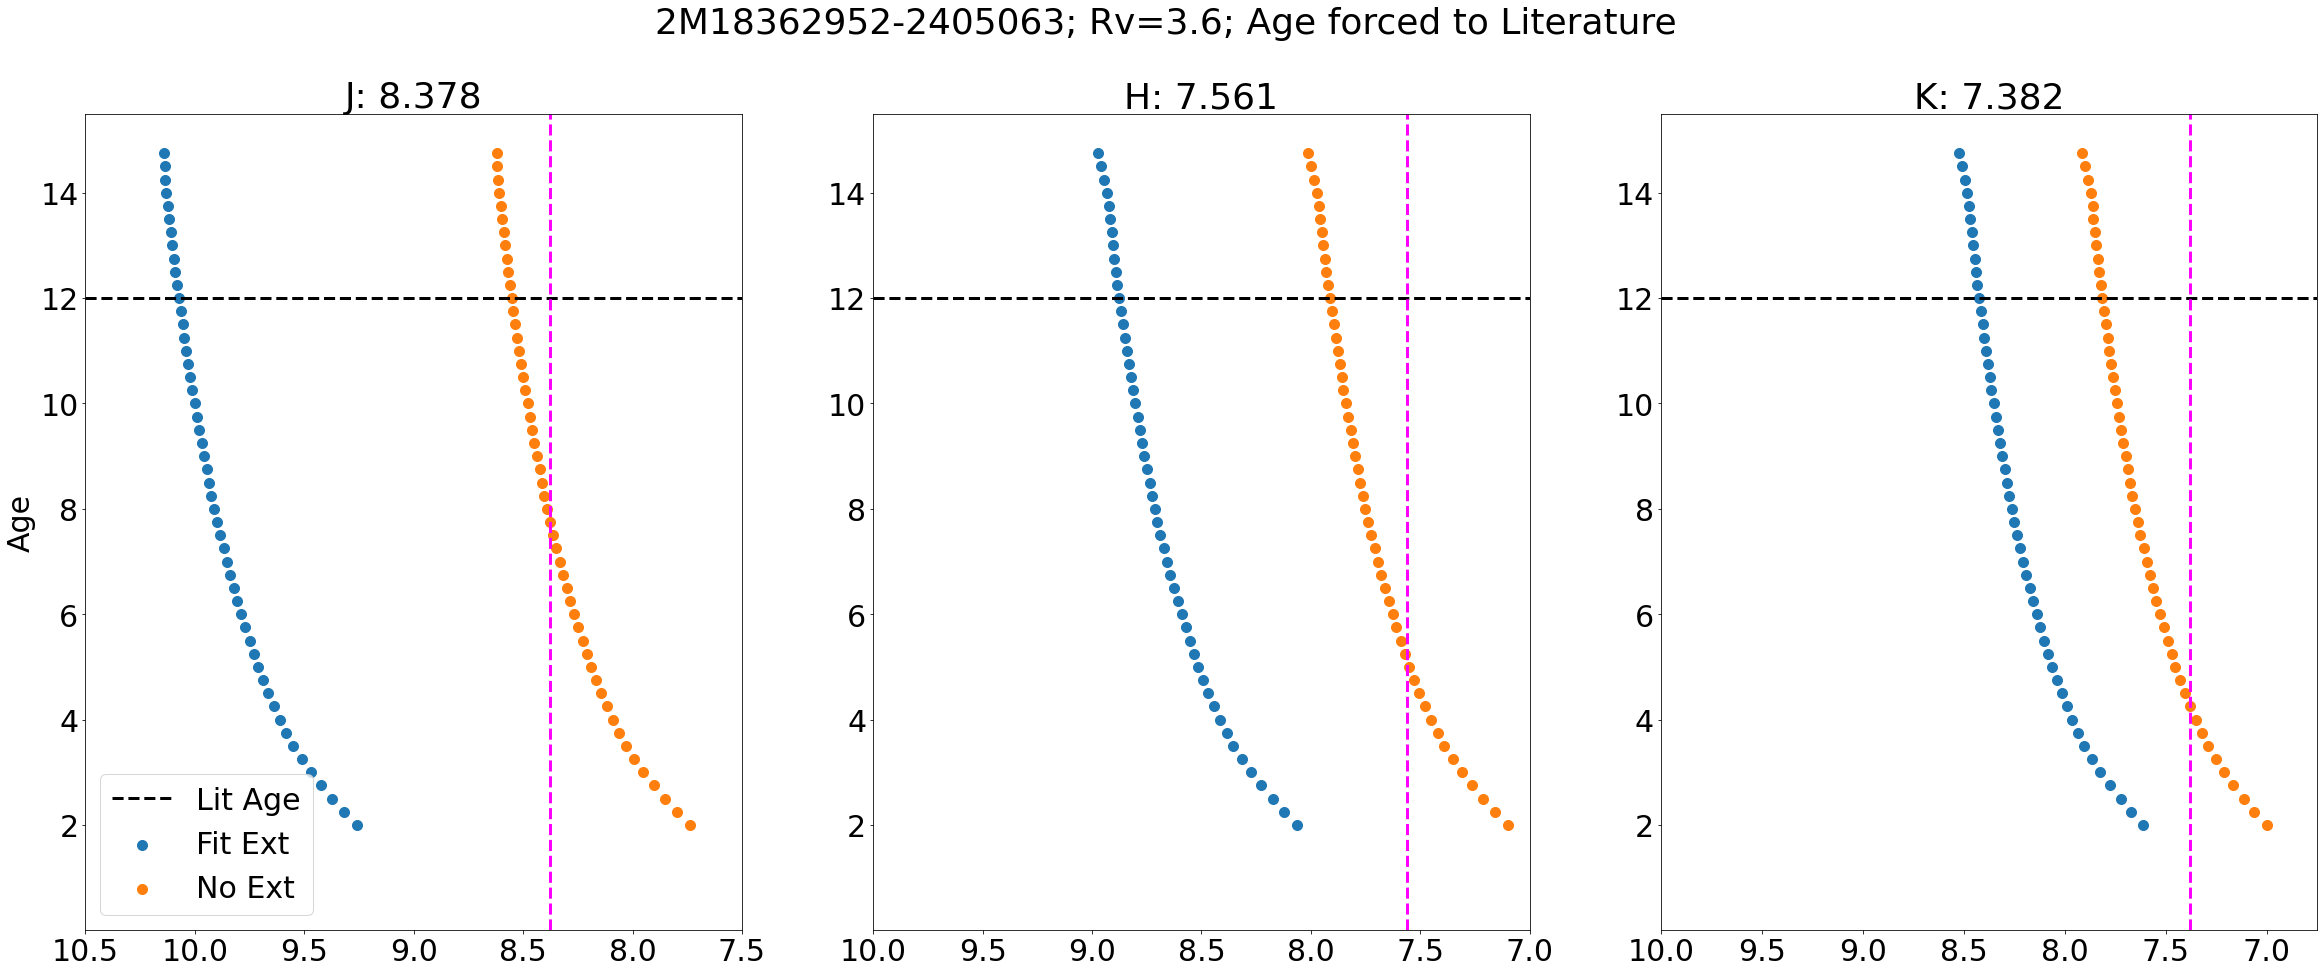

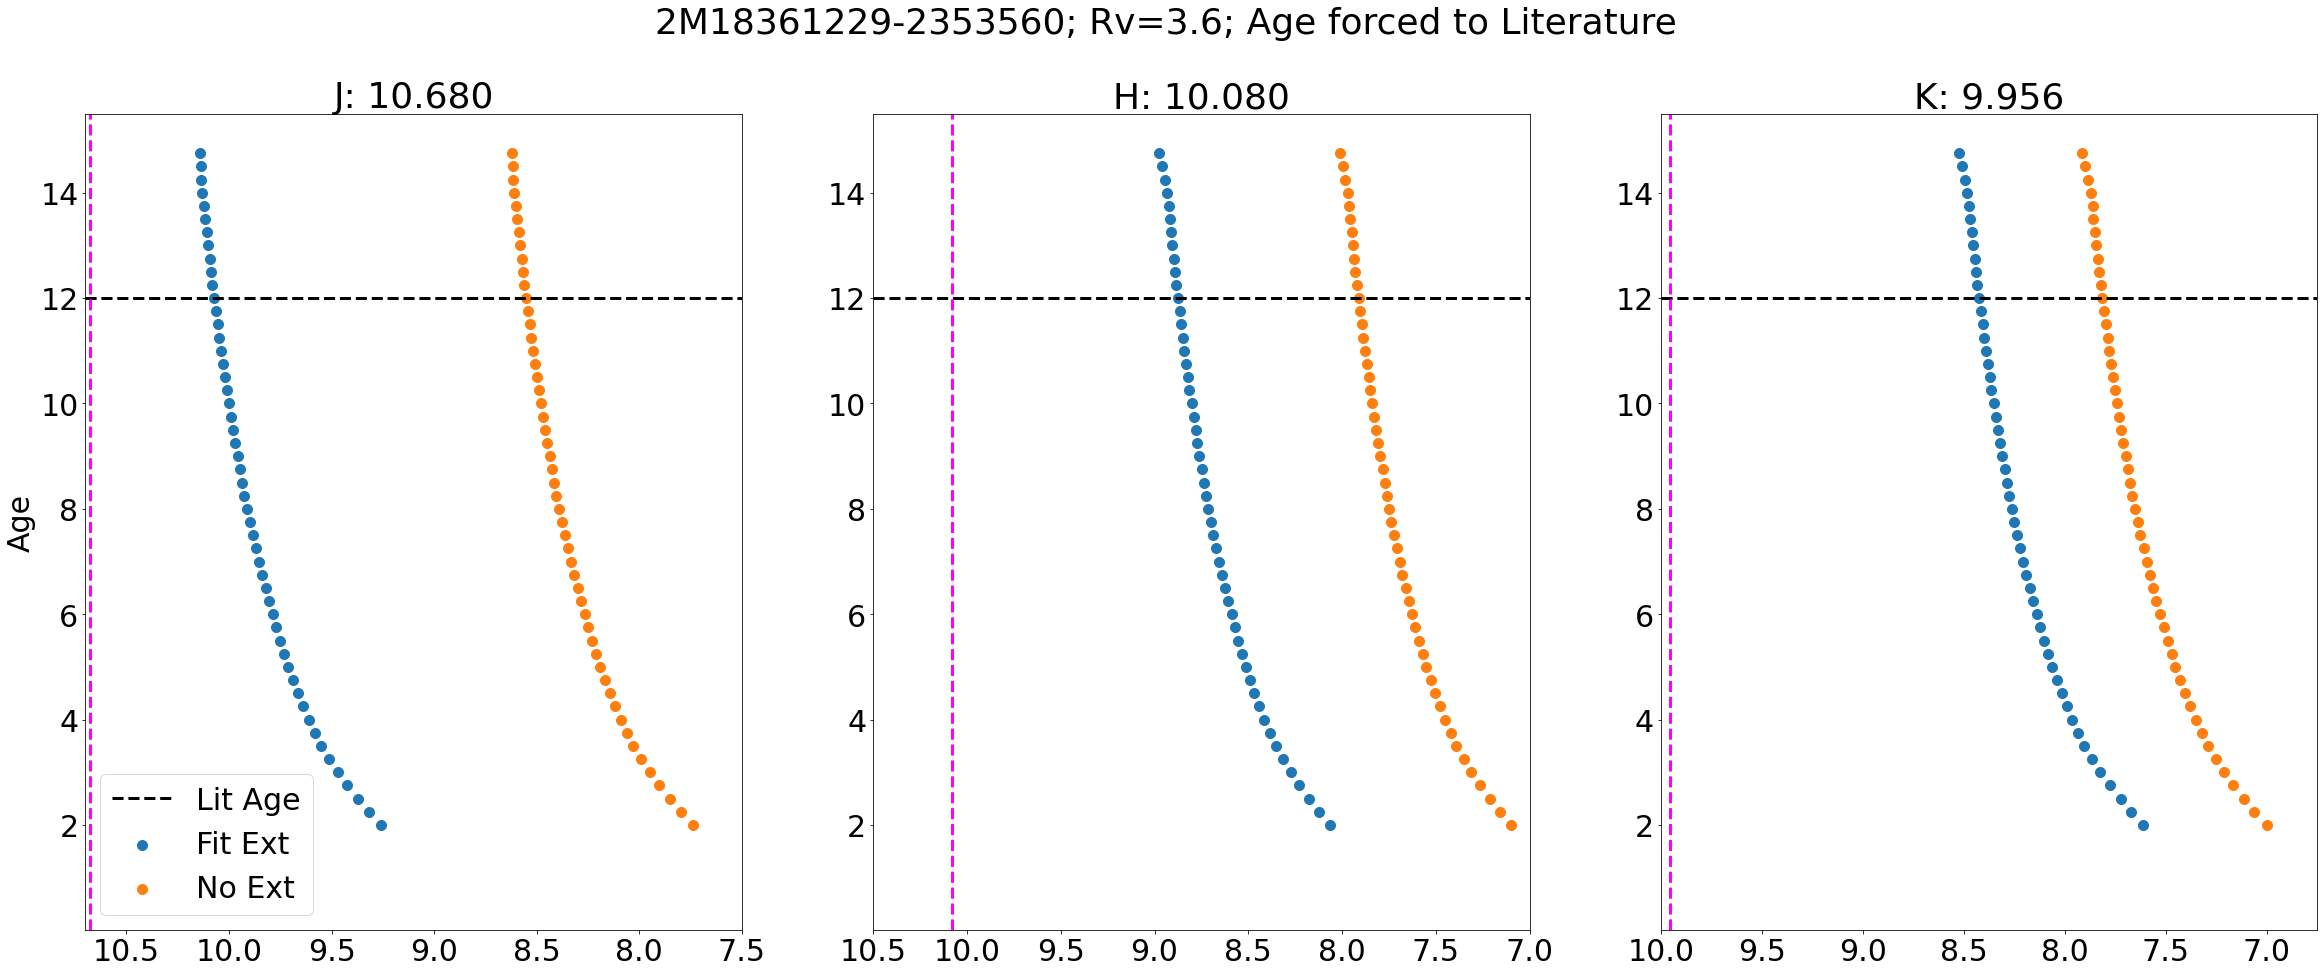

In [175]:
bands = ['J','H','K']
for j in range(len(gcs_bad_idx)):
    fig, ax = plt.subplots(1,3,figsize=[40,15])
    for i in range(3):
        ax[i].scatter(badtheos36[:,0,i],np.arange(0,15,0.25),s=100,label='Fit Ext')
        ax[i].scatter(badtheos360[:,0,i],np.arange(0,15,0.25),s=100,label='No Ext')
        ax[i].set_ylim(bottom=0.01)
        ax[i].axhline(12.0,c='k',ls='--',label='Lit Age',lw=3.0)

    ax[0].axvline(gcs[gcs_bad_idx[j]]['J'],ls='--',c='magenta',lw=3.0)
    ax[1].axvline(gcs[gcs_bad_idx[j]]['H'],ls='--',c='magenta',lw=3.0)
    ax[2].axvline(gcs[gcs_bad_idx[j]]['K'],ls='--',c='magenta',lw=3.0)

    ax[0].set_title(r'J: {:.3f}'.format(gcs[gcs_bad_idx[j]]['J']))
    ax[1].set_title(r'H: {:.3f}'.format(gcs[gcs_bad_idx[j]]['H']))
    ax[2].set_title(r'K: {:.3f}'.format(gcs[gcs_bad_idx[j]]['K']))

    ax[0].set_xlim(10.5,7.5)
    ax[1].set_xlim(10.,7.)
    ax[2].set_xlim(10.,6.75)
    
    if j == 2:
        ax[0].set_xlim(12.75,7.5)
        ax[1].set_xlim(12.5,7.)
        ax[2].set_xlim(12.5,6.75)
        
    if j == 4:
        ax[0].set_xlim(10.7,7.5)
        ax[1].set_xlim(10.5,7.)
        ax[2].set_xlim(10.,6.75)

    ax[0].legend()

    ax[0].set_ylabel('Age')
    plt.suptitle(r'{}; Rv=3.6; Age forced to Literature'.format(gcs[gcs_bad_idx[j]]['APOGEE_ID']))

    plt.show()

In [ ]:
# fitting with only one initial guess
curve fit print values in model function
check outputs